# Project tasks

- Please rename this file so that you know which copy you have been working in. Keep a copy safe (especially if you are working in the online Jupyter service). You can download a copy by choosing -File- then -Download as- Notebook from the menu above. 
- These tasks are intended to be open-ended, use the questions as a guide, but **you should further investigate the datasets** to answer other interesting questions about them.

---

## Task 1 - Edinburgh cycle hire data

The first task is to investigate the dataset in the file `bikes_October18.csv` which contains anonymised data for all trips taken in October 2018 with the Edinburgh Cycle Hire bikes (found [here](https://edinburghcyclehire.com/open-data/historical)). This dataset is kindly supplied for use by Edinburgh Cycle Hire under the [Open Government License (OGL) v3.0](https://www.nationalarchives.gov.uk/doc/open-government-licence/version/3/).

- What is the average journey time and distance of bike trips which started on a Tuesday?
- How many stations appear in the dataset? Which were the most common starting stations? Think about how to display/plot the results of your analysis.
- What was the most common time(s) of day for journeys to be undertaken?
- Can you process the geographic information (latitudes and longitudes of start and end stations), and display this in an interesting way?
- Can you use the data to answer any other interesting questions about the bike trips?


Please include all the code used to generate your answer and plots, and remember to investigate beyond the initial scope of the questions.

# Package Imports and Style

In [1]:
%matplotlib inline
import numpy as np
import statistics as stats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import re
import math
import warnings

# For bearing and arrow functions
from collections import namedtuple


# For plotting co-ordinates
import folium

# Plot style
sns.set(style="darkgrid")

# Functions

## Data Cleaning

In [2]:
def weekday_series(datetime_series):
    '''
    
    Converts a series of datetimes into an ordered categorical series of 
    days of the week
    
    Arguments
    ------------
    datetimes_series: A pandas series of datetime objects. 
    
    Returns
    ------------
    day_categ: An ordered pandas categorical series, where the categories are the 
               days of the week. 
    
    Example
    ------------
    >>> dates = ['2018-01-01', '2018-01-02', '2018-01-03']
    >>> dates = pd.Series(dates)
    >>> dates = pd.to_datetime(dates)
    >>> weekday_series(dates)
    [Monday, Tuesday, Wednesday]
    Categories (7, object): [Monday < Tuesday < Wednesday < Thursday < Friday < Saturday < Sunday]
    '''
    wd_mapping = {0: 'Monday', 1:'Tuesday', 2:'Wednesday', 3: 'Thursday', 4: 'Friday', 5: 'Saturday', 6: 'Sunday'}
    
    # Get numeric representation of days
    day_of_week = datetime_series.dt.dayofweek
    
    
    # Use dictionary to extract day of week as string, given dictionary above
    day_of_week = day_of_week.apply(lambda wd_index: wd_mapping[wd_index])
    
    
    # Convert to pandas categorical
    day_categ = pd.Categorical(day_of_week,
                                 categories=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'],
                                 ordered=True
                                )
    return day_categ


def month_series(datetime_series):
    '''
    
    Converts a series of datetimes into an ordered categorical series of months
    
    Arguments
    ------------
    datetimes_series: A pandas series of datetime objects. 
    
    Returns
    ------------
    month_series_categ: Pandas ordered categorical series of months
    
    Example
    ------------
    >>> dates = ['2018-01-01', '2018-01-02', '2018-01-03','2018-02-03', '2018-06-06']
    >>> dates = pd.Series(dates)
    >>> dates = pd.to_datetime(dates)
    >>> month_series(dates)
    [January, January, January, February, June]
    Categories (12, object): [January < February < March < April ... September < October < November <
                              December]
    
    '''
    
    # Get long form of month given a datetime object
    month_series = datetime_series.dt.strftime('%B')
    
    # Cpnstruct an ordered category
    month_series_categ = pd.Categorical(month_series,
                                        categories = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 
                                                      'August', 'September', 'October', 'November', 'December'],
                                        ordered = True)
    return month_series_categ

    
def time_extract(datetime_series, timeprecision='hour'):
    '''
    Converts a series of datetimes into a series of integers, where the integers
    represent the {timeprecision} component of the time in each datetime. 
    
    Arguments
    ------------
    datetimes_series: A pandas series of datetime objects.
    timeprecision:    The time part the user wishes to extract
    
    Returns
    ------------
    datetime_series.dt.precision: Pandas integer series of the specified time precision
    
    Example
    ------------
    >>> datetimes = ['2018-01-01 02:04:00', '2018-01-01 04:04:00', '2018-01-01 12:04:00','2018-01-01 15:04:00', '2018-01-01 19:04:00']
    >>> datetimes = pd.Series(datetimes)
    >>> datetimes = pd.to_datetime(datetimes)
    >>> time_extract(datetimes)    
    0     2
    1     4
    2    12
    3    15
    4    19
    
    '''
    # Convert string time to datetime

    
    # Return the requested time precision. 
    if timeprecision == 'hour':
        return datetime_series.dt.hour
    elif timeprecision == 'minute':
        return datetime_series.dt.minute
    if timeprecision == 'second':
        return datetime_series.dt.second
    
    
def time_of_day(datetime_series, precision = 'min'):
    '''
    Converts a series of datetimes into a series of times. The time is truncated
    to the precision component. I.e. 2:04:00 with precision 'hour' is 2:00:00
    
    Arguments
    ------------
    datetimes_series: A pandas series of datetime objects.
    precision:        Most precise part of time to truncate to. 
    
    Returns
    ------------
    datetime_series: Pandas series of times of the specified precision
    
    
    Example
    ------------
    >>> datetimes = ['2018-01-01 02:06:00', '2018-01-01 04:04:00', '2018-01-01 12:04:00','2018-01-01 15:04:00', '2018-01-01 19:04:00']
    >>> datetimes = pd.Series(datetimes)
    >>> datetimes = pd.to_datetime(datetimes)
    >>> time_of_day(datetimes)    
    0    02:06:00
    1    04:04:00
    2    12:04:00
    3    15:04:00
    4    19:04:00
    dtype: object
    '''
    datetime_series = datetime_series.dt.floor(precision)
    datetime_series = datetime_series.dt.time
    return datetime_series


def date_extract(datetime_series):
    '''
    
    Converts a series of datetimes into a series of dates
    
    Arguments
    ------------
    datetimes_series: A pandas series of datetime objects, with time component.
    
    Returns
    ------------
    datetime_series: Pandas series of datetime objects, with just the date component.
    
    
    Example
    ------------
    >>> datetimes = ['2018-01-05 02:06:00', '2018-02-04 04:04:00', '2018-03-03 12:04:00','2018-01-01 15:04:00', '2018-01-01 19:04:00']
    >>> datetimes = pd.Series(datetimes)
    >>> datetimes = pd.to_datetime(datetimes)
    >>> date_extract(datetimes)        
    0    2018-01-05
    1    2018-02-04
    2    2018-03-03
    3    2018-01-01
    4    2018-01-01
    dtype: object
    
    
    '''
    datetime_series = datetime_series.dt.date
    return datetime_series

    
def data_clean(justeat_df, inplace=True):
    '''
    Cleans a dataframe using the just-eat open cycle data from:
    
    https://edinburghcyclehire.com/open-data/historical
    
    By default this changes the argument to the function, but this can be changed to inplace=FALSE
    if the user wishes to create a copy
    
    Arguments
    ------------
    justeat_df: A pandas dataframe of the structure seen in https://edinburghcyclehire.com/open-data/historical
    inplace:    Whether the data cleaning should be performed in place or if a copy should be made
    
    Returns
    ------------
    if inplace is True:  Nothing is returned, operations are performed on the passed dataframe
    if inplace is False: Returns a dataframe with all the same operations performed on it. 
    
    
    '''
    # Create start and end day columns
    # Get datetimes, as strings due to data format
    # Use weekday_series() to convert these string dates into the day of the week, and add to justeat_df
    
    justeat_start_datetime = pd.to_datetime(justeat_df['started_at'])
    justeat_end_datetime = pd.to_datetime(justeat_df['ended_at'])


    if inplace == True:
        # New columns
        justeat_df['start_date']    = date_extract(justeat_start_datetime)
        justeat_df['end_date']      = date_extract(justeat_end_datetime)
        justeat_df['start_month']   = month_series(justeat_start_datetime)
        justeat_df['end_month']     =  month_series(justeat_end_datetime)
        justeat_df['start_day']     = weekday_series(justeat_start_datetime)
        justeat_df['end_day']       =  weekday_series(justeat_end_datetime)
        justeat_df['start_hour']    =  time_extract(justeat_start_datetime)
        justeat_df['start_time']    = time_of_day(justeat_start_datetime)
        justeat_df['end_time']      =  time_of_day(justeat_end_datetime)
        justeat_df['end_hour']      =   time_extract(justeat_end_datetime)
        justeat_df['duration_mins'] = justeat_df['duration']/60
        justeat_df['count']         = 1 #  A column for counting        
        # Old column manipulation
        # 6 decimal places enough precision, and will prevent errors
        # https://en.wikipedia.org/wiki/Decimal_degrees
        justeat_df['start_station_latitude']  = round(justeat_df['start_station_latitude'], 6)
        justeat_df['start_station_longitude'] = round(justeat_df['start_station_longitude'], 6)
        justeat_df['end_station_latitude']    = round(justeat_df['end_station_latitude'], 6)
        justeat_df['end_station_longitude']   = round(justeat_df['end_station_longitude'], 6)
        # Now use these to create co-ordinates
        # Also combine name and description into one string. 
        justeat_df['start_co_ordinate']   = justeat_df.apply(lambda row: (row['start_station_latitude'], row['start_station_longitude']), axis=1)
        justeat_df['start_name_and_desc'] = justeat_df.apply(lambda row: row.loc['start_station_name'] + ', ' +  row['start_station_description'], axis=1)
        justeat_df['end_co_ordinate']     = justeat_df.apply(lambda row: (row['end_station_latitude'], row['end_station_longitude']), axis=1)
        justeat_df['end_name_and_desc']   = justeat_df.apply(lambda row: row['end_station_name'] + ', ' +  row['end_station_description'], axis=1)
        
        
        justeat_df.rename(index  =  str, columns={'duration':'duration_secs'}, inplace = True)        
        
    else:
        justeat_df2 = justeat_df.copy()
        # Calls this function with inplace=True to operate on the new df. 
        data_clean(justeat_df2, inplace=True)
        return justeat_df2

## Mathematical Functions

In [3]:
def nearest_ceil(x, nearest = 10):
    '''
    Rounds x up to the nearest value inputted, defaulted to 10
    
    Arguments
    ------------
    x: Value to round up.
    nearest: Round up x to the closest 'nearest'. Default value is 10, so round x up to the nearest 10
             Nearest need not be an integer. 
             
    Returns
    ------------
    x rounded up to the nearest 10 (by default). 
    
    
    Examples
    ------------
    >>> x = 5.6
    >>> nearest_ceil(x, nearest = 10)
    10
    
    >>> x = 21.1
    >>> nearest_ceil(x, nearest = 10)
    30
    
    >>> x = 29.1
    >>> nearest_ceil(x, nearest = 100)
    100
    
    >>> x = 29.1
    >>> nearest_ceil(x, nearest = 101.3)
    101.3
    '''

    
    return int(math.ceil(x/float(nearest)))*nearest

def haversine(lat1, lon1, lat2, lon2, L1=False):
    '''
    
    Calculates the haversine distance between 2 points given their 4 co-ordinates.
    The distance measure is L2 by default, but can also be L1. 
    
    Calculates either L2 or L1 distance between co-ordinates. L1 is an approximation of distance travelled for
    small distances
    
    Credit to:
    https://stackoverflow.com/questions/4913349/haversine-formula-in-python-bearing-and-distance-between-two-gps-points
    
    Arguments
    ------------
    lat1: Latitude  of first point
    lon1: Longitude of first point
    lat2: Latitude  of second point
    lon2: Longitude of second point
             
    Returns
    ------------
    Distance between (lat1, lon1) and (lat2, lon2) co-ordinates as either L1
    or L2 distance depending on the specification. The distance is in miles. 
    
    Examples
    ------------
    >>> lat1, lat2, lon1, lon2 = 0.1, 0.2, 0.1, 0.201
    >>> haversine(lat1, lon1, lat2, lon2)
    9.823006376327232
    
    '''
    if L1 == False:
        R = 3959.87433

        dlat = math.radians(lat2-lat1)
        dlon = math.radians(lon2-lon1)
        lat1 = math.radians(lat1)
        lat2 = math.radians(lat2)

        a = math.sin(dlat/2)**2 + math.cos(lat1)*math.cos(lat2)*math.sin(dlon/2)**2
        c = 2*math.asin(math.sqrt(a))
        return R*c

    else:
        # latitude distance
        lat_dist = haversine(lat1, 0, lat2, 0, L1=False)
        # longitude distance
        long_dist = haversine(0, lon1, 0, lon2, L1=False)
        return lat_dist + long_dist


def within_distance(co_ord_1, co_ord_2, distance = 0.5, distance_unit = 'miles'):
    '''
    Checks if 2 co-ordinates are within a certain L2 distance of each other
    
    
    Arguments
    ------------
    co_ord_1: (Latitude, Longitude) ordered iterable. A co-ordinate 
    co_ord_2: (Latitude, Longitude) ordered iterable. A co-ordinate 
    distance: Distance we want to see is between points
    distance_unit: Unit of distance, can be miles or kilometres. No need to set any
                   argument for miles, but if kilometres, options are
                   ('km', 'kilometres', 'kilometers') or with any upper case letters. 
             
    Returns
    ------------
    Boolean. 1 if the co-ordinates are less than {distance} from each other, 0 otherwise
    
    Examples
    ------------
    >>> co_ord_1, co_ord_2 = (1, 1), (1.001, 1.001)
    >>> within_distance(co_ord_1, co_ord_2, distance = 1, distance_unit = 'miles')
    True
    '''
    if distance_unit.lower() not in {'miles', 'mil', 'km', 'kilometres', 'kilometers'}:
        error_message = ''' The distance when converted to lower case must be in:
        {'miles', 'mil', 'km', 'kilometres', 'kilometers'}
        '''
        raise ValueError(error_message)
    
    
    # If entered in km, convert to miles
    
    if distance_unit.lower() in ('km', 'kilometres', 'kilometers'):
        distance = 0.621371*distance
    
    # Get latitude and longitude to put in haversine function
    lat_1 = co_ord_1[0]
    lon_1 = co_ord_1[1]
    lat_2 = co_ord_2[0]
    lon_1 = co_ord_2[1]
    
    # Get L2 distance between points
    L2_dist = haversine(lat_1, lon_1, lat_2, lon_1, L1=False)
    
    # Is L2 distance less than the distance specified?
    return L2_dist < distance


def normalise(iterable_to_scale, min_val, max_val, output_type = list):
    '''
    Takes an iterable and rescales its values to be between min_val and max_val.
    This uses min-max normalisation to get the values on (0,1) then rescaling that 
    to (min_val, max_val). 
    '''
    # Convert to array for vector operations
    # get min and max
    arr = np.array(iterable_to_scale)
    min_arr = min(arr)
    max_arr = max(arr)
    # Initial normalisation to (0,1)
    norm_arr = (arr - min_arr)/(max_arr - min_arr)
    
    # Scale to specified min and max
    scaled_arr = (max_val - min_val)*norm_arr + min_val
    return output_type(scaled_arr)   


## Printing

In [4]:
def top_k(x, k=5, suppress_warning = False):
    '''
    
    Takes an iterable, and returns the first k elements as a string which 
    looks like a sentence in good English. 
    
    Arguments
    --------------
    x: The iterable
    k: The number of elements to print in good English
    suppress_warning: If you want to suppress the warning that comes from 
                      passing a string. 
    
    Example
    ---------------
    
    >>> top_k(['JFK', 'FDR', 'GWB'])
    JFK, FDR, and GWB
    '''
    # Check x is iterable, and warn user if a string is passed
    try:
        x[0]
    except:
        raise ValueError('x must be iterable')
    
    # Warn the user if they passed a string as the argument. 
    if type(x) == type('s') and suppress_warning == False:
        warnings.warn('You passed a string to x. Make sure this is what you wanted to do. ')
    
    # Ensure the specified k does not exceed the bounds of the list. 
    # if it does, just make k the item length. 
    item_length = len(x)
    k = min(k, item_length)
    
    # String start
    string = f'"{x[0]}"'
    for i in range(1,k):
        # For last element in the list, put 'and'
        if i == k-1:
            string += f', and "{x[i]}".'
        # Normal case: Add a comma, and the entry. 
        else:
            string += f', "{x[i]}"'
    
    return string

## Maps:

Credit for get_arrows and get_bearing go to:

https://medium.com/@bobhaffner/folium-lines-with-arrows-25a0fe88e4e


In [5]:
def get_arrows(locations,map_arg, color='blue', size=6, n_arrows=3):
    
    '''
    Get a list of correctly placed and rotated 
    arrows/markers to be plotted
    
    Parameters
    locations : list of lists of lat lons that represent the 
                start and end of the line. 
                eg [[41.1132, -96.1993],[41.3810, -95.8021]]
    arrow_color : default is 'blue'
    size : default is 6
    n_arrows : number of arrows to create.  default is 3
    Return
    list of arrows/markers
    '''
    
    Point = namedtuple('Point', field_names=['lat', 'lon'])
    
    # creating point from our Point named tuple
    p1 = Point(locations[0][0], locations[0][1])
    p2 = Point(locations[1][0], locations[1][1])
    
    # getting the rotation needed for our marker.  
    # Subtracting 90 to account for the marker's orientation
    # of due East(get_bearing returns North)
    rotation = get_bearing(p1, p2) - 90
    
    # get an evenly space list of lats and lons for our arrows
    # note that I'm discarding the first and last for aesthetics
    # as I'm using markers to denote the start and end
    arrow_lats = np.linspace(p1.lat, p2.lat, n_arrows + 2)[1:n_arrows+1]
    arrow_lons = np.linspace(p1.lon, p2.lon, n_arrows + 2)[1:n_arrows+1]
    
    arrows = []
    
    #creating each "arrow" and appending them to our arrows list
    for points in zip(arrow_lats, arrow_lons):
        arrows.append(folium.RegularPolygonMarker(location=points, 
                      fill_color=color, number_of_sides=3, 
                      radius=size, rotation=rotation))#.add_to(map_arg)
    return arrows

def get_bearing(p1, p2):
    
    '''
    Returns compass bearing from p1 to p2
    
    Parameters
    p1 : namedtuple with lat lon
    p2 : namedtuple with lat lon
    
    Return
    compass bearing of type float
    
    Notes
    Based on https://gist.github.com/jeromer/2005586
    '''
    
    long_diff = np.radians(p2.lon - p1.lon)
    
    lat1 = np.radians(p1.lat)
    lat2 = np.radians(p2.lat)
    
    x = np.sin(long_diff) * np.cos(lat2)
    y = (np.cos(lat1) * np.sin(lat2) 
        - (np.sin(lat1) * np.cos(lat2) 
        * np.cos(long_diff)))
    bearing = np.degrees(np.arctan2(x, y))
    
    # adjusting for compass bearing
    if bearing < 0:
        return bearing + 360
    return bearing

# Analysis

## Loading and Cleaning Data

### Load Sept and Oct, combine to one DF

In [6]:
# Read in data
oct_data = pd.read_csv('bikes_October18.csv')
sept_data = pd.read_json('http://data.urbansharing.com/edinburghcyclehire.com/trips/v1/2018/09.json')

# Clean data, inplace=True
data_clean(oct_data, inplace = True)
data_clean(sept_data, inplace = True)

# Ensure columns are in same order. 
oct_names = list(oct_data.columns)
sept_data = sept_data[oct_names]

# Vertically combine dataframes 
all_data = pd.concat([sept_data, oct_data])

# Recategorise start and end month to only have categories actually in the data

all_data.loc[:, 'start_month'] = pd.Categorical(all_data.loc[:, 'start_month'], 
                                                categories = all_data.loc[:, 'start_month'].unique(),
                                                ordered = True)
all_data.loc[:, 'end_month'] = pd.Categorical(all_data.loc[:, 'end_month'], 
                                                categories = all_data.loc[:, 'end_month'].unique(),
                                                ordered = True)

##### Check for Duplicate Stations

We are checking for whether station names (including the description) are entered as differently in the table, when they represent the same place

In [7]:
# Check for any entries which are essentially duplicates, and check if they are significant
info = all_data.loc[:,('start_co_ordinate', 'start_station_name', 'start_name_and_desc', 'count')]
info = info.groupby(['start_co_ordinate', 'start_station_name', 'start_name_and_desc']).agg({'count':'sum'})
info.reset_index(inplace=True)
info.sort_values('start_station_name', inplace=True)

We can see that Bristo Square and Waverley Station are duplicated, having the same co-ordinates and station name, but different descriptions. Hence we find a way to remove this. 

We will make this code robust to future changes (so we can freely add November, December etc. in future), so we will not hardcode the changes in. We will assume any discrepancies in end station names and descriptions will show up in start station names and descriptions due to the volume of journeys taking place. 

In [8]:
# Count how many times each station appears in the aggregation above
# if the station name ONLY is aggregated more than once, there has been
# duplication
name_counts = info.groupby('start_station_name').agg({'count':'count'})

# Rename column to station count
name_counts.columns = ['station_count']
name_counts.reset_index(inplace=True)

# We want duplicates, so find those with more than 1 entry. 
name_counts = name_counts.loc[name_counts.loc[:,'station_count'] > 1,: ]

# Get all information from previous information table (info)
new_data = pd.merge(name_counts, info, how = 'left', on = 'start_station_name')

# Get highest count for each station name, 
# The station name with the most number of journeys is assumed to be correct. 
max_count_station = new_data.groupby('start_station_name').agg({'count':'max'})
max_count_station.reset_index(inplace=True)

# Get equivalent name and description for these counts
correct_name_df = pd.merge(max_count_station, info, how='left', on=('count', 'start_station_name'))

# Use station name and equivalent (name + desc) as keys and values to dictionary. 
# pandas dataframe has obvious ordering, so zip together
name_desc_dict = dict(zip(correct_name_df.loc[:, 'start_station_name'], correct_name_df.loc[:, 'start_name_and_desc']))

# Get keys as tuple
name_desc_keys = name_desc_dict.keys()

# Change for each key in original dataframe. 
for station_name in name_desc_keys:
    all_data['start_name_and_desc'] = np.where(all_data['start_station_name'] == station_name, 
                                               name_desc_dict[station_name],
                                               all_data['start_name_and_desc'])
    all_data['end_name_and_desc'] = np.where(all_data['end_station_name'] == station_name, 
                                               name_desc_dict[station_name],
                                               all_data['end_name_and_desc'])
    

In [9]:
# Recreate October and September
oct_data = all_data.loc[all_data.loc[:, 'start_month']=='October']
sept_data =all_data.loc[all_data.loc[:, 'start_month']=='September']

### Add Distance Column with L1 Haversine

We choose L1, as this is likely to be a closer approximation than L2 distance, given the need for turning. Though the difference will likely be small

In [10]:
# Apply haversine function to get the distance moved in each journey
dists = all_data.apply(lambda row: haversine(row['start_station_latitude'],
                                             row['start_station_longitude'], 
                                             row['end_station_latitude'], 
                                             row['end_station_longitude'], 
                                             L1=True), 
                       axis=1)

all_data.loc[:, 'distance'] = dists


## Data Exploration and Visualisation

### By Day

#### Journey Time

Before performing any calculations, let us inspect the duration column for any seemingly fault values. We will do this by using a box plot of duration from both October and September to see any clear outliers. We will look at values in minutes.


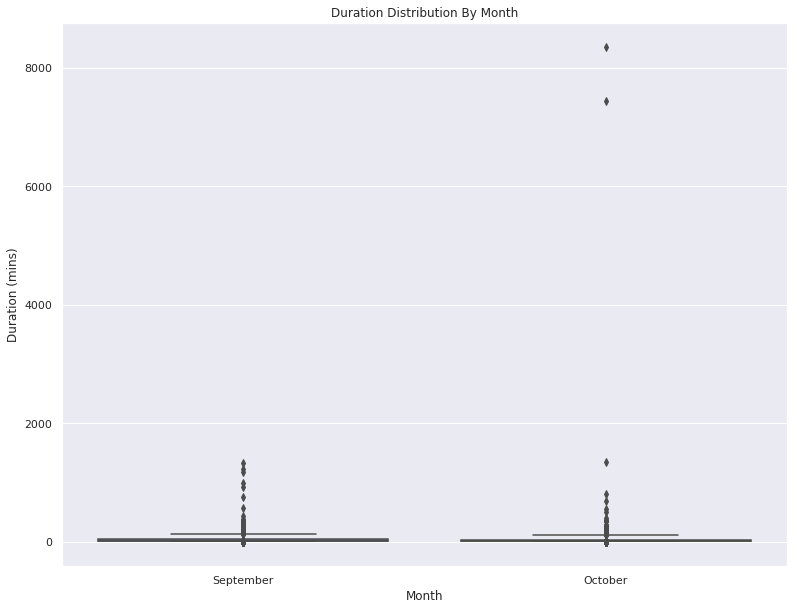

In [11]:
# Define whisker percentiles
whis_pc = [2.5, 97.5]


# Box plot of duration minutes, segmented by start month
fig = plt.figure(figsize=(13,10))
ax1 = fig.add_subplot(111)

sns.boxplot(x="start_month", y="duration_mins", data=all_data, ax  = ax1, whis = whis_pc)
ax1.set_title('Duration Distribution By Month')
ax1.set_xlabel('Month')
ax1.set_ylabel('Duration (mins)')

plt.show()

Given the huge outliers, it makes sense to filter them out of the data, so they don't skew out visualisation of the distribution, or let them influence any susceptible statistics such as the mean or range. Using September as a basis for what is 'normal', we can define a maximum value over which values are ignored. We can also apply this to all_data.

In [12]:
# Select the threshold as 50% above the maximum in September. 
duration_filter = max(sept_data.loc[:, 'duration_mins'])*1.5
# October data filtered
oct_data = oct_data[oct_data.loc[:, 'duration_mins'] < duration_filter]

# all_data filtered

all_data = all_data[all_data.loc[:, 'duration_mins'] < duration_filter]

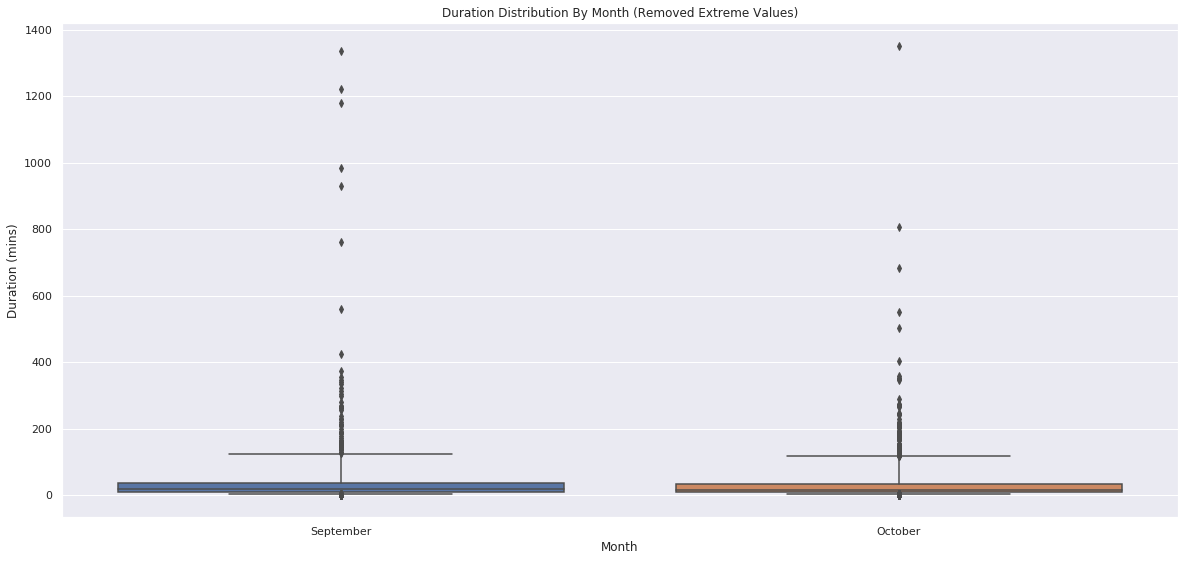

In [13]:
# Recreate box plot without outliers
fig = plt.figure(figsize=(20,20))
ax1 = fig.add_subplot(211)

sns.boxplot(x="start_month", y="duration_mins", data=all_data, ax  = ax1, whis = whis_pc)
ax1.set_title('Duration Distribution By Month (Removed Extreme Values)')
ax1.set_xlabel('Month')
ax1.set_ylabel('Duration (mins)')

plt.show()

Although the boxplot is still not clean to look at, it shows the 'unreasonable' values have been removed, and displays that there are plenty of people who take bikes for a lengthy period of time. 

Now let us zoom in on a range characterised by the percentiles.  

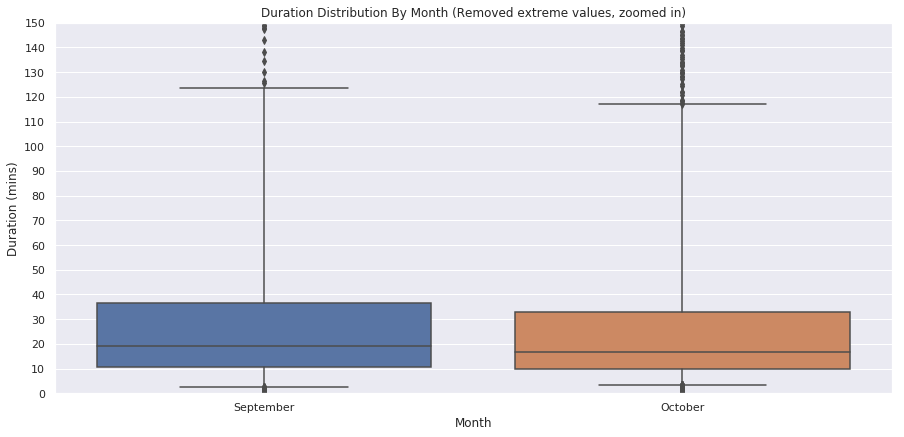

In [14]:
# Get upper range of the whisker, and use this to set ylim. Upper range based on whisker percentiles set previously
upper_range = np.percentile(all_data.loc[:, 'duration_mins'], whis_pc[1])

fig = plt.figure(figsize=(15,15))
ax1 = fig.add_subplot(211)

# Plot, label axes, set style
sns.boxplot(x="start_month", y="duration_mins", data=all_data, ax  = ax1, whis = whis_pc)
ax1.set_title('Duration Distribution By Month (Removed extreme values, zoomed in)')
ax1.set_xlabel('Month')
ax1.set_ylabel('Duration (mins)')
ax1.set_yticks(range(0,int(upper_range*1.5), 10))
ax1.set_ylim(0,150)

plt.show()

It seems as though in October people travel for slightly shorter distances than they did in September, with the whole boxplot having been shifted down. 

#### Summary Statistics by Day of Week, and Month

##### Calculation

In [15]:
# Calculate various summary statistics, grouped by Month and day of the week. 
all_duration_grouped = all_data.groupby(['start_month', 'start_day'])
all_duration_agged = all_duration_grouped.agg({'duration_mins':[sum, np.mean, np.median, np.std], 'count':'count'})

# Rename levels of the columns, and the index names of the rows. 
# sorted(), as levels of multi-index in alphabetical order. 

all_duration_agged.columns.set_levels(['Duration (Mins)', 'Count'], level = 0, inplace = True)
all_duration_agged.columns.set_levels(sorted(['Sum', 'Mean', 'Median', 'Standard Deviation', 'Count']), level = 1, inplace = True)
all_duration_agged.index.names = ['Start Month', 'Start Day']

# round all results to 2 decimal places
all_duration_agged = all_duration_agged.round(2)

##### Presentation of Dataframe

In [16]:
# Style datafrane to present

# Set the desired colour map, and font size, table width, and font colour. 
colormap = sns.diverging_palette(h_neg=10, h_pos=240, as_cmap=True)
font_size = '11pt'
max_width = '80px'
color = 'black'

# Apply gradient highlighting to dataframe, and add properties above. 
all_duration_agged_styled = all_duration_agged.style.background_gradient(colormap)
all_duration_agged_styled = all_duration_agged_styled.set_properties(**{'max-width': max_width, 
                                                                        'font-size': font_size, 
                                                                        'color':color})
all_duration_agged_styled

We can see the mean journey time on a Tuesday in October was 23 minutes, and the median time was 15 minutes, suggesting duration has a right skew on this day, and looking over the table we can see the suggestion duration is right-skewed in general (i.e. we do not need to stratify to see this). Of course this makes sense as there is a lower bound (0) on the time a bike is hired, but there is no upper bound. 

Now see how average times have changed from month-to-month when averaging by day

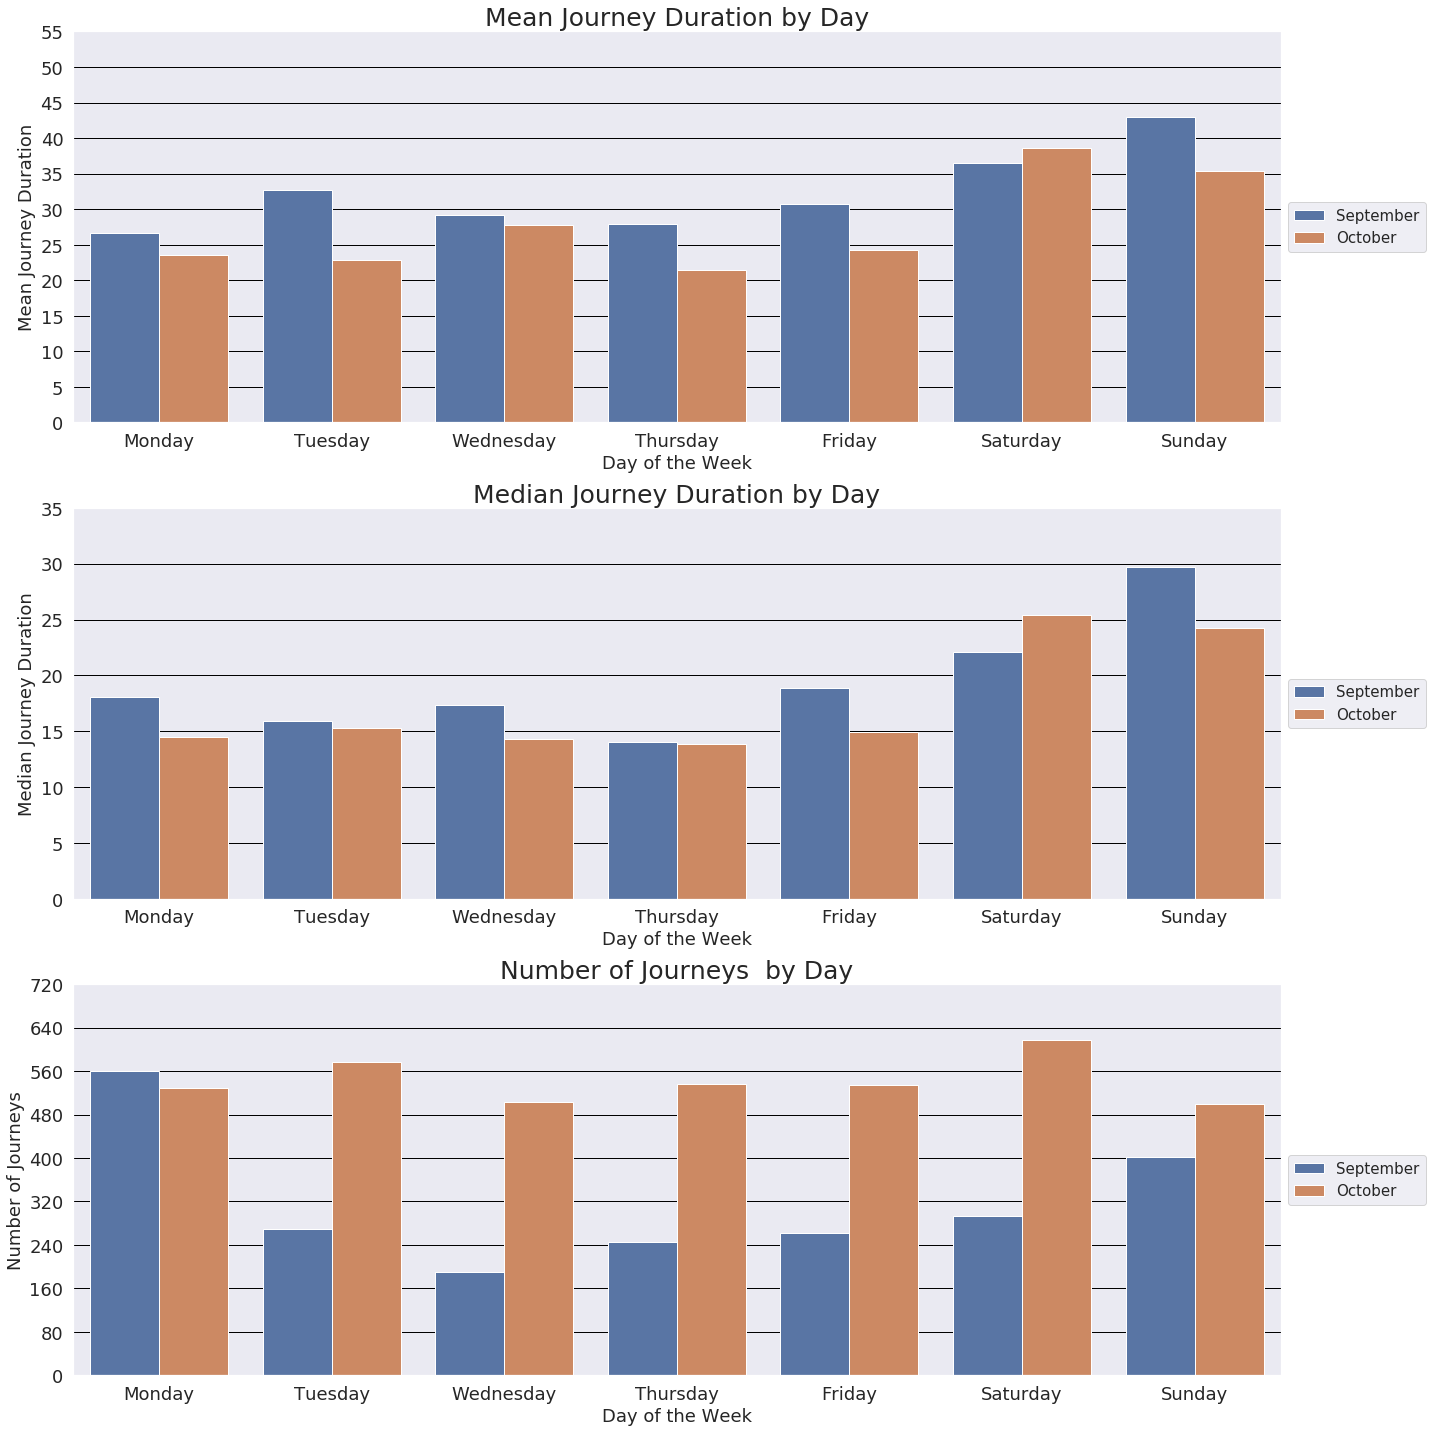

In [17]:
# Get max mean and median, to use to set ylim
max_mean = max(all_duration_agged.loc[:, 'Duration (Mins)'].loc[:, 'Mean'])
max_med = max(all_duration_agged.loc[:, 'Duration (Mins)'].loc[:, 'Median'])
max_cnt = max(all_duration_agged.loc[:, 'Count'].loc[:, 'Count'])

# Set parameters for figure font sizes etc. to be equal

figsize_input = (20,20)
title_size = 25
x_lab_size = 18
x_tick_size = 18
y_lab_size = 18
y_tick_size = 18
legend_size = 15

# legend_loc and bbox_loc used to put legend outside of figure. 
legend_loc = 'center left'
bbox_loc = (1,0.5)      #  (horizontal, vertical)
grid_color = 'black'
grid_line = '-'
grid_axes = 'y'  
meanmed_padding = 0.22*max_mean
cnt_padding = 0.25*max_cnt

# Ceiling to nearest 10, then adding padding to have space at top of graph

max_mean = nearest_ceil(max_mean) + meanmed_padding
max_med = nearest_ceil(max_med)  + meanmed_padding
max_cnt = nearest_ceil(max_cnt) + cnt_padding

# Steps of y-ticks for each plot

mean_steps = nearest_ceil(max_mean, 100)/20
med_steps =  nearest_ceil(max_med,100)/20
cnt_steps = nearest_ceil(max_cnt,100)/10

# Start figure and subplots
fig = plt.figure(figsize=figsize_input)
ax1 = fig.add_subplot(311)
ax2 = fig.add_subplot(312)
ax3 = fig.add_subplot(313)

# Plot onto axes
# Lambda function to get journey count
sns.barplot(x = 'start_day', y = 'duration_mins', hue='start_month', data=all_data, ax= ax1, estimator = np.mean, ci = None)
sns.barplot(x = 'start_day', y = 'duration_mins', hue='start_month', data=all_data, ax= ax2, estimator = np.median, ci=None)
sns.barplot(x = 'start_day', y = 'duration_mins', hue='start_month', data=all_data, ax= ax3, estimator = lambda x: len(x))


# Formatting first subplot with parameters above

ax1.set_title('Mean Journey Duration by Day', fontsize = title_size)
ax1.set_xlabel('Day of the Week', fontsize = x_lab_size)
ax1.set_ylabel('Mean Journey Duration', fontsize = y_lab_size)
ax1.set_yticks(np.arange(0,max_mean, mean_steps))
ax1.tick_params(axis='x', which='major', labelsize = x_tick_size)
ax1.tick_params(axis='y', which='major', labelsize = y_tick_size)
ax1.grid(color='black', linestyle = '-', linewidth = 1, axis = grid_axes)
ax1.legend(loc = legend_loc, bbox_to_anchor=bbox_loc, prop = {'size': legend_size})

# Formatting second subplot with parameters above

ax2.set_title('Median Journey Duration by Day', fontsize = title_size)
ax2.set_xlabel('Day of the Week', fontsize = x_lab_size)
ax2.set_ylabel('Median Journey Duration', fontsize = y_lab_size)
ax2.set_yticks(np.arange(0,max_med, med_steps))
ax2.tick_params(axis='x', which='major', labelsize=x_tick_size)
ax2.tick_params(axis='y', which='major', labelsize=y_tick_size)
ax2.grid(color='black', linestyle = '-', linewidth = 1, axis = grid_axes)
ax2.legend(loc = legend_loc, bbox_to_anchor=bbox_loc, prop = {'size': legend_size})


# Formatting third subplot with parameters above

ax3.set_title('Number of Journeys  by Day', fontsize = title_size)
ax3.set_xlabel('Day of the Week', fontsize = x_lab_size)
ax3.set_ylabel('Number of Journeys', fontsize = y_lab_size)
ax3.set_yticks(np.arange(0,max_cnt, cnt_steps))
ax3.tick_params(axis='x', which='major', labelsize=x_tick_size)
ax3.tick_params(axis='y', which='major', labelsize=y_tick_size)
ax3.grid(color='black', linestyle = '-', linewidth = 1, axis = grid_axes)
ax3.legend(loc = legend_loc, bbox_to_anchor=bbox_loc, prop = {'size': legend_size})

plt.tight_layout()
plt.show()


With regards to the mean and median journey times, they have dropped from September to October for each day except for Saturday. However this change is small, and is easily offset by the increase in total journeys per day. We also see that, as expected, average (mean and median) journey times are highest on weekends, when people have most leisure time. Just-eat could perhaps profit by implementing price discrimination, whereby they charge slightly more on the weekend - depending on price elasticity of demand. 

##### Journey Distance

We will now conduct the same analysis, but looking at the distance travelled.

Just as above, let us start with a boxplot of the distance travelled. Note that distance is in miles, and is either an L1/L2 distance, based on the argument to the $\texttt{haversine}$ function above. 

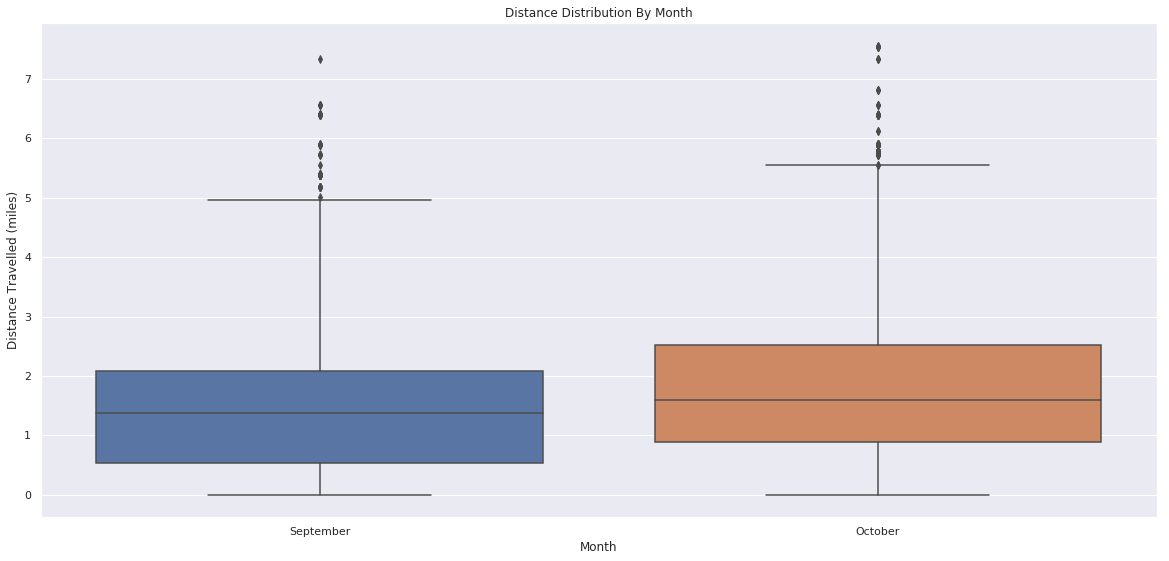

In [18]:
# Define whisker percentiles
whis_pc = [2.5, 97.5]

fig = plt.figure(figsize=(20,20))
ax1 = fig.add_subplot(211)

sns.boxplot(x="start_month", y="distance", data=all_data, ax  = ax1, whis = whis_pc)
ax1.set_title('Distance Distribution By Month')
ax1.set_xlabel('Month')
ax1.set_ylabel('Distance Travelled (miles)')

plt.show()

Though the change is slight, it appears people are travelling a greater distance (on average) in October compared to September, based on the boxplot being shifted upwards. It appears as the most someone has travelled between stations is just over 7 miles, indicating the greatest distance between any 2 available stations in the data is 7 miles (assuming 1 journey has in each combination of start and end stations). 

As previously, let us see how this measure varies by day, and month

In [19]:
# Perform aggregation of distance on month and day
all_distance_grouped = all_data.groupby(['start_month', 'start_day'])
all_distance_agged = all_distance_grouped.agg({'distance':[sum, np.mean, np.median, np.std]})

# Rename levels of columns, and index names of rows
all_distance_agged.columns.set_levels(['Distance'], level = 0, inplace=True)
all_distance_agged.columns.set_levels(['Sum', 'Mean', 'Median', 'Standard Deviation'], level = 1, inplace=True)
all_distance_agged.index.names = ['Start Month', 'Start Day']

# Round results to 2 decimal places
all_distance_agged = all_distance_agged.round(2)

In [20]:
# Style datafrane to present

# select colormap, fontsize for presentation, width of dataframe, and font colour. 
colormap = sns.diverging_palette(h_neg=10, h_pos=240, as_cmap=True)
font_size = '11pt'
max_width = '80px'
color = 'black'

# Style the dataframe with a gradient style, based on the colormap.
# Gradient style means the colours gradually change as you go from one end of values to the other
all_distance_agged_styled = all_distance_agged.style.background_gradient(colormap)
# Add the other parameters as kwargs. 
all_distance_agged_styled = all_distance_agged_styled.set_properties(**{'max-width': max_width, 
                                                                        'font-size': font_size, 
                                                                        'color':color})
all_distance_agged_styled

The average distance of journey's starting on a Tuesday was 1.78 miles. As before, the distribution is right-skewed due to a 0 lower bound, and distances have increased in October as seen in the boxplot. It also appears as if the longest journeys are on Mondays. 

Now, plot mean and median distance travelled by day and month. 

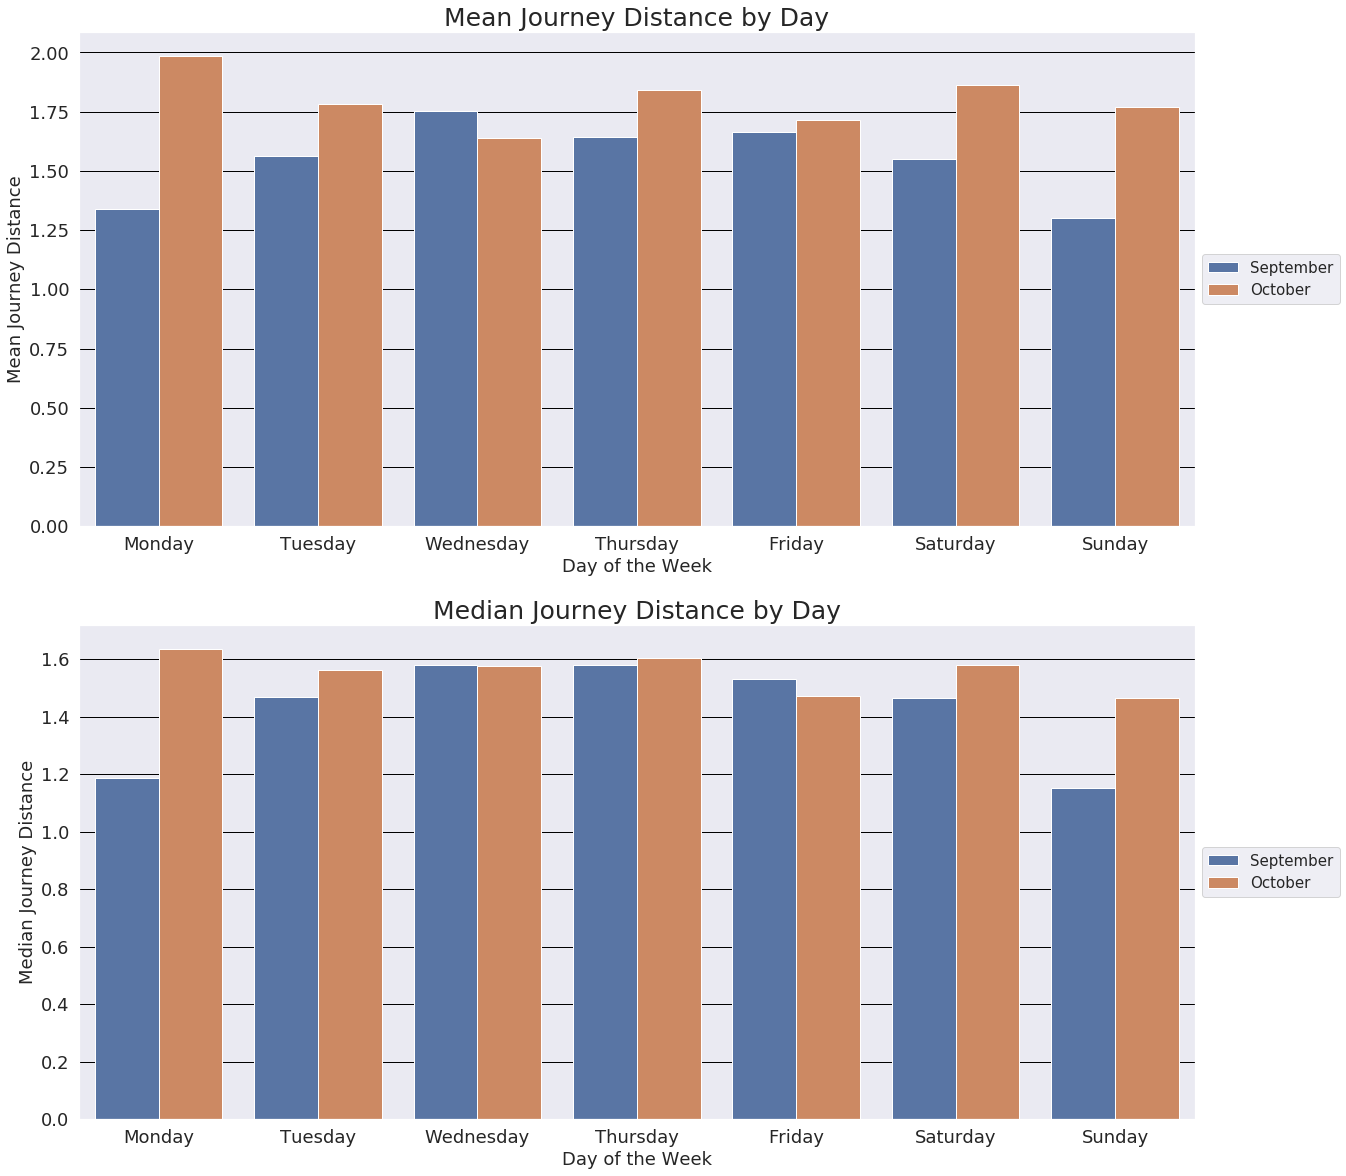

In [21]:
# Set parameters for figure font sizes etc. to be equal

figsize_input = (20,20)
title_size = 25
x_lab_size = 18
x_tick_size = 18
y_lab_size = 18
y_tick_size = 18
legend_size = 15
legend_loc = 'center left'
bbox_loc = (1,0.5)      #  (horizontal, vertical)
grid_color = 'black'
grid_line = '-'
grid_axes = 'y'  

# Ceiling to nearest 10, then adding padding to have space at top of graph



# Start figure and subplots
fig = plt.figure(figsize=figsize_input)
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

# Plot onto axes

sns.barplot(x = 'start_day', y = 'distance', hue='start_month', data=all_data, ax= ax1, estimator = np.mean, ci = None)
sns.barplot(x = 'start_day', y = 'distance', hue='start_month', data=all_data, ax= ax2, estimator = np.median, ci = None)


# Formatting first subplot with parameters above

ax1.set_title('Mean Journey Distance by Day', fontsize = title_size)
ax1.set_xlabel('Day of the Week', fontsize = x_lab_size)
ax1.set_ylabel('Mean Journey Distance', fontsize = y_lab_size)
ax1.tick_params(axis='x', which='major', labelsize = x_tick_size)
ax1.tick_params(axis='y', which='major', labelsize = y_tick_size)
ax1.grid(color='black', linestyle = '-', linewidth = 1, axis = grid_axes)
ax1.legend(loc = legend_loc, bbox_to_anchor=bbox_loc, prop = {'size': legend_size})

# Formatting first subplot with parameters above

ax2.set_title('Median Journey Distance by Day', fontsize = title_size)
ax2.set_xlabel('Day of the Week', fontsize = x_lab_size)
ax2.set_ylabel('Median Journey Distance', fontsize = y_lab_size)
ax2.tick_params(axis='x', which='major', labelsize=x_tick_size)
ax2.tick_params(axis='y', which='major', labelsize=y_tick_size)
ax2.grid(color='black', linestyle = '-', linewidth = 1, axis = grid_axes)
ax2.legend(loc = legend_loc, bbox_to_anchor=bbox_loc, prop = {'size': legend_size})



Overall, both mean and median distances have increased from September to October, with the greatest change coming on Mondays and Sundays. 

### Stations

We removed all commonality at the beginning, with the name_and_desc issue, so we can continue freely here. 

Firstly, we find the number of stations. Each starting station is also an ending station, so finding the number of starting stations is sufficient

In [22]:
# Set cannot have duplicate values, so use it to get distincts
sept_set = set(sept_data.loc[:, 'start_name_and_desc'])
oct_set = set(oct_data.loc[:, 'start_name_and_desc'])
all_set = set(all_data.loc[:, 'start_name_and_desc'])

# Get length of unique, i.e. number of stations. 
sept_unique = len(sept_set)
oct_unique = len(oct_set)
all_unique = len(all_set)

# Print results based on above information. 
print(f"There are {sept_unique} different stations in September, "+
      f"{oct_unique} different stations in October, and {all_unique} different "+ 
      f"stations across both months")


There are 26 different stations in September, 31 different stations in October, and 33 different stations across both months


This suggests there were stations used in October that were not used in September (clearly), and also that some stations were used in September that were not used in October. Consider the set of starting locations in September as S, and in October as O, with their union being all the starting stations, hence the sample space $\Omega$. We want the set of locations in September and not in October, and the set of locations in October and not September

$
\begin{align}
S &\cap O^C \\
O &\cap S^C
\end{align}
$

We know from set theory that $O^C = \Omega \setminus O$, with the same applying to September, hence get the following:

In [23]:
not_sept = all_set.difference(sept_set)
not_oct = all_set.difference(oct_set)

sept_not_oct = sept_set.intersection(not_oct)
oct_not_sept = oct_set.intersection(not_sept)

print(f" The set of locations in September but not October is {sept_not_oct}\n")
print(f" The set of locations in October but not September is {oct_not_sept}")

 The set of locations in September but not October is {'Depot, Depot', 'Launch Day Event, The Meadows'}

 The set of locations in October but not September is {'Waitrose, Comely Bank, Fettes Avenue', 'Leith Links, Corner of Vanburgh Place and Lochend Road', 'Castle Street, Near Rose Street', 'Ocean Terminal, Debenhams / Puregym entrance', 'Riego Street, Riego Street on junction with East Fountainbridge', "Shrubhill, Sainsbury's Leith Walk", 'Bruntsfield, Corner of Bruntsfield Terrace and Bruntsfield Place'}


#### Starting Stations

Let us examine the most frequently departed from stations in the dataset, and if that has changed by month. We begin by aggregating, so the bar chart is sorted on October's values. Then we plot the barchart

In [24]:
# Use group by object to sort barplot by October journey count

# Group by object creation and aggregation
start_group_obj = all_data.groupby(['start_month', 'start_name_and_desc'])
start_group_agg = start_group_obj.agg({'count':'sum'})
start_group_agg.reset_index(inplace=True)

# Sort by month first, then count, descending (so we get October values to order by). 
start_group_agg.sort_values(['start_month', 'count'], ascending=False, inplace=True)


# unique() maintains the order it finds duplicates in, so October counts are ordered. highest to lowest. 
start_plot_order = start_group_agg.loc[:, 'start_name_and_desc'].unique()

# Reverse so the graph increases from left to right
# Order highest to lowest, want to reverse to get lowest to highest
start_plot_order = start_plot_order[::-1]

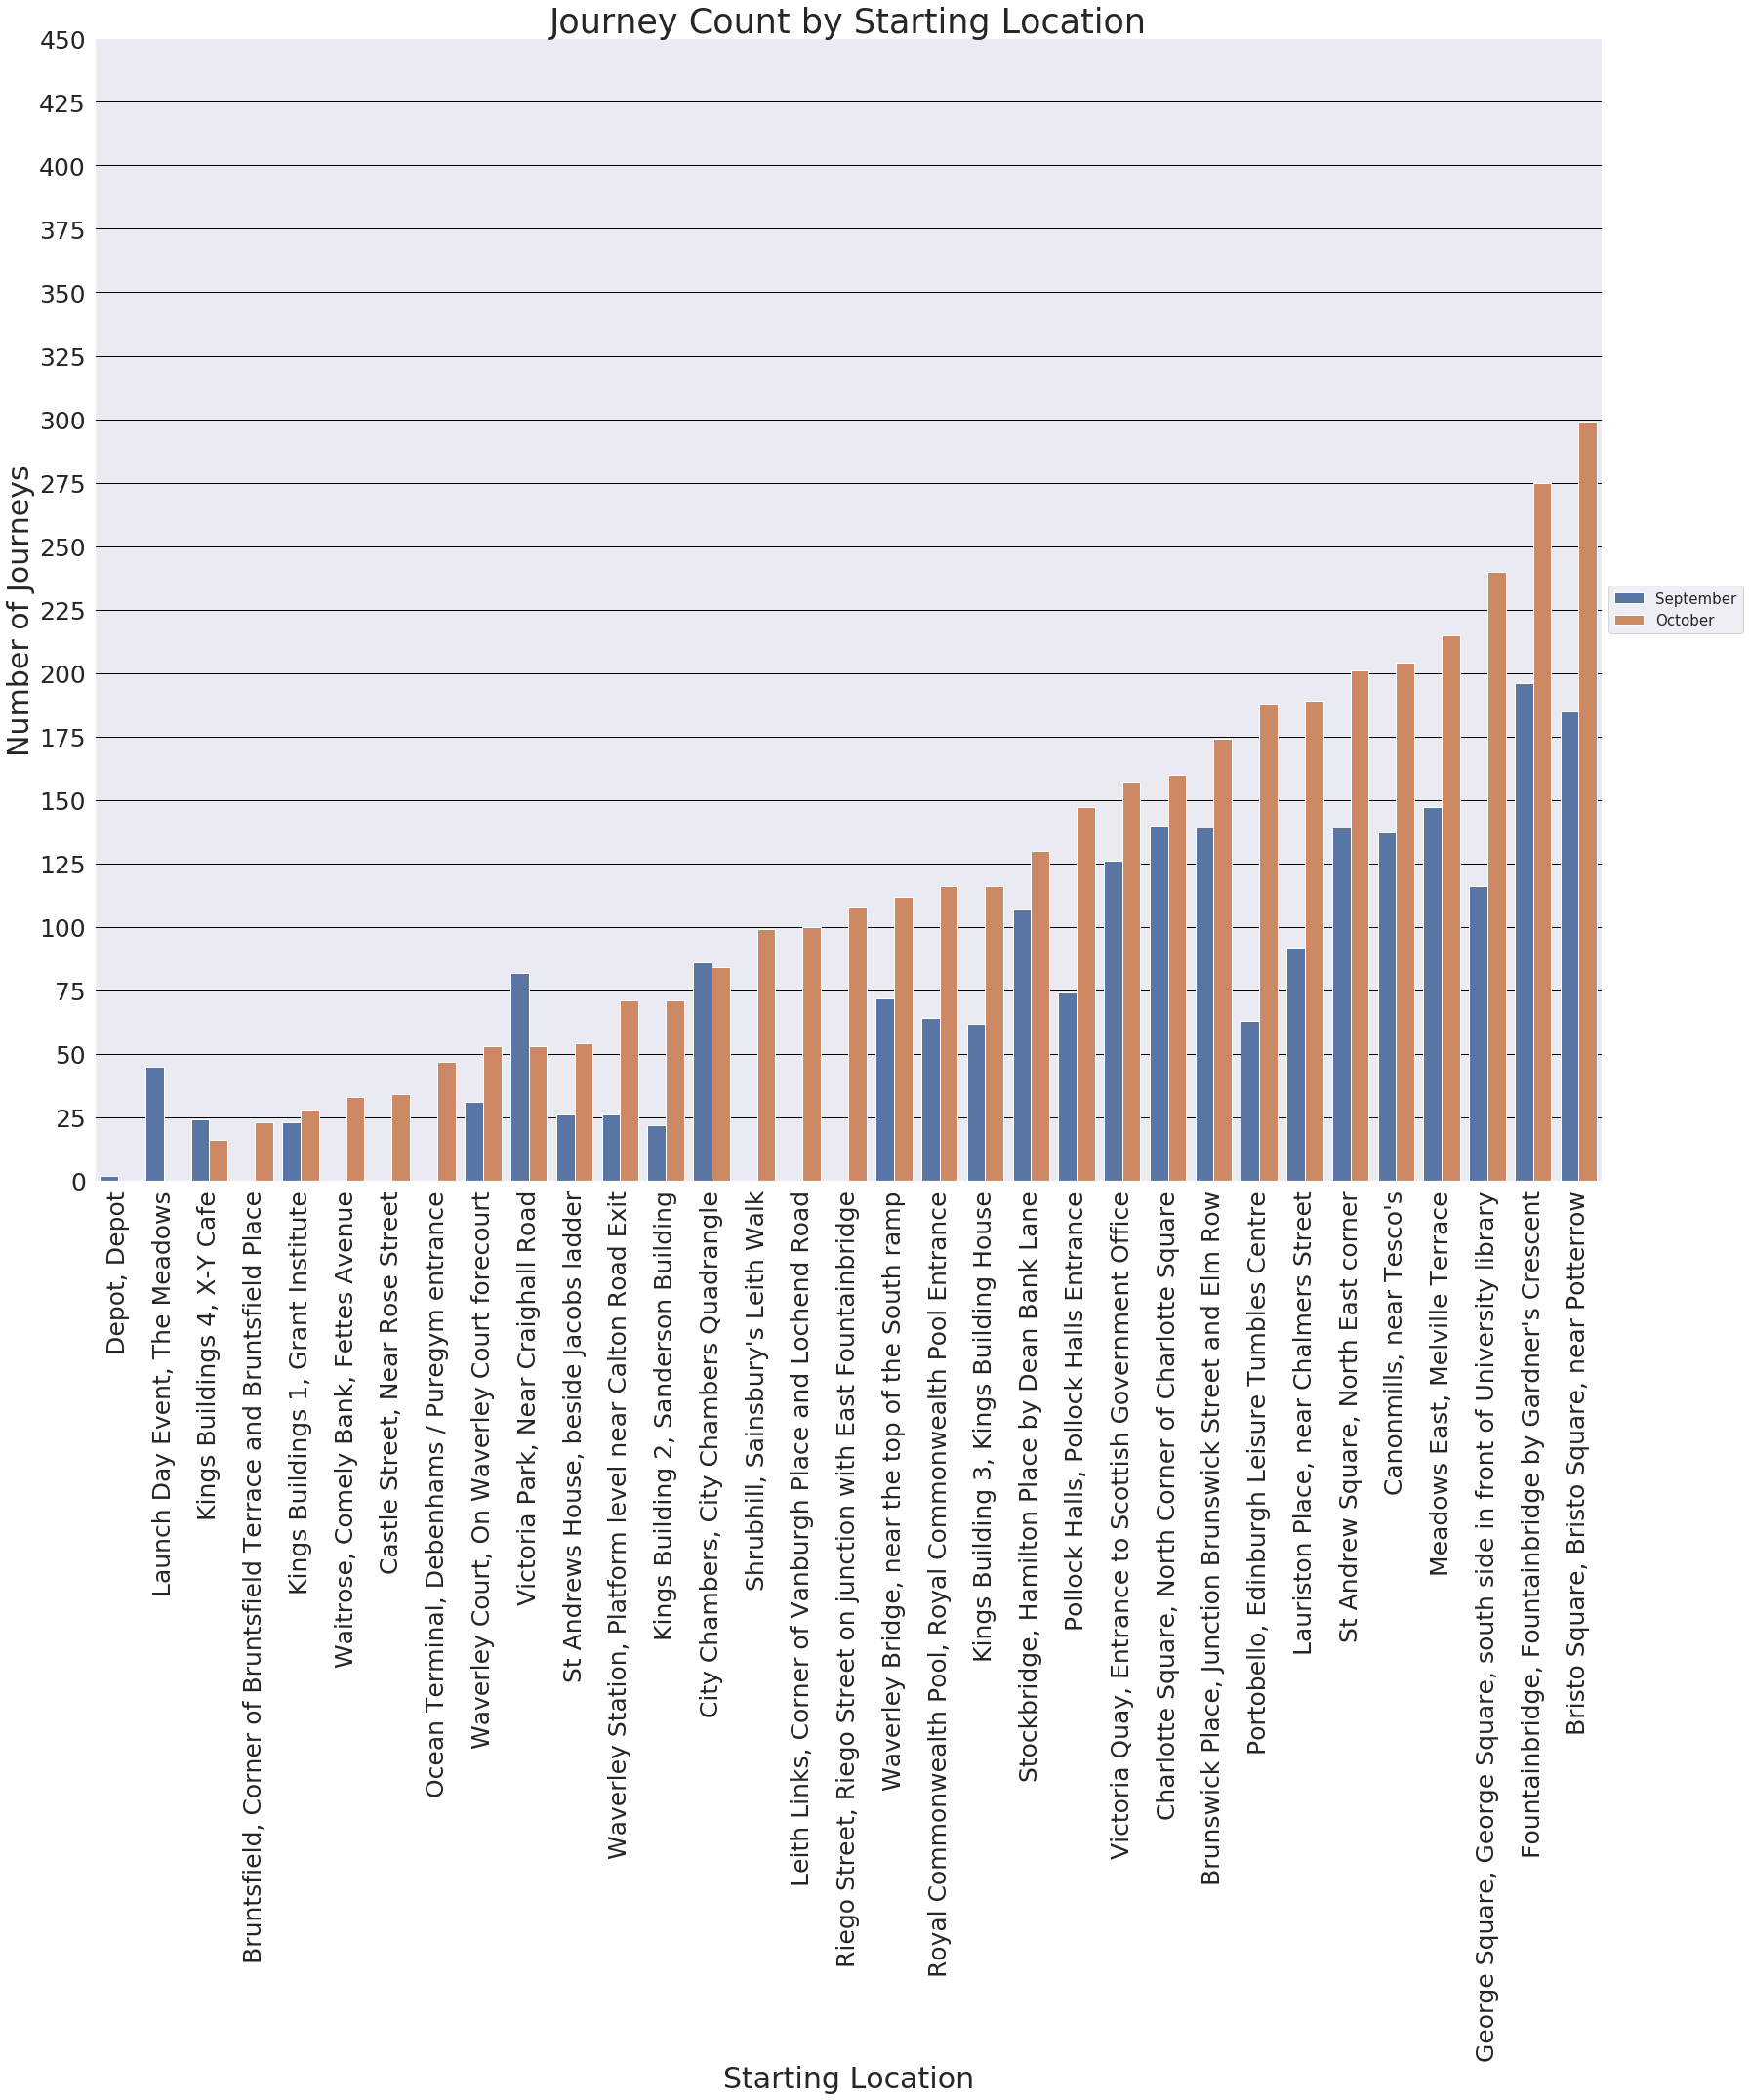

In [25]:
# Set parameters for figure font sizes etc
figsize_input = (25,30)
title_size = 35
x_lab_size = 30
x_tick_size = 25
y_lab_size = 30
y_tick_size = 25
legend_size = 15
legend_loc = 'center left'
bbox_loc = (1,0.5)      #  (horizontal, vertical)
grid_color = 'black'
grid_line = '-'
grid_axes = 'y'  


#max count for the stations, to get top of graph

max_cnt = max(start_group_agg.loc[:, 'count'])

# Ceiling to nearest 10, then adding padding to have space at top of graph

max_cnt = nearest_ceil(max_cnt) + cnt_padding

# Steps of y-ticks for each plot

cnt_steps = nearest_ceil(max_cnt,100)/20

# Construct figure container and axes to plot on

fig = plt.figure(figsize = figsize_input, )
ax1 = fig.add_subplot(111)

# Plot graph
sns.barplot(x = 'start_name_and_desc', y = 'count', hue = 'start_month', data = start_group_agg, 
            ax = ax1, order = start_plot_order)

# Set style

ax1.set_title('Journey Count by Starting Location', fontsize = title_size)
ax1.set_xlabel('Starting Location', fontsize = x_lab_size)
ax1.set_ylabel('Number of Journeys', fontsize = y_lab_size)
ax1.set_yticks(np.arange(0,max_cnt, cnt_steps))
ax1.tick_params(axis='x', which='major', labelsize = x_tick_size, labelrotation=90.0)
ax1.tick_params(axis='y', which='major', labelsize = y_tick_size)
ax1.grid(color='black', linestyle = '-', linewidth = 1, axis = grid_axes)
ax1.legend(loc = legend_loc, bbox_to_anchor=bbox_loc, prop = {'size': legend_size})

plt.tight_layout()
plt.show()


In [26]:
# Extract k most common stations, and print
k = 5

print(f"The {k} most common starting stations in October were {top_k(start_plot_order[::-1], k)}")

The 5 most common starting stations in October were "Bristo Square, Bristo Square, near Potterrow", "Fountainbridge, Fountainbridge by Gardner's Crescent", "George Square, George Square, south side in front of University library", "Meadows East, Melville Terrace", and "Canonmills, near Tesco's".


#### Ending Stations

In [27]:
# Use group by object to sort barplot by October journey count

# Group by object creation and aggregation
end_group_obj = all_data.groupby(['end_month', 'end_name_and_desc'])
end_group_agg = end_group_obj.agg({'count':'sum'})
end_group_agg.reset_index(inplace=True)

# Sort by count, descending (so we get October values to order by). 
end_group_agg.sort_values(['end_month', 'count'], ascending=False, inplace=True)

# Get unique station names as order, then reverse so the graph increases from left to right
end_plot_order = end_group_agg.loc[:, 'end_name_and_desc'].unique()
end_plot_order = end_plot_order[::-1]

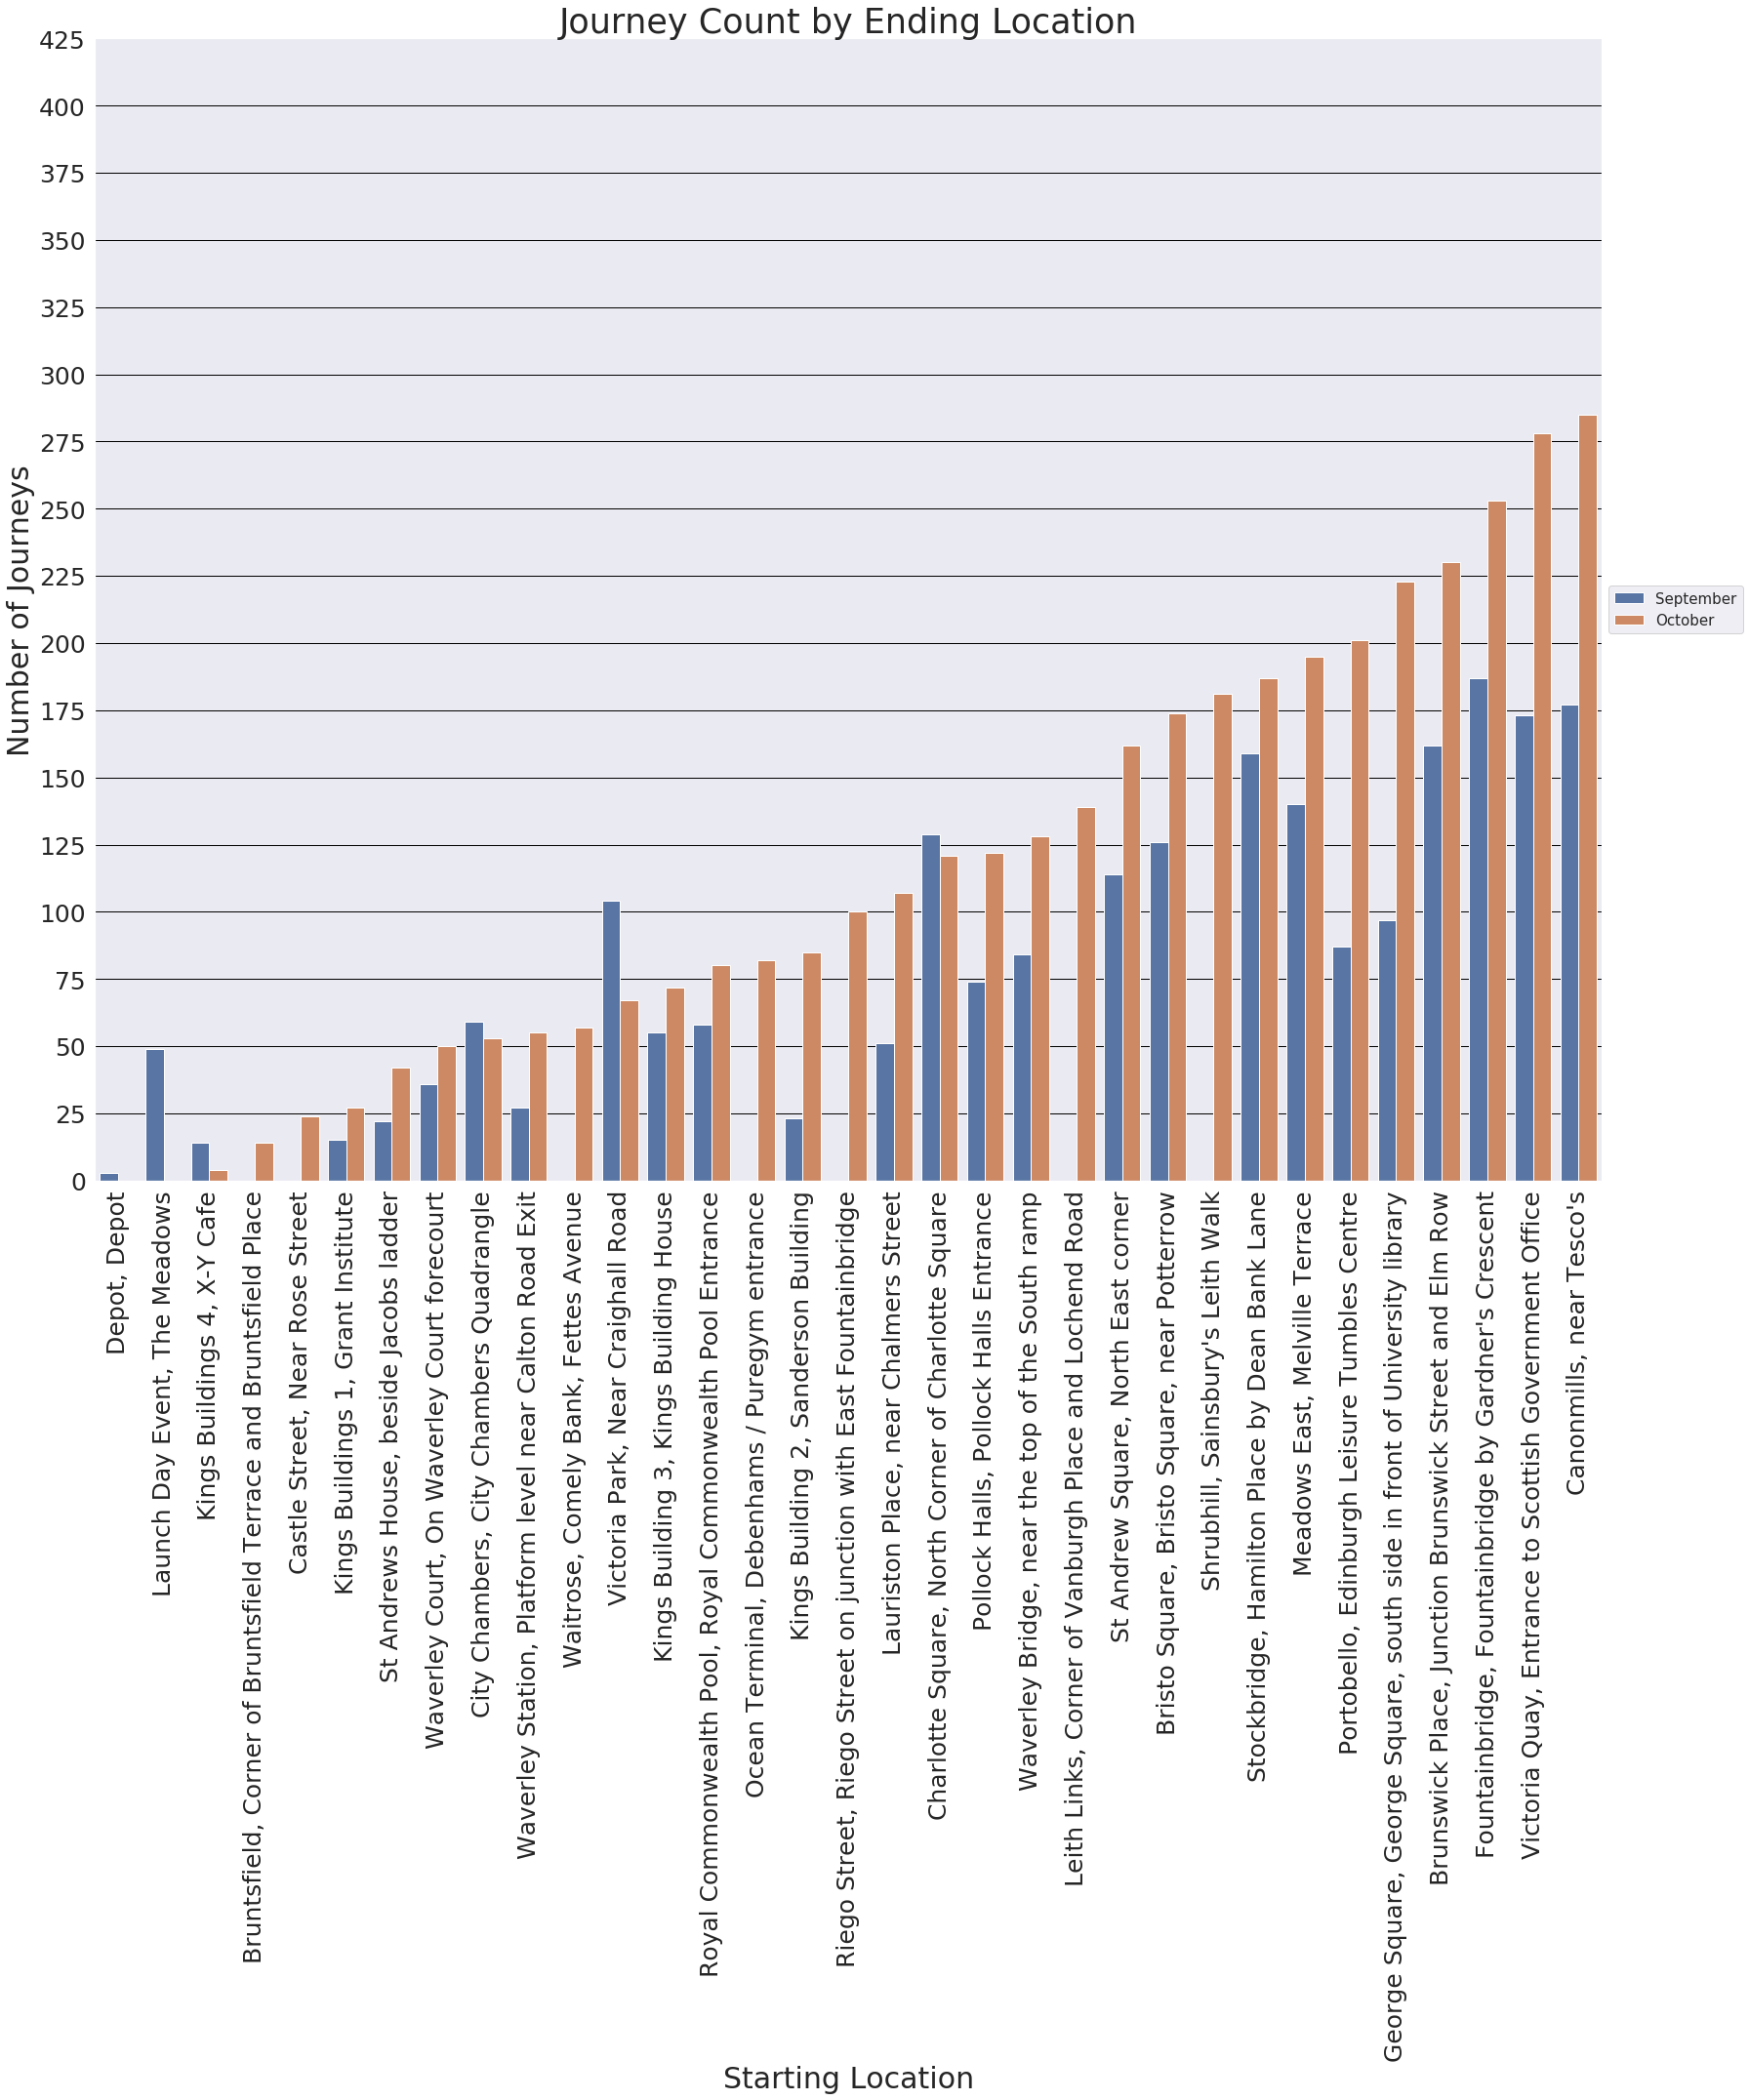

In [28]:

# Set parameters for figure font sizes etc
figsize_input = (25,30)
title_size = 35
x_lab_size = 30
x_tick_size = 25
y_lab_size = 30
y_tick_size = 25
legend_size = 15
legend_loc = 'center left'
bbox_loc = (1,0.5)      #  (horizontal, vertical)
grid_color = 'black'
grid_line = '-'
grid_axes = 'y'  


#max count for the stations, to get top of graph

max_cnt = max(end_group_agg.loc[:, 'count'])

# Ceiling to nearest 10, then adding padding to have space at top of graph

max_cnt = nearest_ceil(max_cnt) + cnt_padding

# Steps of y-ticks for each plot

cnt_steps = nearest_ceil(max_cnt,100)/20

# Construct figure container and axes to plot on

fig = plt.figure(figsize = figsize_input, )
ax1 = fig.add_subplot(111)

# Plot graph

sns.barplot(x = 'end_name_and_desc', y = 'count', hue='end_month', data=end_group_agg, 
            ax= ax1, order = end_plot_order)

# Set style

ax1.set_title('Journey Count by Ending Location', fontsize = title_size)
ax1.set_xlabel('Starting Location', fontsize = x_lab_size)
ax1.set_ylabel('Number of Journeys', fontsize = y_lab_size)
ax1.set_yticks(np.arange(0,max_cnt, cnt_steps))
ax1.tick_params(axis='x', which='major', labelsize = x_tick_size, labelrotation=90.0)
ax1.tick_params(axis='y', which='major', labelsize = y_tick_size)
ax1.grid(color='black', linestyle = '-', linewidth = 1, axis = grid_axes)
ax1.legend(loc = legend_loc, bbox_to_anchor=bbox_loc, prop = {'size': legend_size})

plt.tight_layout()
plt.show()


In [29]:
# Extract k most common stations, and print
k = 5

print(f"The {k} most common ending stations in October were {top_k(end_plot_order[::-1], k)}")


The 5 most common ending stations in October were "Canonmills, near Tesco's", "Victoria Quay, Entrance to Scottish Government Office", "Fountainbridge, Fountainbridge by Gardner's Crescent", "Brunswick Place, Junction Brunswick Street and Elm Row", and "George Square, George Square, south side in front of University library".


The ending stations are different to the starting stations, with Canonmills being the most frequently travelled to station, from 5th as a starting station. Bristo Square is the most departed from station, but people go there much less often, with it being the 10th most frequently arrived at station. 

### Times

Let us find out what time journeys most often start, and end. Naturally we begin with start times. We look at the time based on the hour journeys start and end. 

#### Starting Times

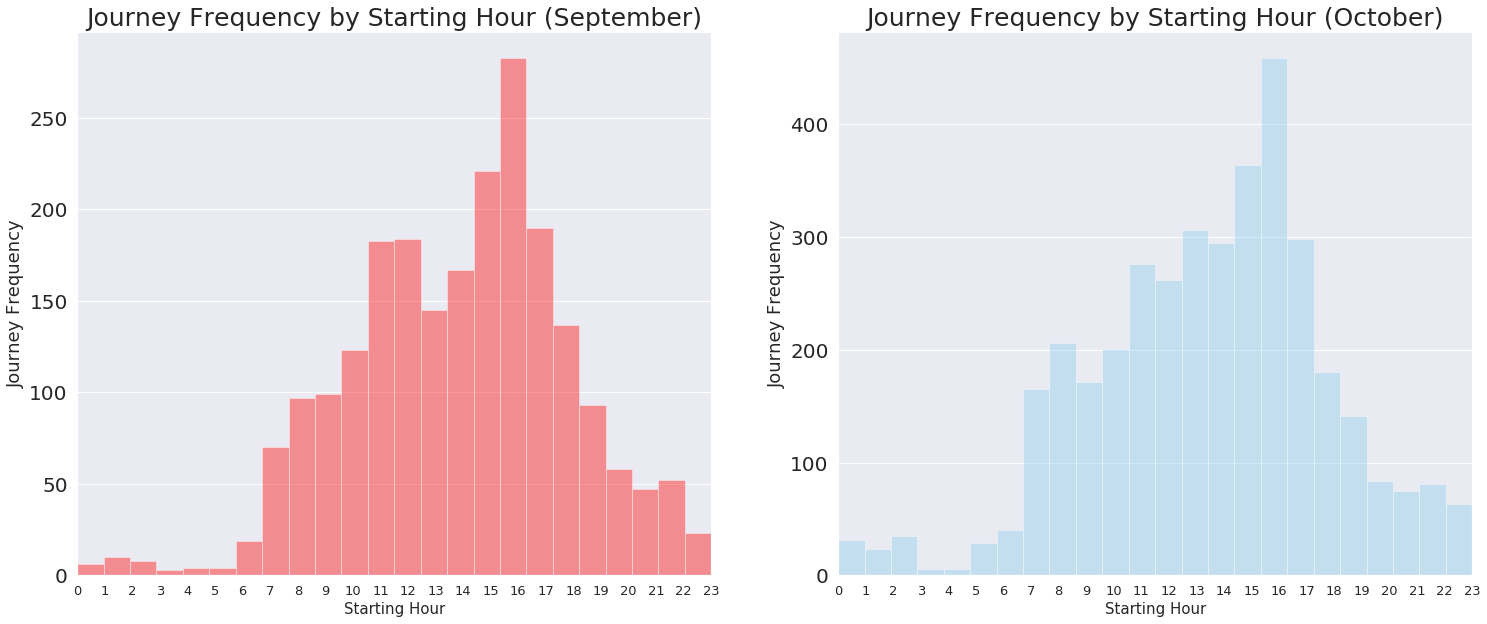

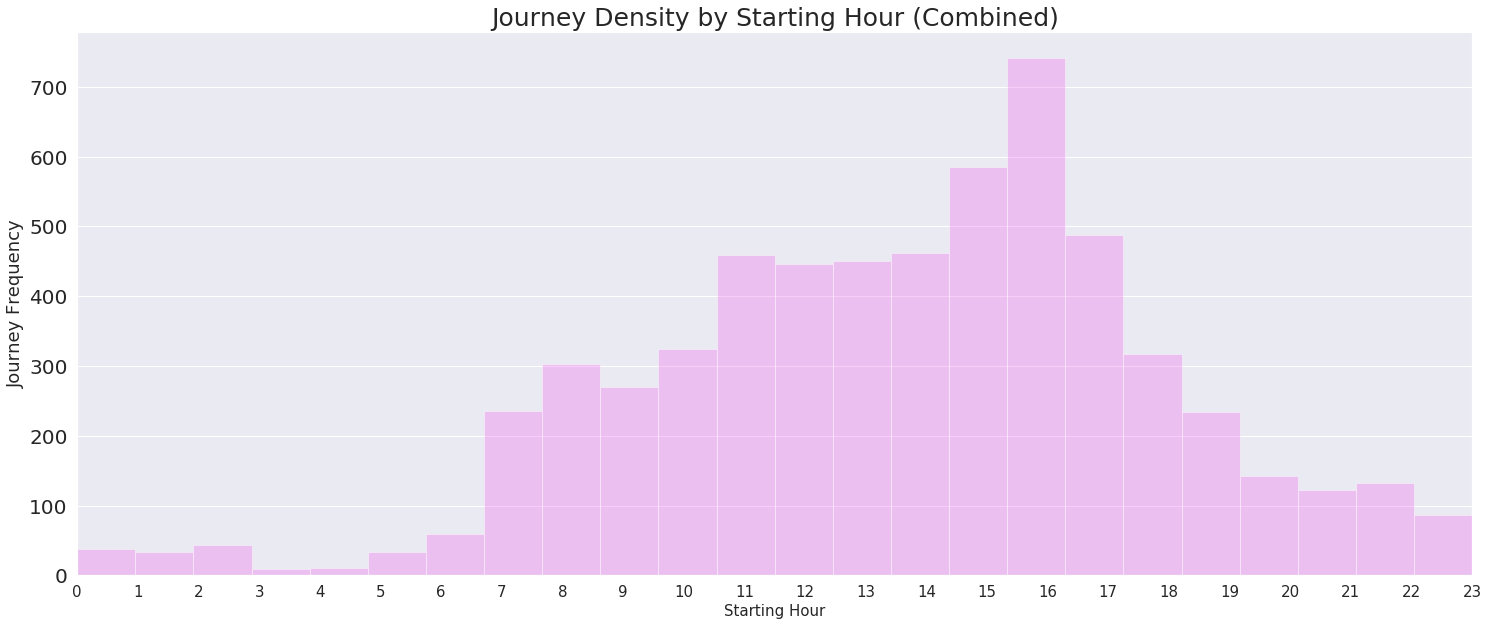

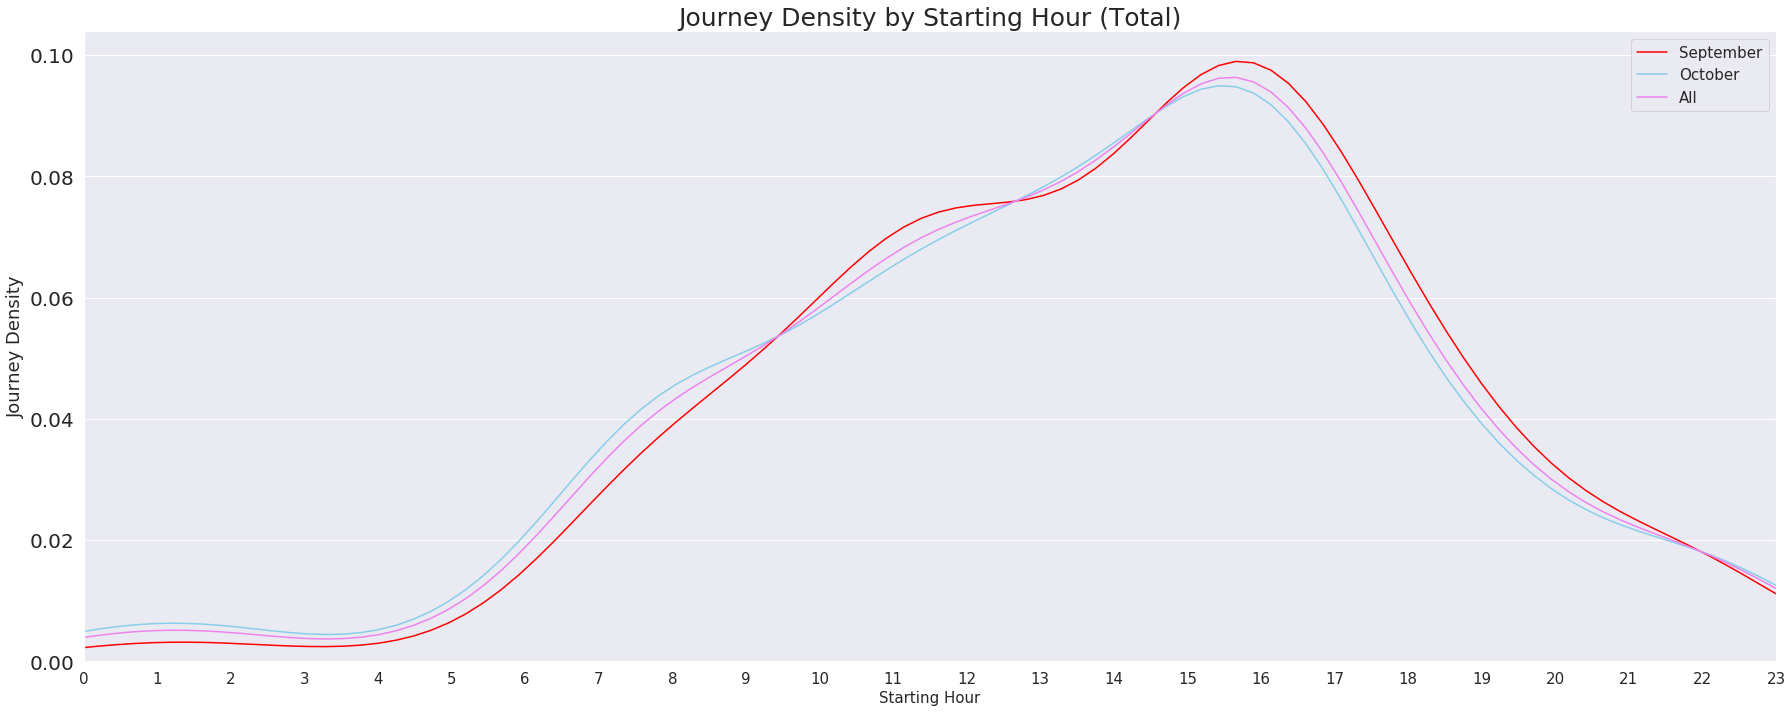

In [30]:
# Starting hours for both months, and overall. 
starting_hours_sept = sept_data.loc[:, 'start_hour']  
starting_hours_oct = oct_data.loc[:, 'start_hour']  
starting_hours_all = starting_hours_sept.append(starting_hours_oct)

# Set parameters for all graphs

figsize_input = (25,10)
xlim_input = (0,23)
xtick_list = range(0, 24, 1)

# Set parameters for side-by-side subplots
title_size_sbs = 25
x_lab_size_sbs = 15
x_tick_size_sbs = 13
y_lab_size_sbs = 18
y_tick_size_sbs = 20
grid_color_sbs = 'white'
grid_linestyle_sbs = '-'
grid_linewidth_sbs = 0
grid_axes_sbs = 'x'  

  
# Set parameters for vertically stacked plots

title_size_vs = 25
x_lab_size_vs = 15
x_tick_size_vs = 15
xtick_list_vs = range(1, 25, 1)
y_lab_size_vs = 18
y_tick_size_vs = 20
legend_size_vs = 15
legend_loc_vs = 'upper right'
grid_color_vs = 'black'
grid_linestyle_vs = '-'
grid_linewidth_vs = 0
grid_axes_vs = 'x'  




# Plot all graphs

# For months separately

fig1 = plt.figure(figsize = figsize_input)
ax1 = fig1.add_subplot(121)
ax2 = fig1.add_subplot(122)


sns.distplot(starting_hours_sept, bins=24, color='red', label = 'September', ax=ax1, kde=False)
sns.distplot(starting_hours_oct, bins=24, color='skyblue', label = 'October', ax=ax2, kde=False)

# For combined density plot
fig2 = plt.figure(figsize = figsize_input)
ax3 = fig2.add_subplot(111)

sns.distplot(starting_hours_all, bins=24, color='violet', ax=ax3, hist=True, kde = False)

# For combined distribution plot

fig3 = plt.figure(figsize = figsize_input)
ax4 = fig3.add_subplot(111)

# Use bw parameter to get a smoother density estimate

sns.distplot(starting_hours_sept, bins=24, color='red', label = 'September', ax=ax4, hist = False, kde_kws={'bw':1.2})
sns.distplot(starting_hours_oct, bins=24, color='skyblue', label = 'October', ax=ax4, hist=False, kde_kws={'bw':1.2})
sns.distplot(starting_hours_all, bins=24, color='violet', label = 'All', ax=ax4, hist=False, kde_kws={'bw':1.2})




# Style 

# ax1: September Plot

ax1.set_title('Journey Frequency by Starting Hour (September)', fontsize = title_size_sbs)
ax1.set_xlabel('Starting Hour', fontsize = x_lab_size_sbs)
ax1.set_ylabel('Journey Frequency', fontsize = y_lab_size_sbs)
ax1.set_xticks(xtick_list)
ax1.tick_params(axis='x', which='major', labelsize = x_tick_size_sbs)
ax1.tick_params(axis='y', which='major', labelsize = y_tick_size_sbs)
ax1.set_xlim(xlim_input)
ax1.grid(axis=grid_axes_sbs, color=grid_color_sbs, linestyle=grid_linestyle_sbs, linewidth=grid_linewidth_sbs)

# ax2: October Plot

ax2.set_title('Journey Frequency by Starting Hour (October)', fontsize = title_size_sbs)
ax2.set_xlabel('Starting Hour', fontsize = x_lab_size_sbs)
ax2.set_ylabel('Journey Frequency', fontsize = y_lab_size_sbs)
ax2.set_xticks(xtick_list)
ax2.tick_params(axis='x', which='major', labelsize = x_tick_size_sbs)
ax2.tick_params(axis='y', which='major', labelsize = y_tick_size_sbs)
ax2.set_xlim(xlim_input)
ax2.grid(axis=grid_axes_sbs, color=grid_color_sbs, linestyle=grid_linestyle_sbs, linewidth=grid_linewidth_sbs)


# ax3: Combined density plot of September and October

ax3.set_title('Journey Density by Starting Hour (Combined)', fontsize = title_size_vs)
ax3.set_xlabel('Starting Hour', fontsize = x_lab_size_vs)
ax3.set_ylabel('Journey Frequency', fontsize = y_lab_size_vs)
ax3.set_xticks(xtick_list)
ax3.tick_params(axis='x', which='major', labelsize = x_tick_size_vs)
ax3.tick_params(axis='y', which='major', labelsize = y_tick_size_vs)
ax3.set_xlim(xlim_input)
ax3.grid(axis=grid_axes_vs, color=grid_color_vs, linestyle=grid_linestyle_vs, linewidth=grid_linewidth_vs)

# ax4: Histogram and density plot for all 

ax4.set_title('Journey Density by Starting Hour (Total)', fontsize = title_size_vs)
ax4.set_xlabel('Starting Hour', fontsize = x_lab_size_vs)
ax4.set_ylabel('Journey Density', fontsize = y_lab_size_vs)
ax4.set_xticks(xtick_list)
ax4.tick_params(axis='x', which='major', labelsize = x_tick_size_vs)
ax4.tick_params(axis='y', which='major', labelsize = y_tick_size_vs)
ax4.set_xlim(xlim_input)
ax4.grid(axis=grid_axes_vs, color=grid_color_vs, linestyle=grid_linestyle_vs, linewidth=grid_linewidth_vs)
ax4.legend(loc = legend_loc_vs, prop = {'size': legend_size_vs})




plt.tight_layout()
plt.show()



We can see the most common starting time is the 16th hour in both September and October from the histogram, with the density estimates putting the time at the late 15th hour. 

#### Ending Times

Exactly the same principles apply as above

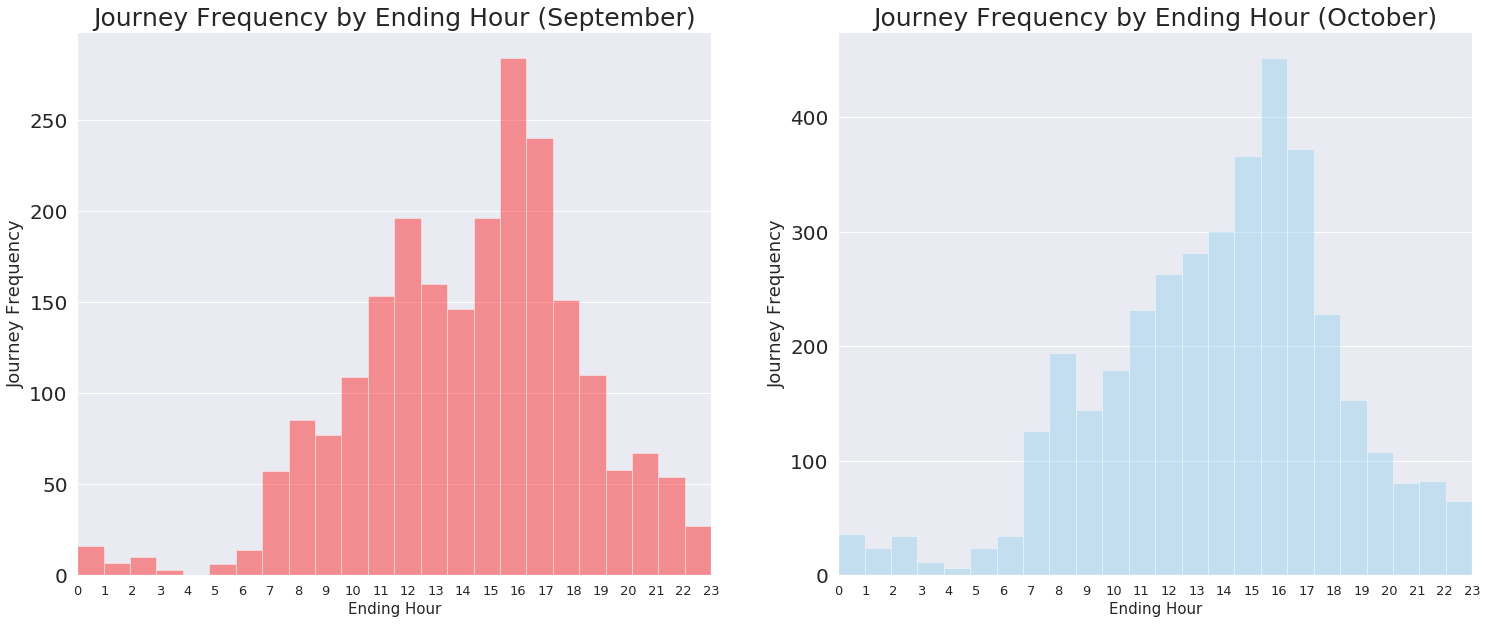

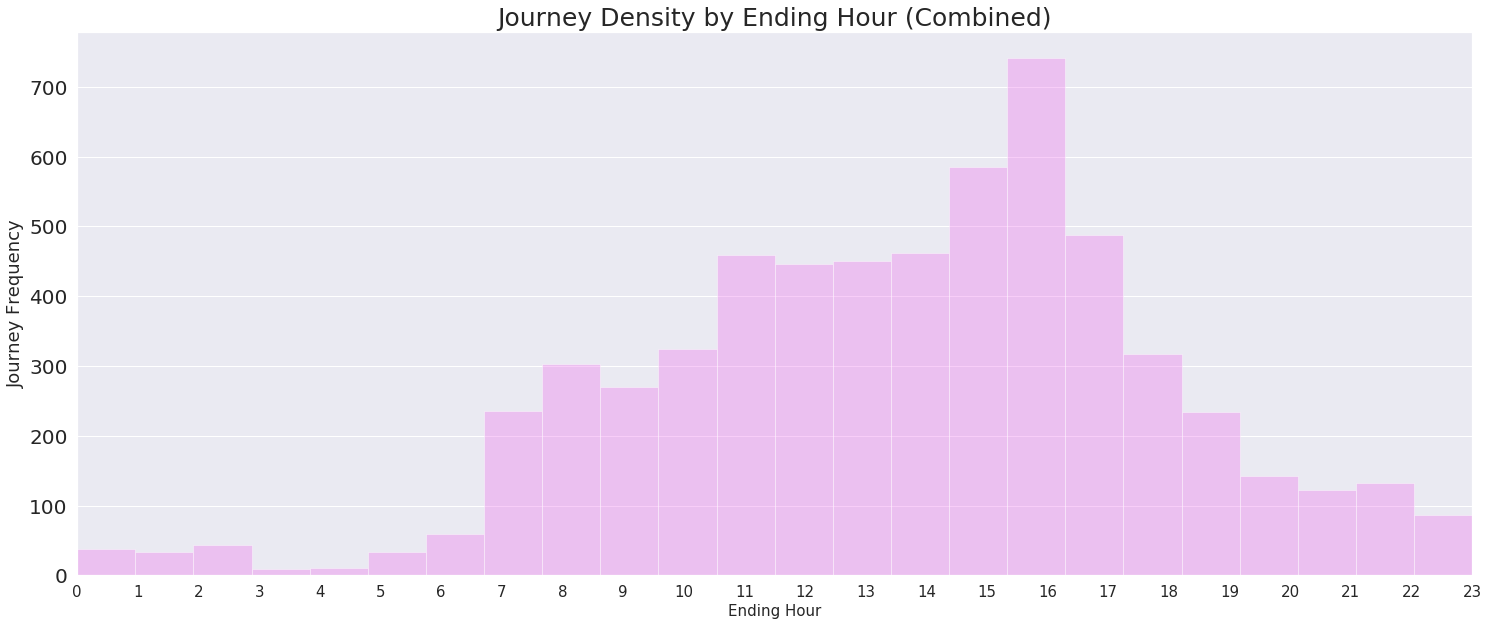

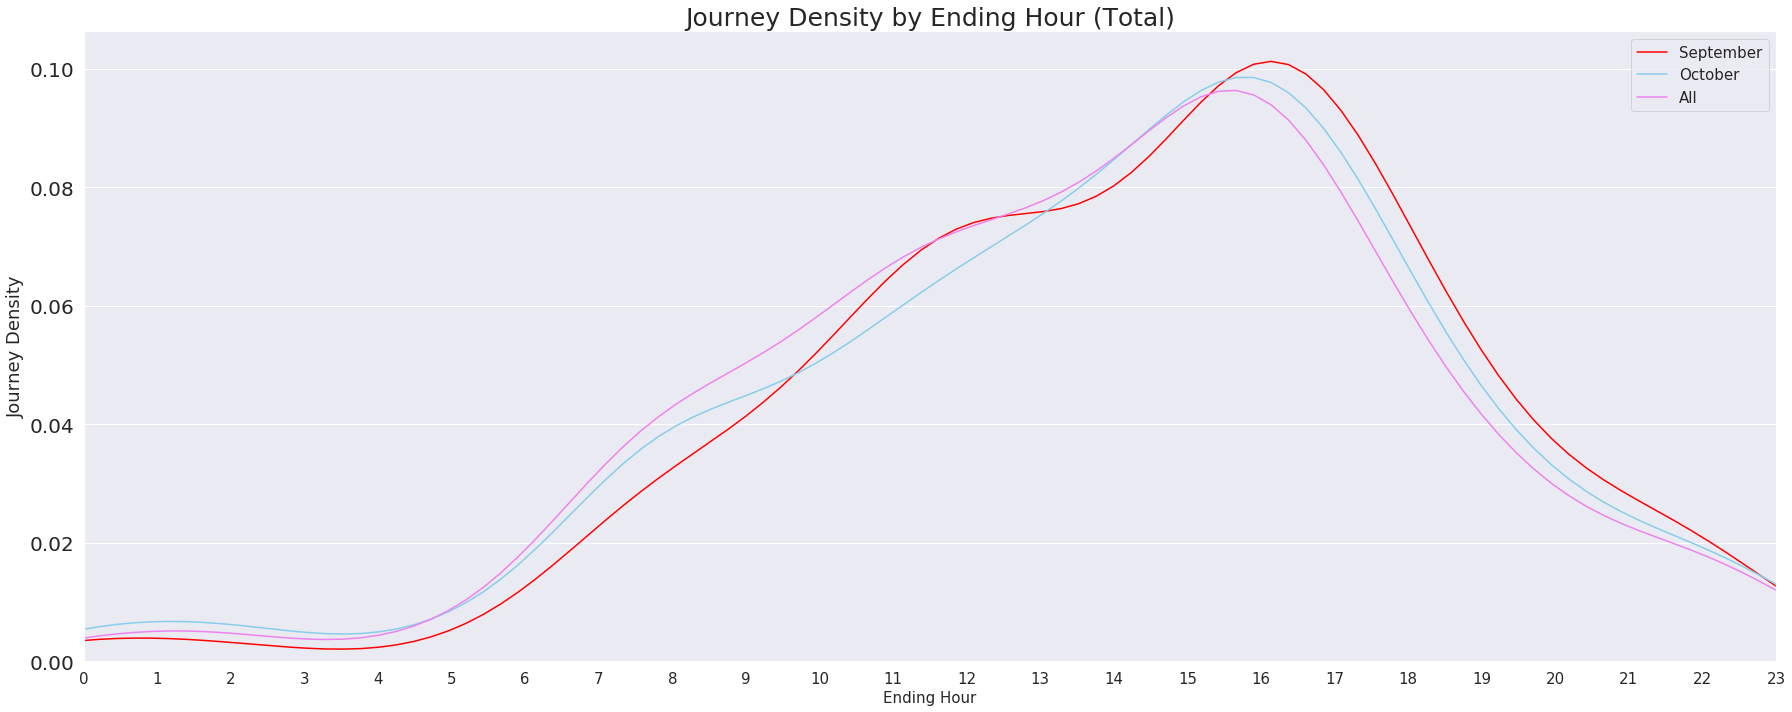

In [31]:
ending_hours_sept = sept_data.loc[:, 'end_hour']  
ending_hours_oct = oct_data.loc[:, 'end_hour']  
ending_hours_all = starting_hours_sept.append(starting_hours_oct)

# Set parameters for all graphs

figsize_input = (25,10)
xlim_input = (0,23)
xtick_list = range(0, 24, 1)

# Set parameters for side-by-side subplots
title_size_sbs = 25
x_lab_size_sbs = 15
x_tick_size_sbs = 13
y_lab_size_sbs = 18
y_tick_size_sbs = 20
grid_color_sbs = 'white'
grid_linestyle_sbs = '-'
grid_linewidth_sbs = 0
grid_axes_sbs = 'x'  

  
# Set parameters for vertically stacked plots

title_size_vs = 25
x_lab_size_vs = 15
x_tick_size_vs = 15
xtick_list_vs = range(1, 25, 1)
y_lab_size_vs = 18
y_tick_size_vs = 20
legend_size_vs = 15
legend_loc_vs = 'upper right'
grid_color_vs = 'black'
grid_linestyle_vs = '-'
grid_linewidth_vs = 0
grid_axes_vs = 'x'  




# Plot all graphs

# For months separately

fig1 = plt.figure(figsize = figsize_input)
ax1 = fig1.add_subplot(121)
ax2 = fig1.add_subplot(122)


sns.distplot(ending_hours_sept, bins=24, color='red', label = 'September', ax=ax1, kde=False)
sns.distplot(ending_hours_oct, bins=24, color='skyblue', label = 'October', ax=ax2, kde=False)

# For combined density plot
fig2 = plt.figure(figsize = figsize_input)
ax3 = fig2.add_subplot(111)

sns.distplot(starting_hours_all, bins=24, color='violet', ax=ax3, hist=True, kde = False)

# For combined distribution plot

fig3 = plt.figure(figsize = figsize_input)
ax4 = fig3.add_subplot(111)

# Use bw parameter to get a smoother density estimate

sns.distplot(ending_hours_sept, bins=24, color='red', label = 'September', ax=ax4, hist = False, kde_kws={'bw':1.2})
sns.distplot(ending_hours_oct, bins=24, color='skyblue', label = 'October', ax=ax4, hist=False, kde_kws={'bw':1.2})
sns.distplot(ending_hours_all, bins=24, color='violet', label = 'All', ax=ax4, hist=False, kde_kws={'bw':1.2})




# Style 

# ax1: September Plot

ax1.set_title('Journey Frequency by Ending Hour (September)', fontsize = title_size_sbs)
ax1.set_xlabel('Ending Hour', fontsize = x_lab_size_sbs)
ax1.set_ylabel('Journey Frequency', fontsize = y_lab_size_sbs)
ax1.set_xticks(xtick_list)
ax1.tick_params(axis='x', which='major', labelsize = x_tick_size_sbs)
ax1.tick_params(axis='y', which='major', labelsize = y_tick_size_sbs)
ax1.set_xlim(xlim_input)
ax1.grid(axis=grid_axes_sbs, color=grid_color_sbs, linestyle=grid_linestyle_sbs, linewidth=grid_linewidth_sbs)

# ax2: October Plot

ax2.set_title('Journey Frequency by Ending Hour (October)', fontsize = title_size_sbs)
ax2.set_xlabel('Ending Hour', fontsize = x_lab_size_sbs)
ax2.set_ylabel('Journey Frequency', fontsize = y_lab_size_sbs)
ax2.set_xticks(xtick_list)
ax2.tick_params(axis='x', which='major', labelsize = x_tick_size_sbs)
ax2.tick_params(axis='y', which='major', labelsize = y_tick_size_sbs)
ax2.set_xlim(xlim_input)
ax2.grid(axis=grid_axes_sbs, color=grid_color_sbs, linestyle=grid_linestyle_sbs, linewidth=grid_linewidth_sbs)


# ax3: Combined density plot of September and October

ax3.set_title('Journey Density by Ending Hour (Combined)', fontsize = title_size_vs)
ax3.set_xlabel('Ending Hour', fontsize = x_lab_size_vs)
ax3.set_ylabel('Journey Frequency', fontsize = y_lab_size_vs)
ax3.set_xticks(xtick_list)
ax3.tick_params(axis='x', which='major', labelsize = x_tick_size_vs)
ax3.tick_params(axis='y', which='major', labelsize = y_tick_size_vs)
ax3.set_xlim(xlim_input)
ax3.grid(axis=grid_axes_vs, color=grid_color_vs, linestyle=grid_linestyle_vs, linewidth=grid_linewidth_vs)

# ax4: Histogram and density plot for all 

ax4.set_title('Journey Density by Ending Hour (Total)', fontsize = title_size_vs)
ax4.set_xlabel('Ending Hour', fontsize = x_lab_size_vs)
ax4.set_ylabel('Journey Density', fontsize = y_lab_size_vs)
ax4.set_xticks(xtick_list)
ax4.tick_params(axis='x', which='major', labelsize = x_tick_size_vs)
ax4.tick_params(axis='y', which='major', labelsize = y_tick_size_vs)
ax4.set_xlim(xlim_input)
ax4.grid(axis=grid_axes_vs, color=grid_color_vs, linestyle=grid_linestyle_vs, linewidth=grid_linewidth_vs)
ax4.legend(loc = legend_loc_vs, prop = {'size': legend_size_vs})




plt.tight_layout()
plt.show()

The distribution has hardly changed, which would be anticipated given the average journey time was around 30 minutes as seen previously, so the hour is not enough of a breakdown to spot any differences. Going into more detail is easy enough (breaking down hours into 30 minute segments), but any differences are likely to be unimportant. 

#### Starting Hour by Station

Now we see if the starting hour varies by the station people leave from. This can be used to discover a station's "rush hour", i.e. when demand for bikes is at its highest. 

In [32]:
# First, get top 15 stations, as these are most relevant
top_15_stations = start_plot_order[::-1][0:15]

# filtered_data
top_15_data = all_data.loc[all_data.loc[:,'start_name_and_desc'].isin(top_15_stations), :]

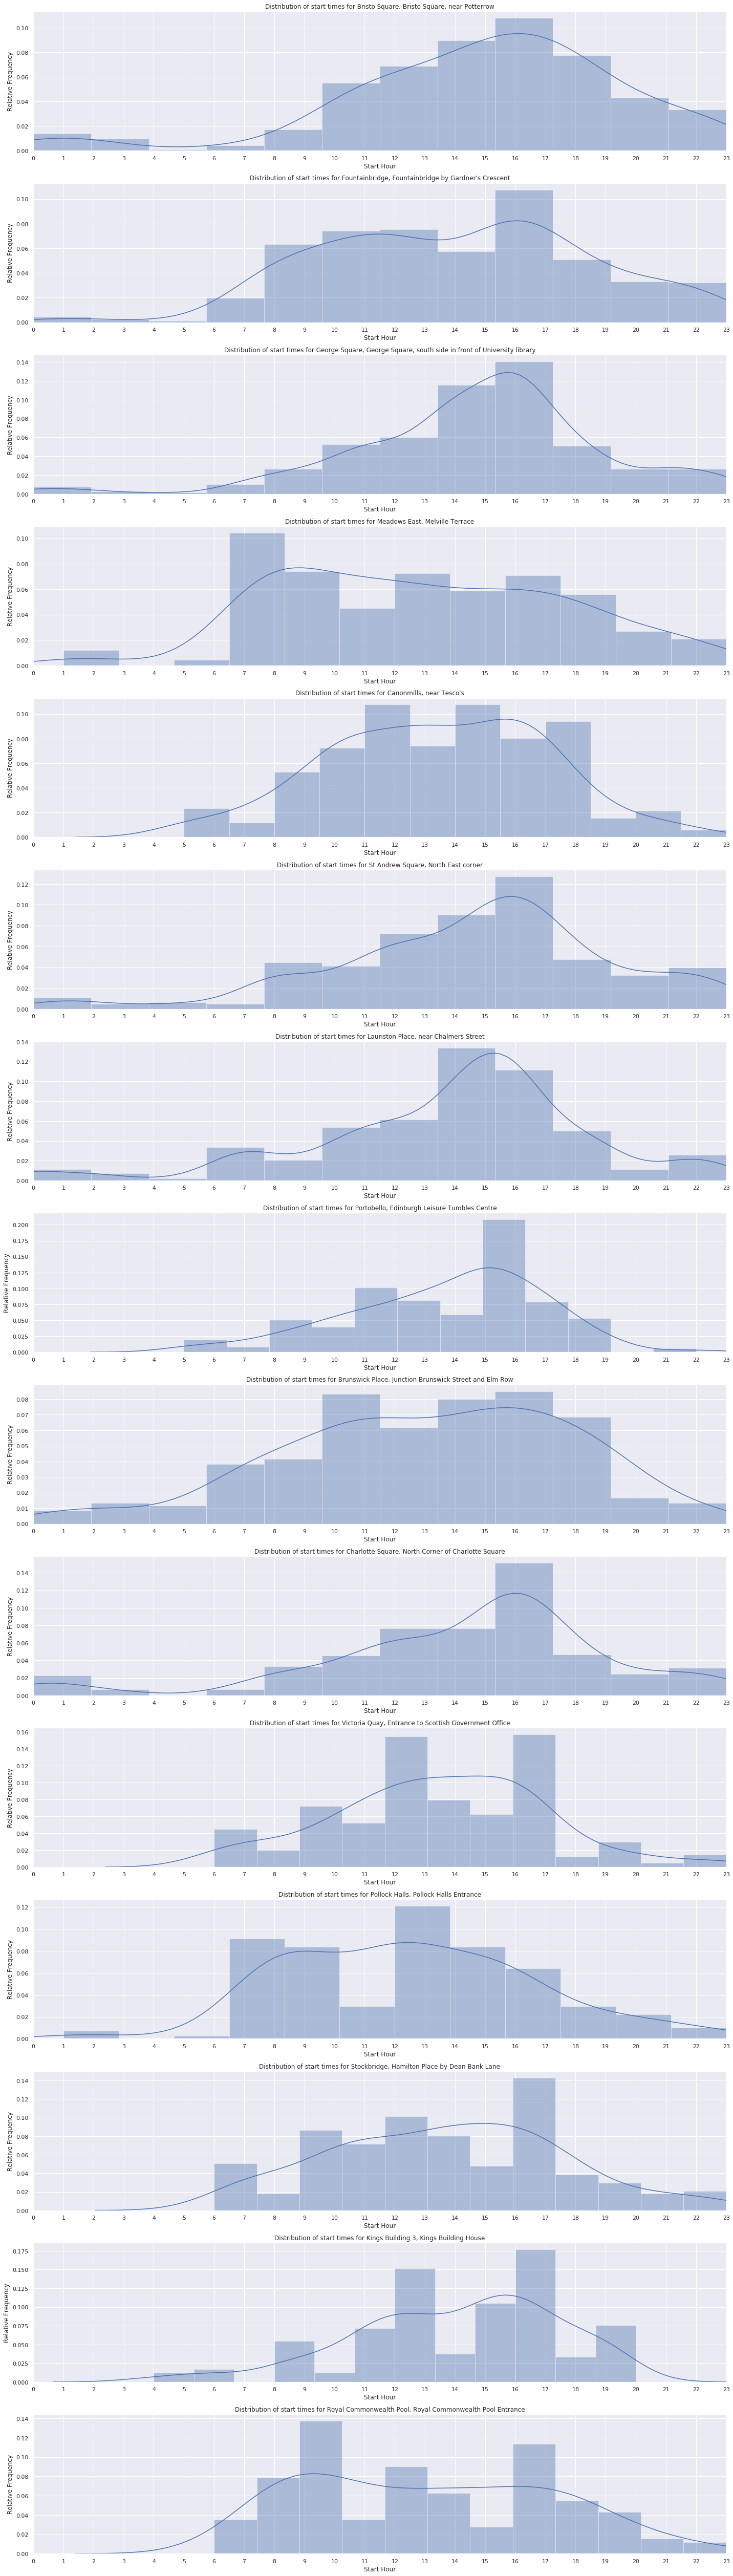

In [33]:
# Create subplots
fig = plt.figure(figsize=(20,70))


for subplot_index, station in enumerate(top_15_stations):
    # Subplot
    ax = fig.add_subplot(15, 1, subplot_index+1)
    # Filter top 15 to that station, get time
    station_data = top_15_data.loc[top_15_data.loc[:, 'start_name_and_desc'] == station, 'start_hour']
    # Plot histogram
    # 12 bins, as not enough information for all bins when split by station.
    # When more data comes in, we can increase the number of bins
    sns.distplot(station_data, bins=12)
    # Set titles and labels
    ax.set_xlim((0,23))
    ax.set_title(f'Distribution of start times for {station}')
    ax.set_xticks(range(0,24))
    ax.set_xlabel('Start Hour')
    ax.set_ylabel('Relative Frequency')


plt.tight_layout()
plt.show()

#### Ending Hour by Station

Now we see if the ending hour varies by the station people leave from. This can be used to see when bike supply is at its highest at a particular station

In [34]:
# First, get top 15 stations, as these are most relevant
top_15_stations = end_plot_order[::-1][0:15]

# filtered_data
top_15_data = all_data.loc[all_data.loc[:,'end_name_and_desc'].isin(top_15_stations), :]

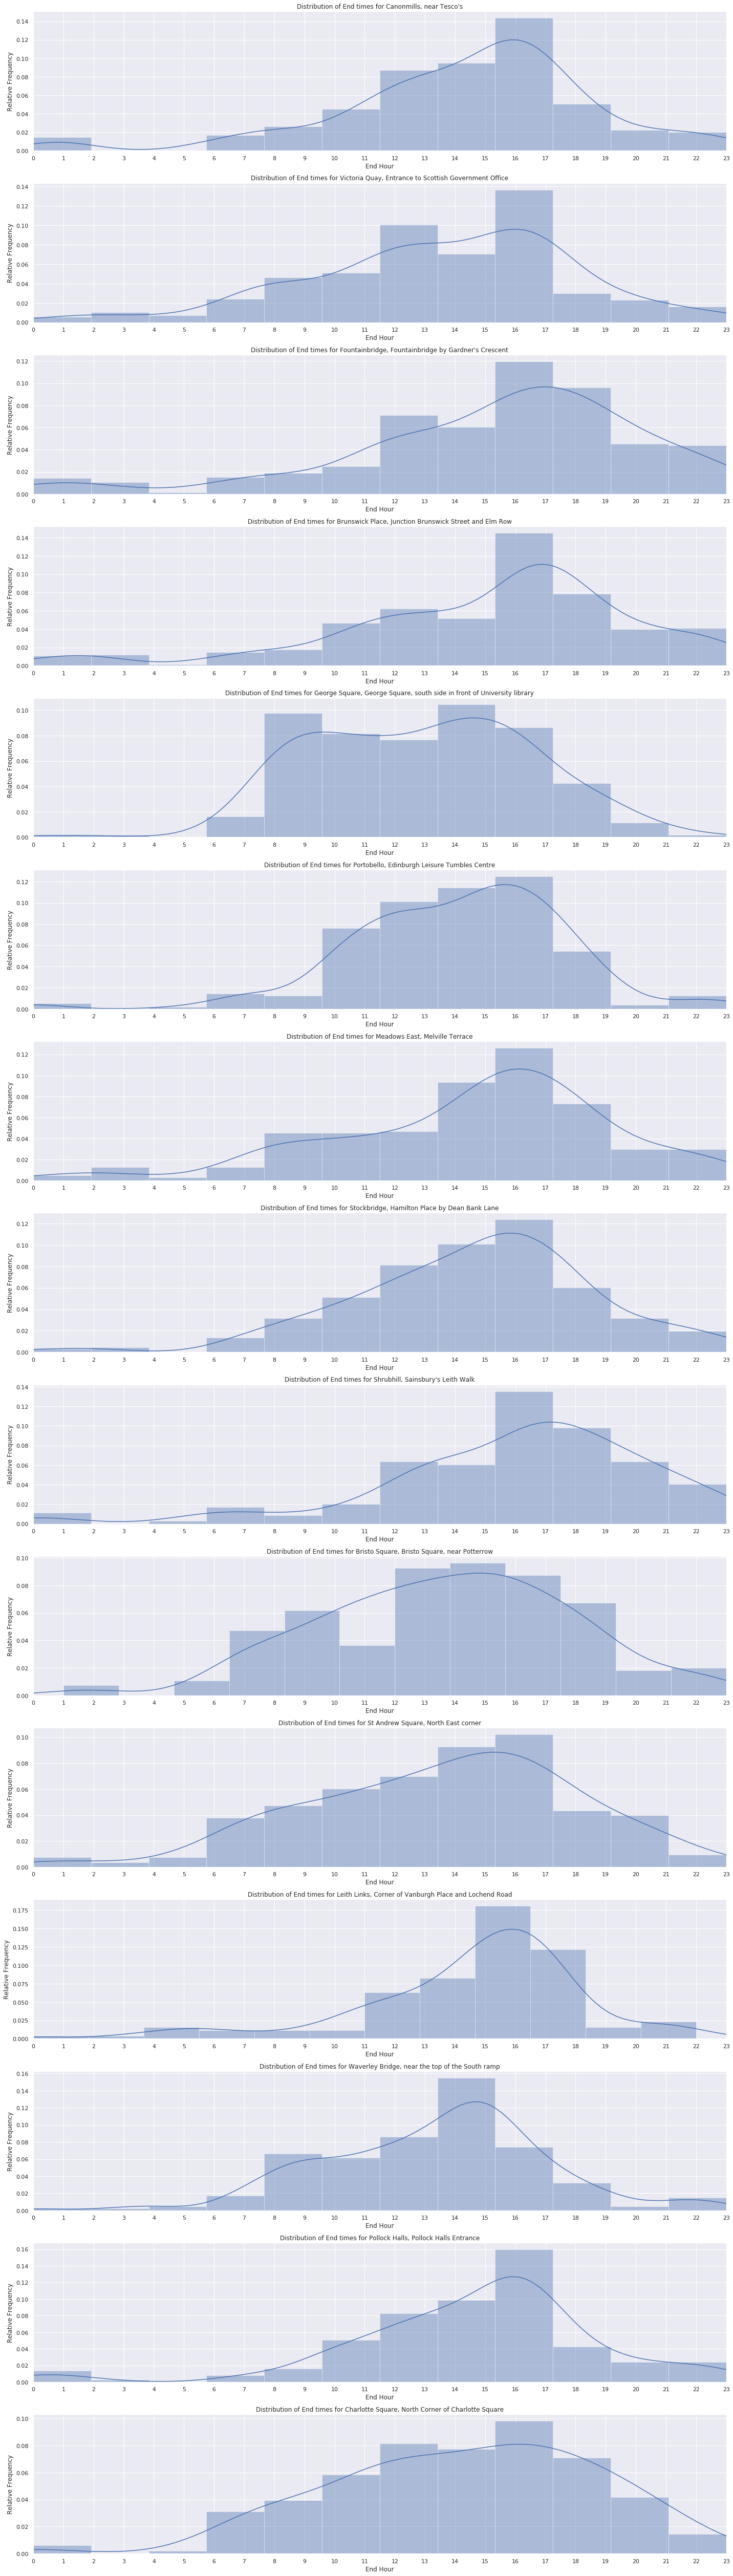

In [35]:
# Create subplots
fig = plt.figure(figsize=(20,70))


for subplot_index, station in enumerate(top_15_stations):
    # Subplot
    ax = fig.add_subplot(15, 1, subplot_index+1)
    # Filter top 15 to that station, get time
    station_data = top_15_data.loc[top_15_data.loc[:, 'end_name_and_desc'] == station, 'end_hour']
    # Plot histogram
    # 12 bins, as not enough information for all bins when split by station.
    # When more data comes in, we can increase the number of bins
    sns.distplot(station_data, bins=12)
    # Set titles and labels
    ax.set_xlim((0,23))
    ax.set_title(f'Distribution of End times for {station}')
    ax.set_xticks(range(0,24))
    ax.set_xlabel('End Hour')
    ax.set_ylabel('Relative Frequency')


plt.tight_layout()
plt.show()

We can note that again ending times are most frequently concentrated around hour 16 (4pm). The exceptions are George Square and Bristo Square. Let us now compare the start and end times of stations in both the top 15 start and end times

In [36]:
start_set = set(start_plot_order[::-1][0:15])
end_set = set(end_plot_order[::-1][0:15])
both_set = start_set.intersection(end_set)
# Convert to a list and sort, so outputs in alphabetical order
both_set = sorted(list(both_set))

# Filter data so either the start or end station is in 'both_set'
# Vertical line is 'or' in pandas for Series operations
both_data = all_data.loc[all_data.loc[:,'start_name_and_desc'].isin(both_set) | 
                         all_data.loc[:,'end_name_and_desc'].isin(both_set), :]

We now plot the start and end distributions side by side

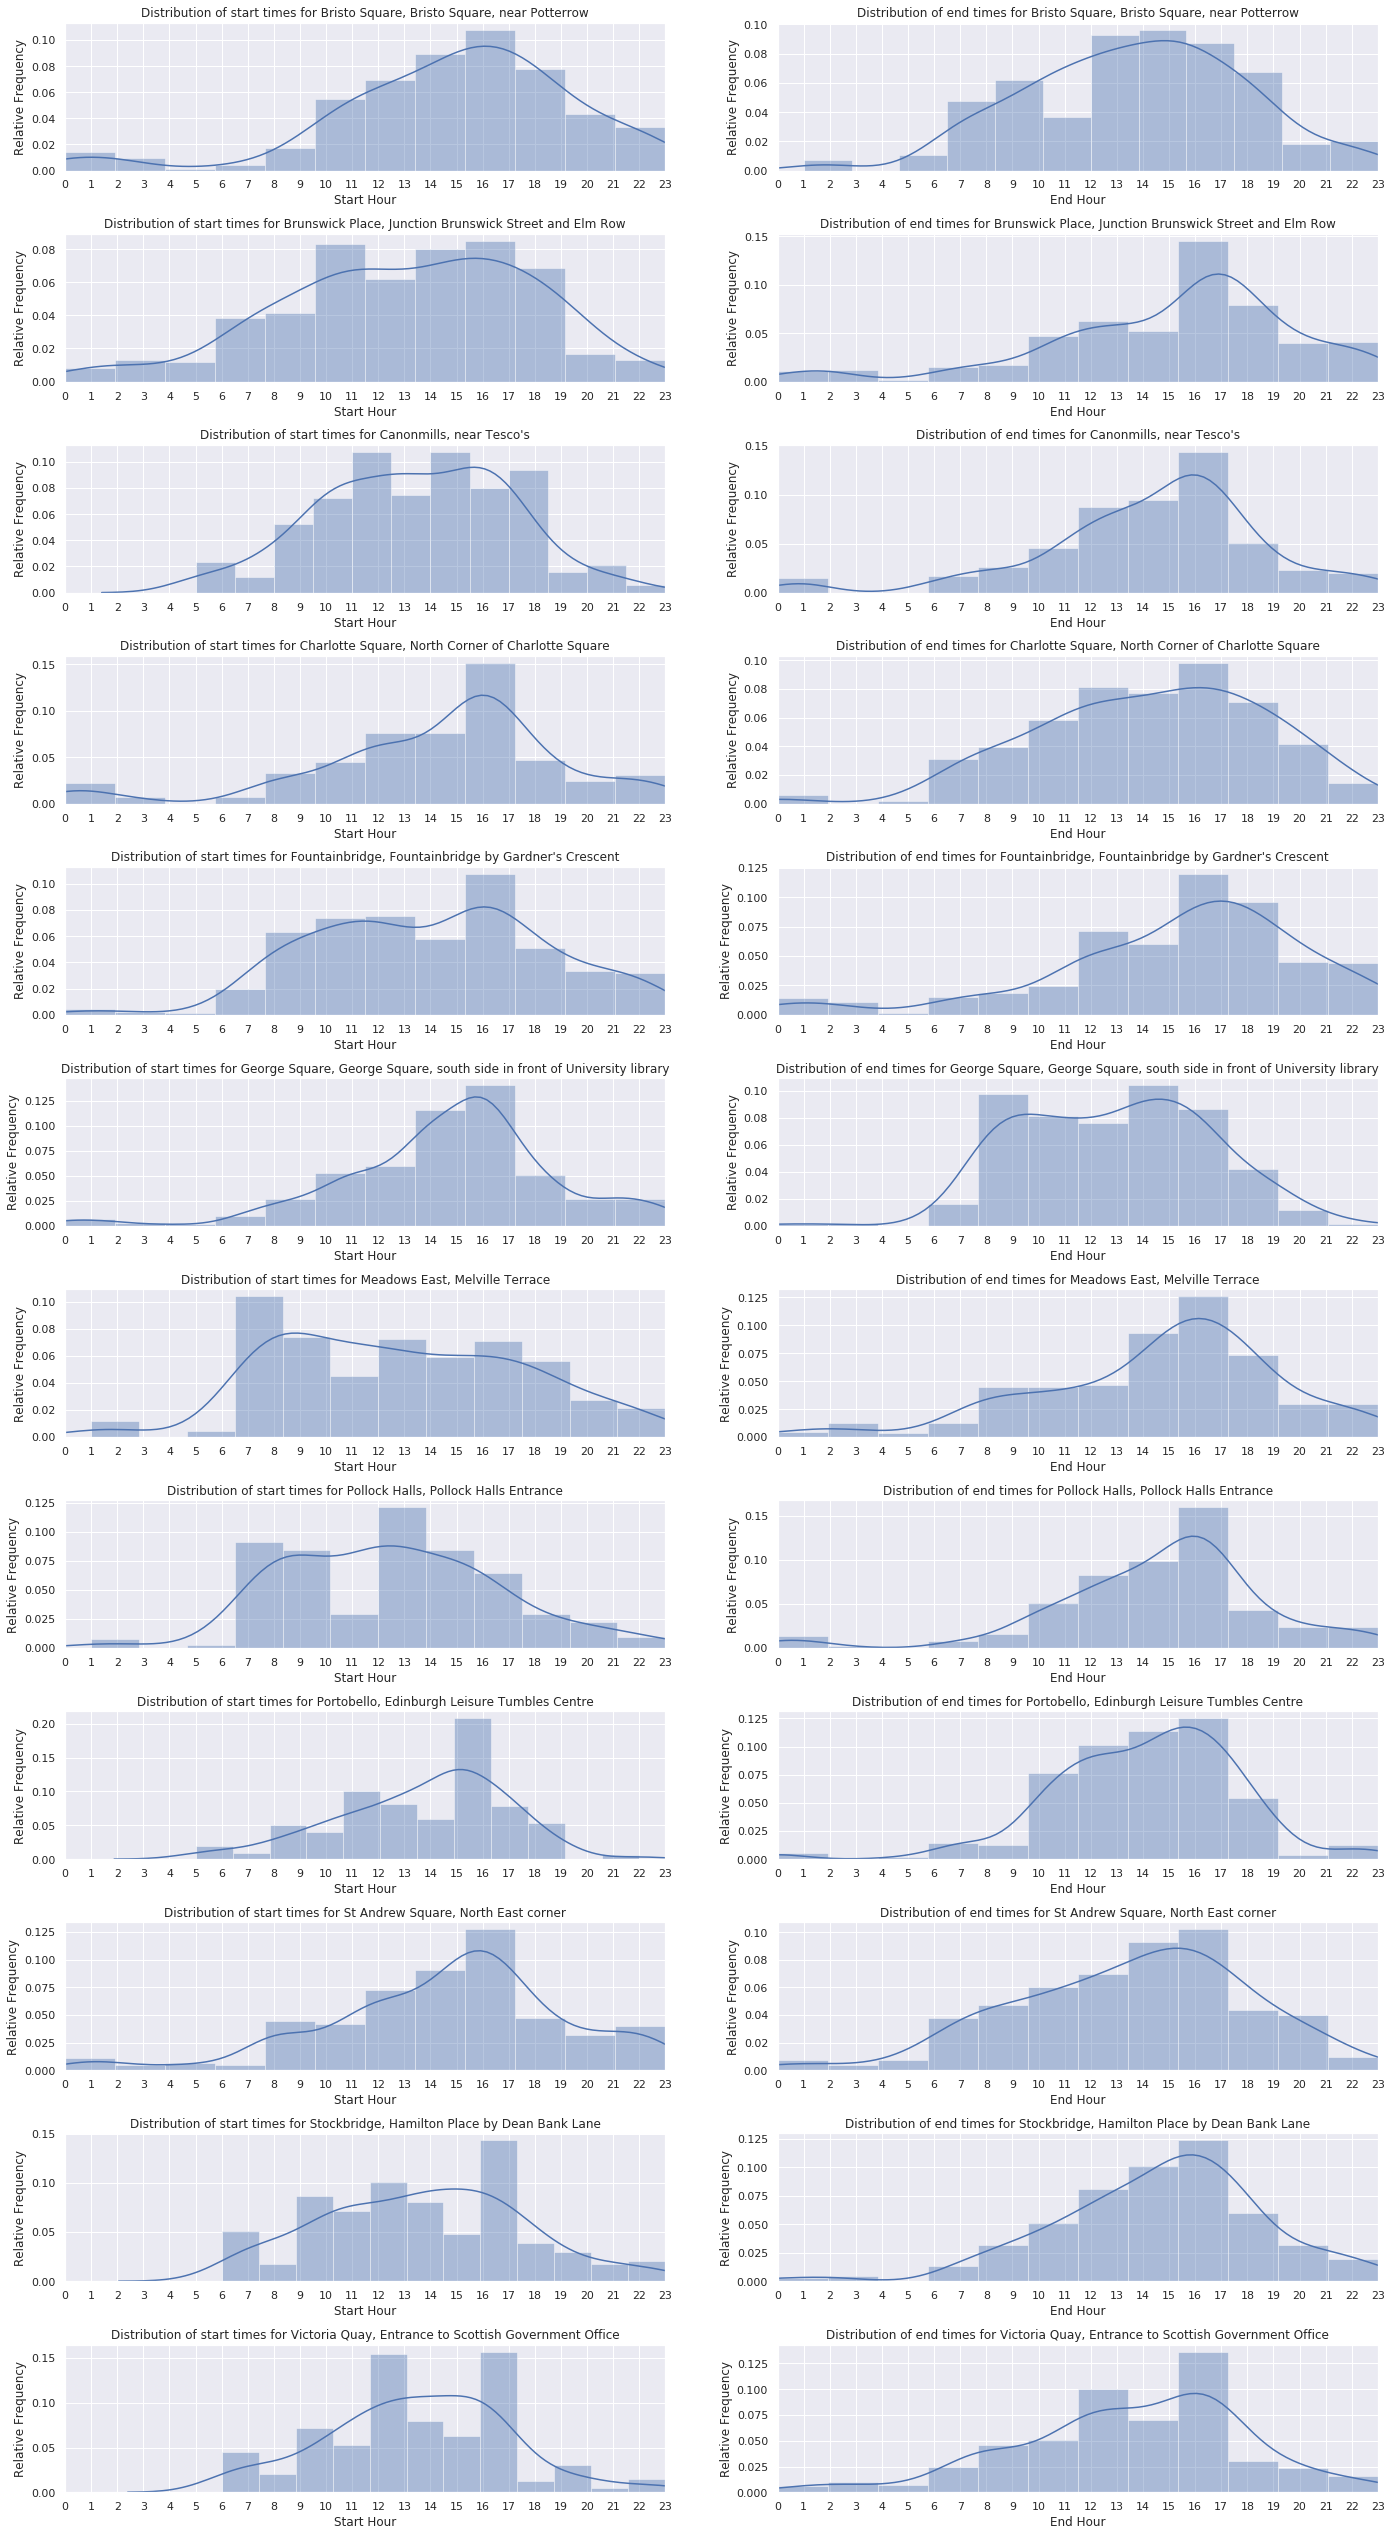

In [37]:
# Create subplots
fig = plt.figure(figsize=(20,70))
# Number of subplots, 2 for each element in both_set
num_subplots = len(both_set)*2

# Increment the subplot
subplot_num = 0

for station in both_set:
    # Select subplot for the left (start)
    subplot_num += 1
    ax = fig.add_subplot(num_subplots, 2, subplot_num)

    
    stat_data = both_data.loc[both_data.loc[:, 'start_name_and_desc'] == station, 'start_hour']

    # Plot histogram with 12 bins
    sns.distplot(stat_data, bins = 12)
    # Set titles and labels
    ax.set_xlim((0,23))
    ax.set_title(f'Distribution of start times for {station}')
    ax.set_xticks(range(0,24))
    ax.set_xlabel('Start Hour')
    ax.set_ylabel('Relative Frequency')

    
    # Select subplot for the right (end)
    subplot_num += 1
    ax = fig.add_subplot(num_subplots, 2, subplot_num)
    
    stat_data = both_data.loc[both_data.loc[:, 'end_name_and_desc'] == station, 'end_hour']
    # Plot histogram stat_data 12 bins
    sns.distplot(stat_data, bins = 12)
    # Set titles and labels
    ax.set_xlim((0,23))
    ax.set_title(f'Distribution of end times for {station}')
    ax.set_xticks(range(0,24))
    ax.set_xlabel('End Hour')
    ax.set_ylabel('Relative Frequency')

plt.tight_layout()
plt.show()

Overall, it looks like the demand for bikes and the supply for bikes do not 'match up' in the sense that generally a high number of starting journeys does not coincide with a high number of ending journeys. For examaple, lots of people depart Canonmill's throughout the day, but it seems these bikes are not being equivalently replaced until approximately 4pm. 

For Pollock, many people leave in the morning, and then at 1pm, but people do not arrive until about 4pm when the number of journeys has died down. 

However it is hard to be concrete about these numbers with the kernel density estimates on the plots. So let us recreat this without the kernel densities

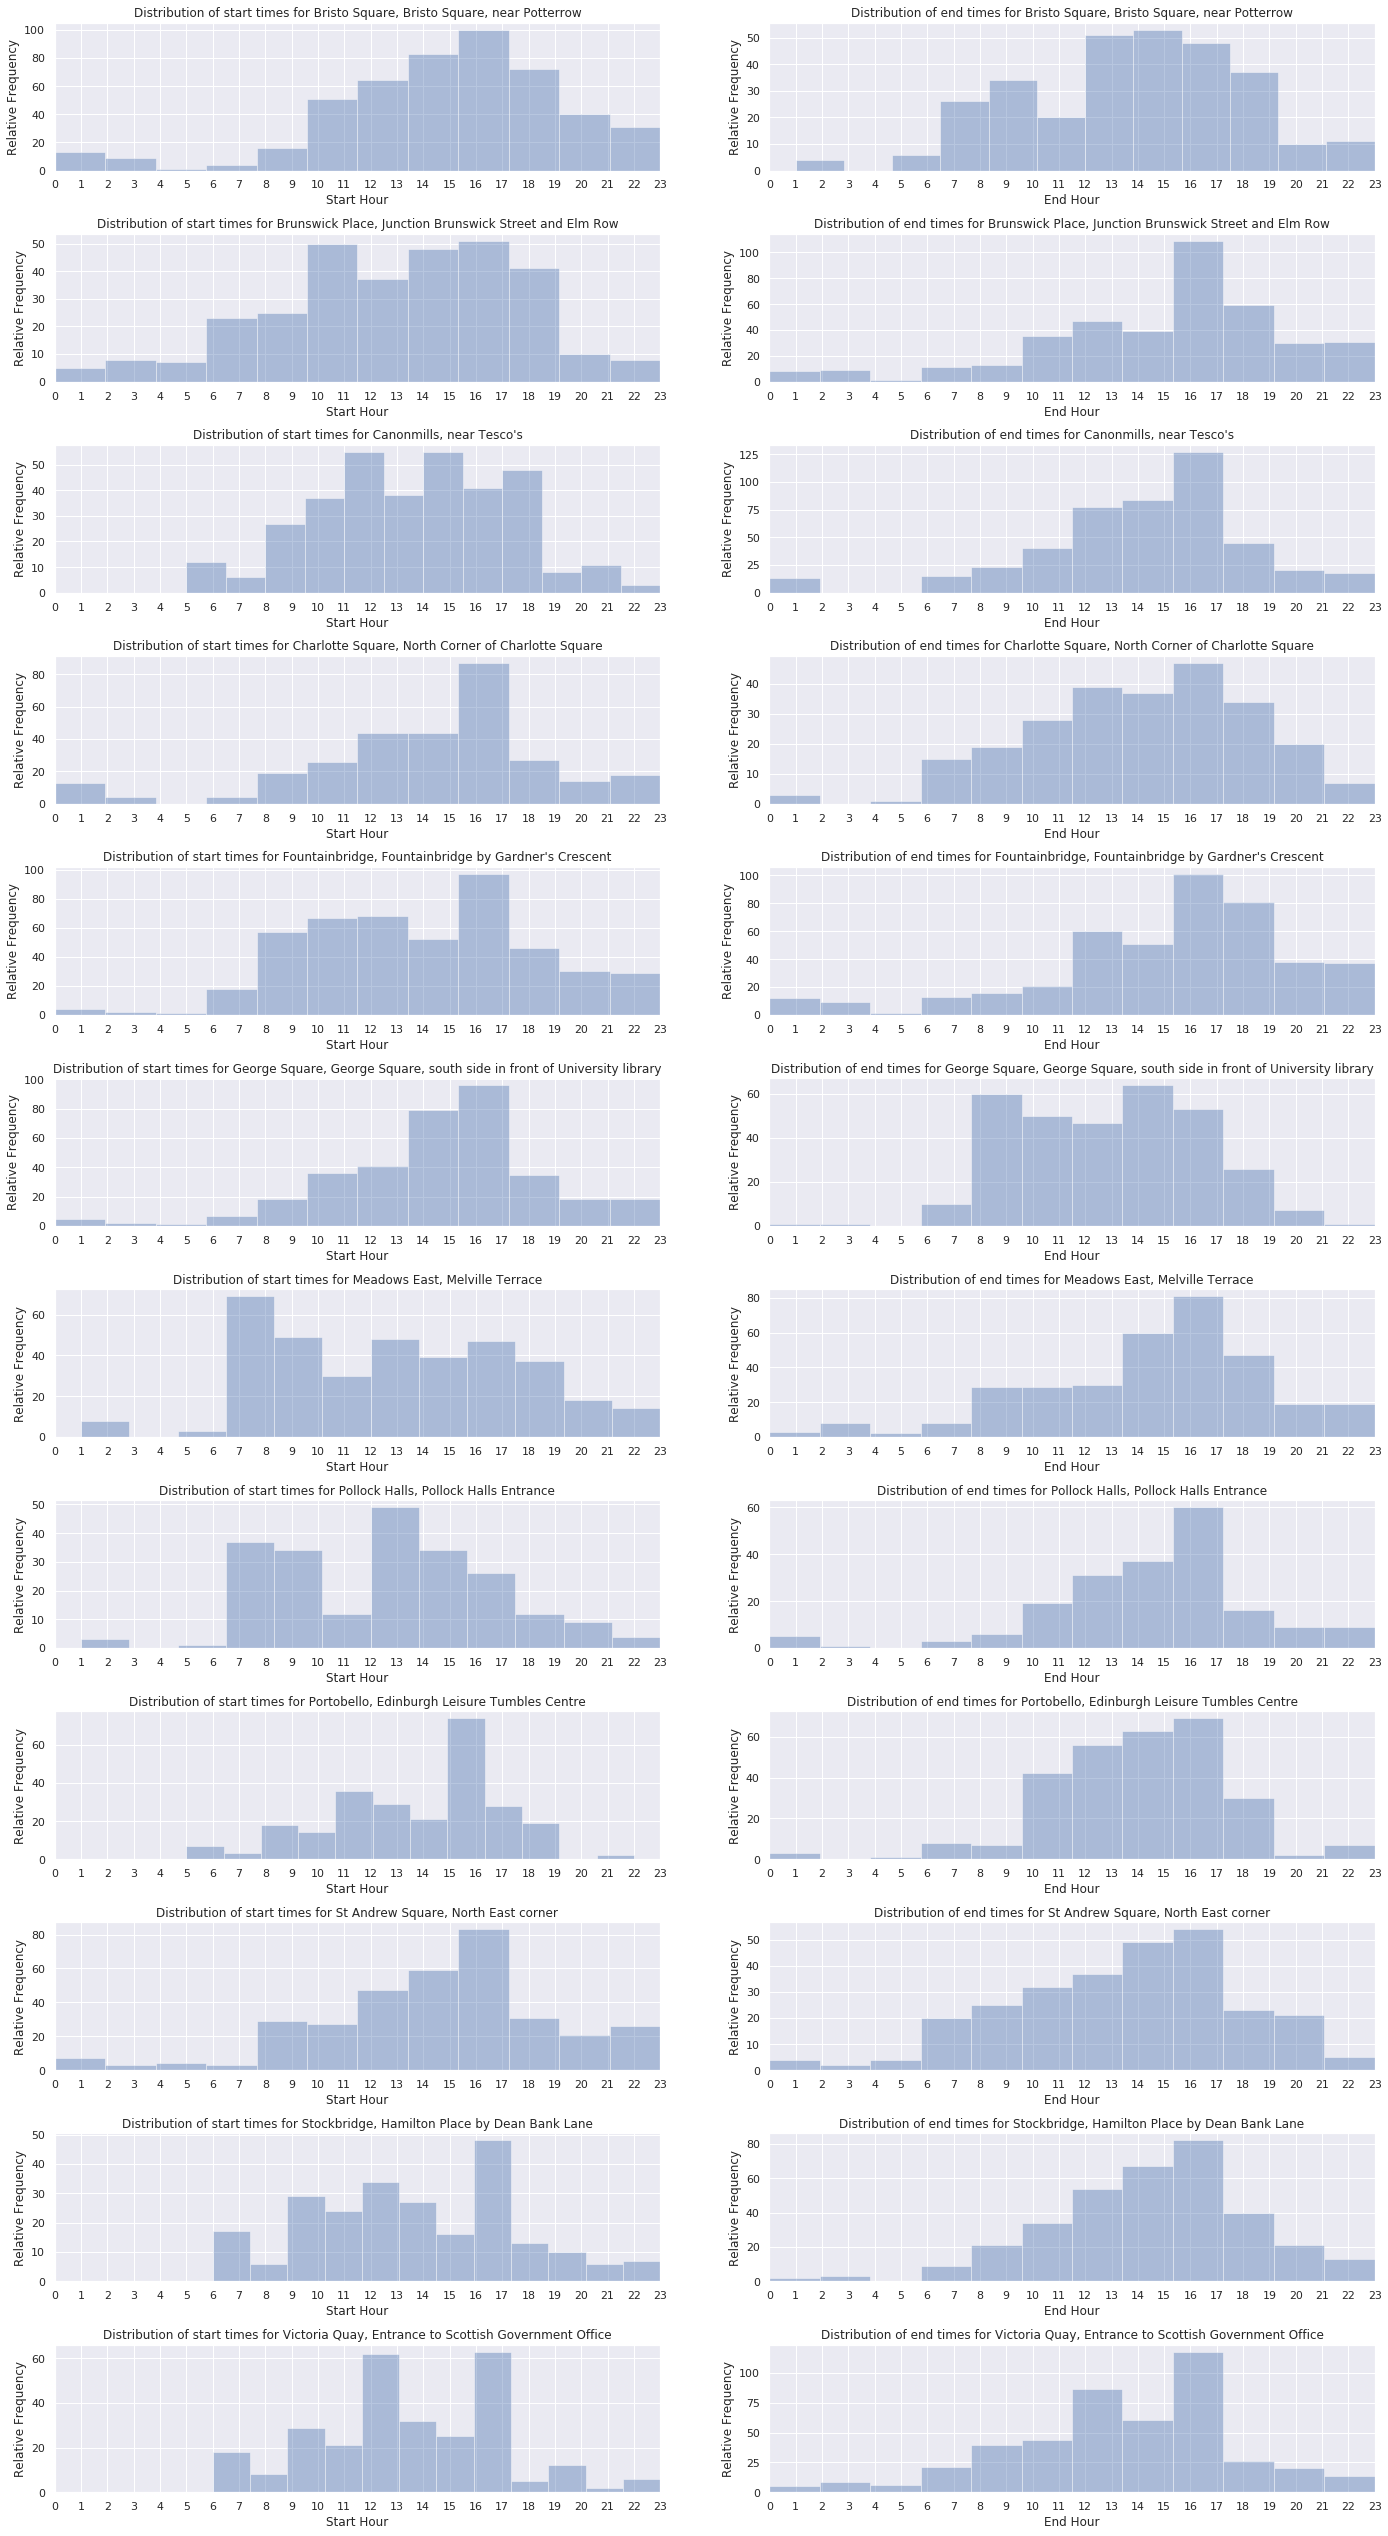

In [38]:
# Create subplots
fig = plt.figure(figsize=(20,70))
# Number of subplots, 2 for each element in both_set
num_subplots = len(both_set)*2

# Increment the subplot
subplot_num = 0

for station in both_set:
    # Select subplot for the left (start)
    subplot_num += 1
    ax = fig.add_subplot(num_subplots, 2, subplot_num)

    
    stat_data = both_data.loc[both_data.loc[:, 'start_name_and_desc'] == station, 'start_hour']

    # Plot histogram with 12 bins
    sns.distplot(stat_data, bins = 12, kde = False)
    # Set titles and labels
    ax.set_xlim((0,23))
    ax.set_title(f'Distribution of start times for {station}')
    ax.set_xticks(range(0,24))
    ax.set_xlabel('Start Hour')
    ax.set_ylabel('Relative Frequency')

    
    # Select subplot for the right (end)
    subplot_num += 1
    ax = fig.add_subplot(num_subplots, 2, subplot_num)
    
    stat_data = both_data.loc[both_data.loc[:, 'end_name_and_desc'] == station, 'end_hour']
    # Plot histogram stat_data 12 bins
    sns.distplot(stat_data, bins = 12, kde = False)
    # Set titles and labels
    ax.set_xlim((0,23))
    ax.set_title(f'Distribution of end times for {station}')
    ax.set_xticks(range(0,24))
    ax.set_xlabel('End Hour')
    ax.set_ylabel('Relative Frequency')

plt.tight_layout()
plt.show()

Using counting numbers instead of relative frequencies gives us a better idea of what is happening. For example, looking at Canonmills we can see that, although the bars are not as high on the ending plot, there are more bikes being deposited than there are leaving, that is we cannot just look at the height of the bars. We must be careful about drawing conclusions. Departures from Canonmills never reach above 50, but arrivals are  above 75 between 1pm and 5pm. Noting that the bins are grouped in 2 hour segments. 

Pollock Halls still has demand and supply inverse to each other, and Bristo Square has supply far outstripping demand. 

### Date Variation

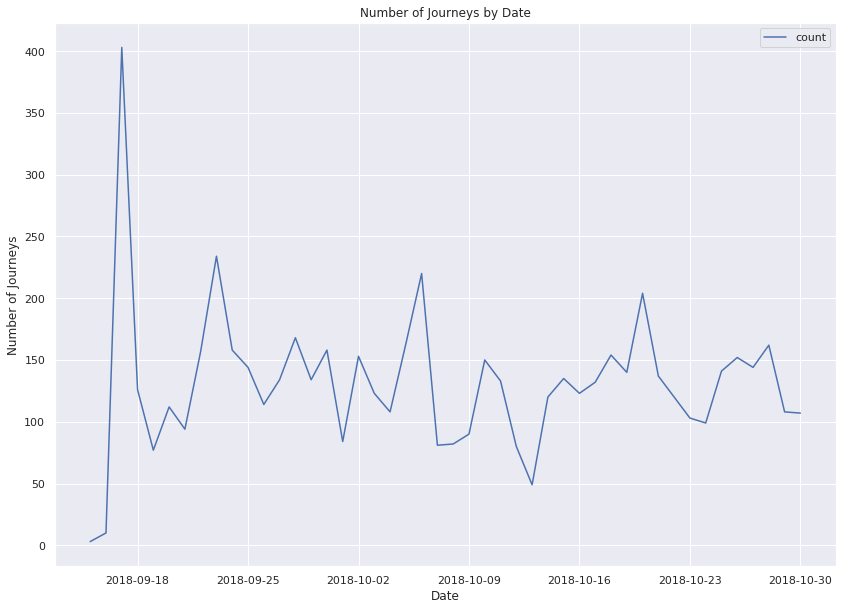

In [39]:
# Aggregate number of journeys by date
date_agg = all_data.groupby('start_date').agg({'count':'sum'})
fig = plt.figure(figsize = (14,10))
ax = fig.add_subplot(111)

sns.lineplot(data = date_agg, ax = ax)

ax.set_xlabel('Date')
ax.set_ylabel('Number of Journeys')
ax.set_title('Number of Journeys by Date')

plt.show()

In general, there does not appear to be a significant trend, though looking at the peak points, it seems there is a general trend downwards. Let us now see if there is a difference between stations

In [40]:
# Get top 5 stations
top_5_stations = start_plot_order[::-1][0:5]

# filtered_data

date_station = all_data.groupby(['start_date', 'start_name_and_desc']).agg({'count':'sum'})
date_station.reset_index(inplace=True)
# Keep most popular stations
date_station = date_station.loc[date_station.loc[:, 'start_name_and_desc'].isin(top_5_stations), :]

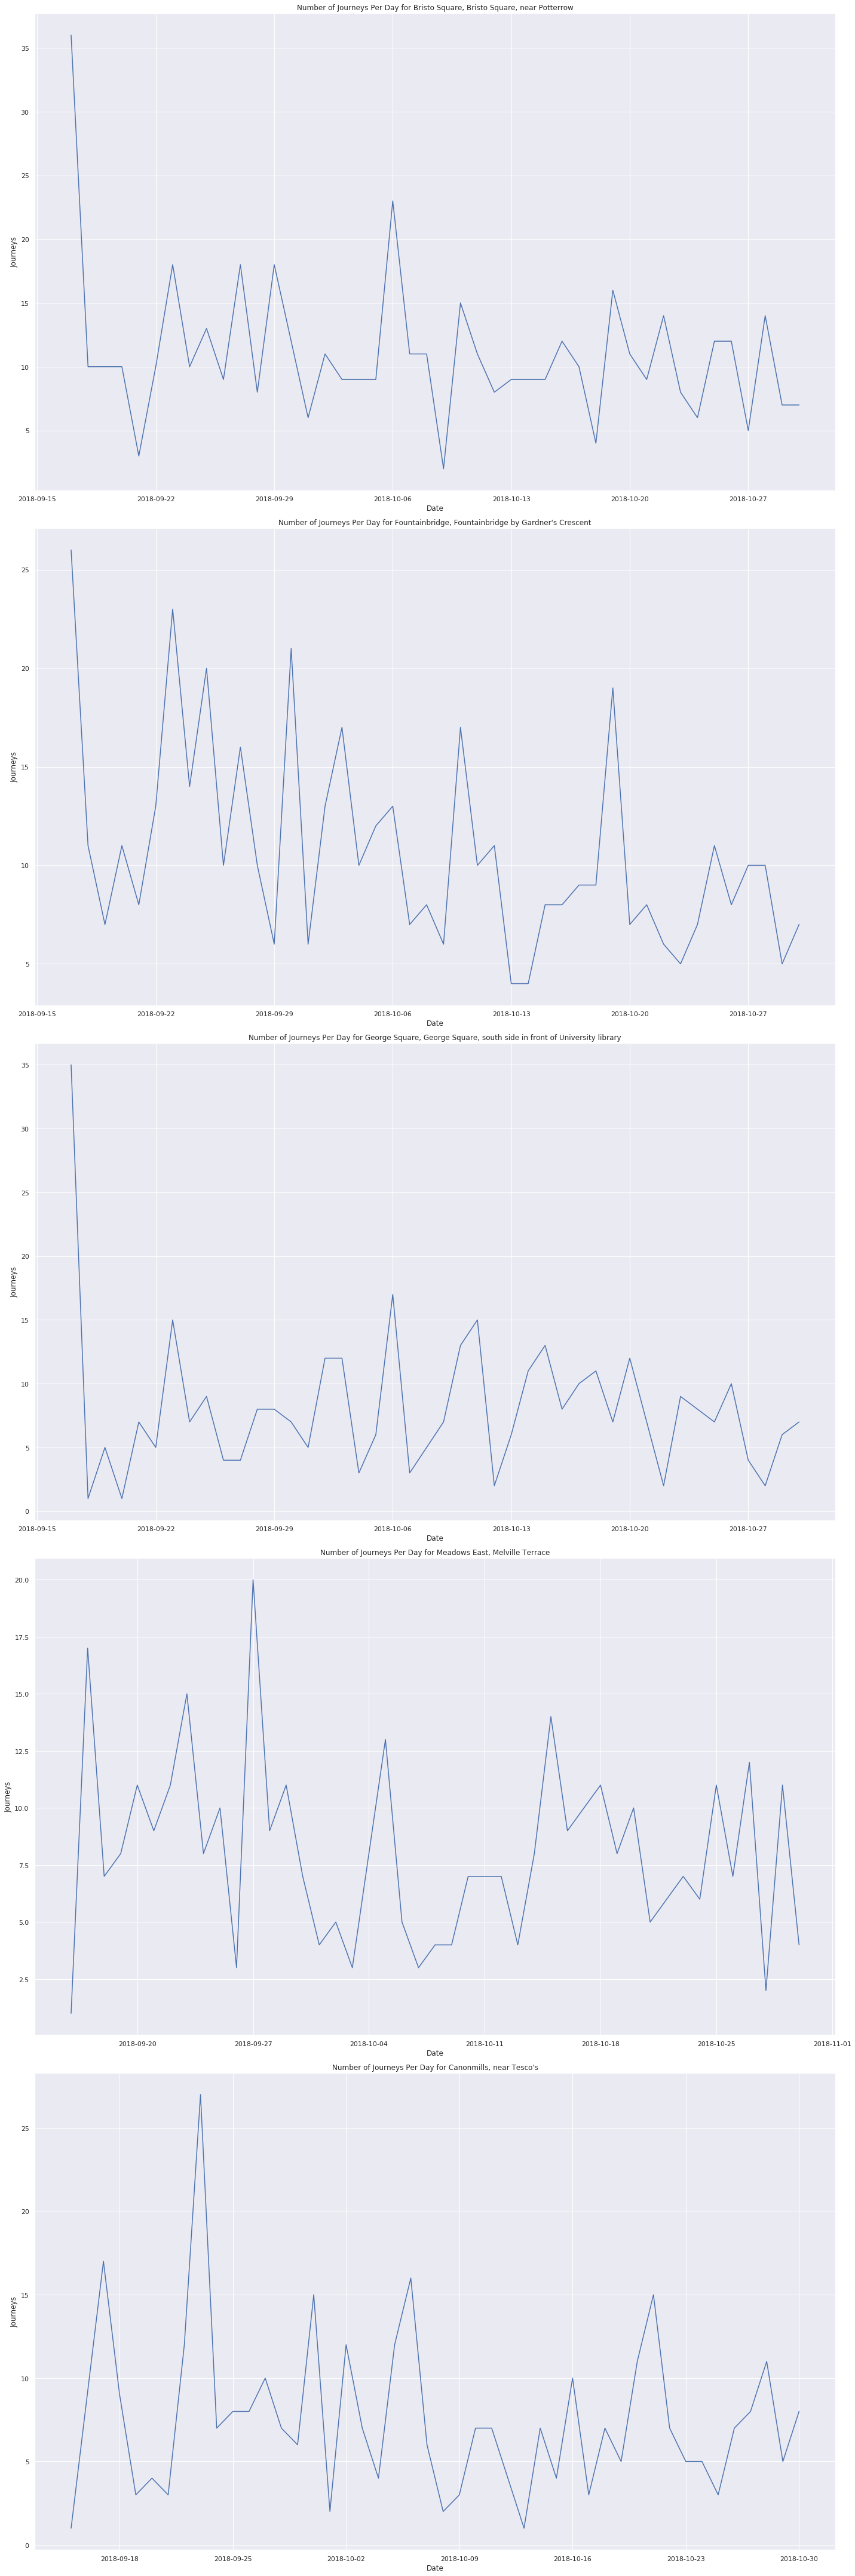

In [41]:
# Create subplots
fig = plt.figure(figsize=(20,60))


for subplot_index, station in enumerate(top_5_stations):
    # Subplot
    ax = fig.add_subplot(5, 1, subplot_index+1)
    # Filter top 15 to that station, get time
    filt_data = date_station.loc[date_station.loc[:, 'start_name_and_desc'] == station, :]
    # Plot histogram
    # 12 bins, as not enough information for all bins when split by station.
    # As more data comes in, we can increase the number of bins
    sns.lineplot(x = 'start_date', y = 'count', data = filt_data, estimator='sum')
    # Set titles and labels
    ax.set_title(f'Number of Journeys Per Day for {station}')
    ax.set_xlabel('Date')
    ax.set_ylabel('Journeys')


plt.tight_layout()
plt.show()

### Longest Journeys

From what station do people take the longest journeys? Firstly, let's start by trying to look for any correlation between duration and distance

In [42]:
np.corrcoef(all_data.loc[:, 'duration_mins'], all_data.loc[:, 'distance'])

array([[ 1.        , -0.02102261],
       [-0.02102261,  1.        ]])

We can see there is (strangely) no relationship between the duration of the journey and the distance travelled. This could be because some people start and end at the same station, meaning a positive duration, but 0 distance. Let us now see the correlation excluding 

In [43]:
# Filter data to just positive distances, and get new corelation
pos_dist = all_data.loc[all_data.loc[:, 'distance'] > 0, :, ]
np.corrcoef(pos_dist.loc[:, 'duration_mins'], pos_dist.loc[:, 'distance'])

array([[1.        , 0.10828779],
       [0.10828779, 1.        ]])

Even removing these people does not give us a meaningful relationship between the 2. 

Let us now look at how long people ride for, and how far they travel based on the starting station. Let us filter it to the top 15 most started stations, and use only those observations with greater than 0 distance. 

In [44]:
top_15_stations = start_plot_order[::-1][0:15]
pos_dist_top_15 = pos_dist.loc[pos_dist.loc[:, 'start_name_and_desc'].isin(top_15_stations) , :]

In [45]:
# Aggregate mean distance travelled and mean duration (in minutes) for each station
pos_dist_agg = pos_dist_top_15.groupby('start_name_and_desc').agg({'duration_mins': 'mean', 'distance': 'mean'})
pos_dist_agg.reset_index(inplace=True)
pos_dist_agg.columns = ['start_name_and_desc', 'mean_duration', 'mean_distance']

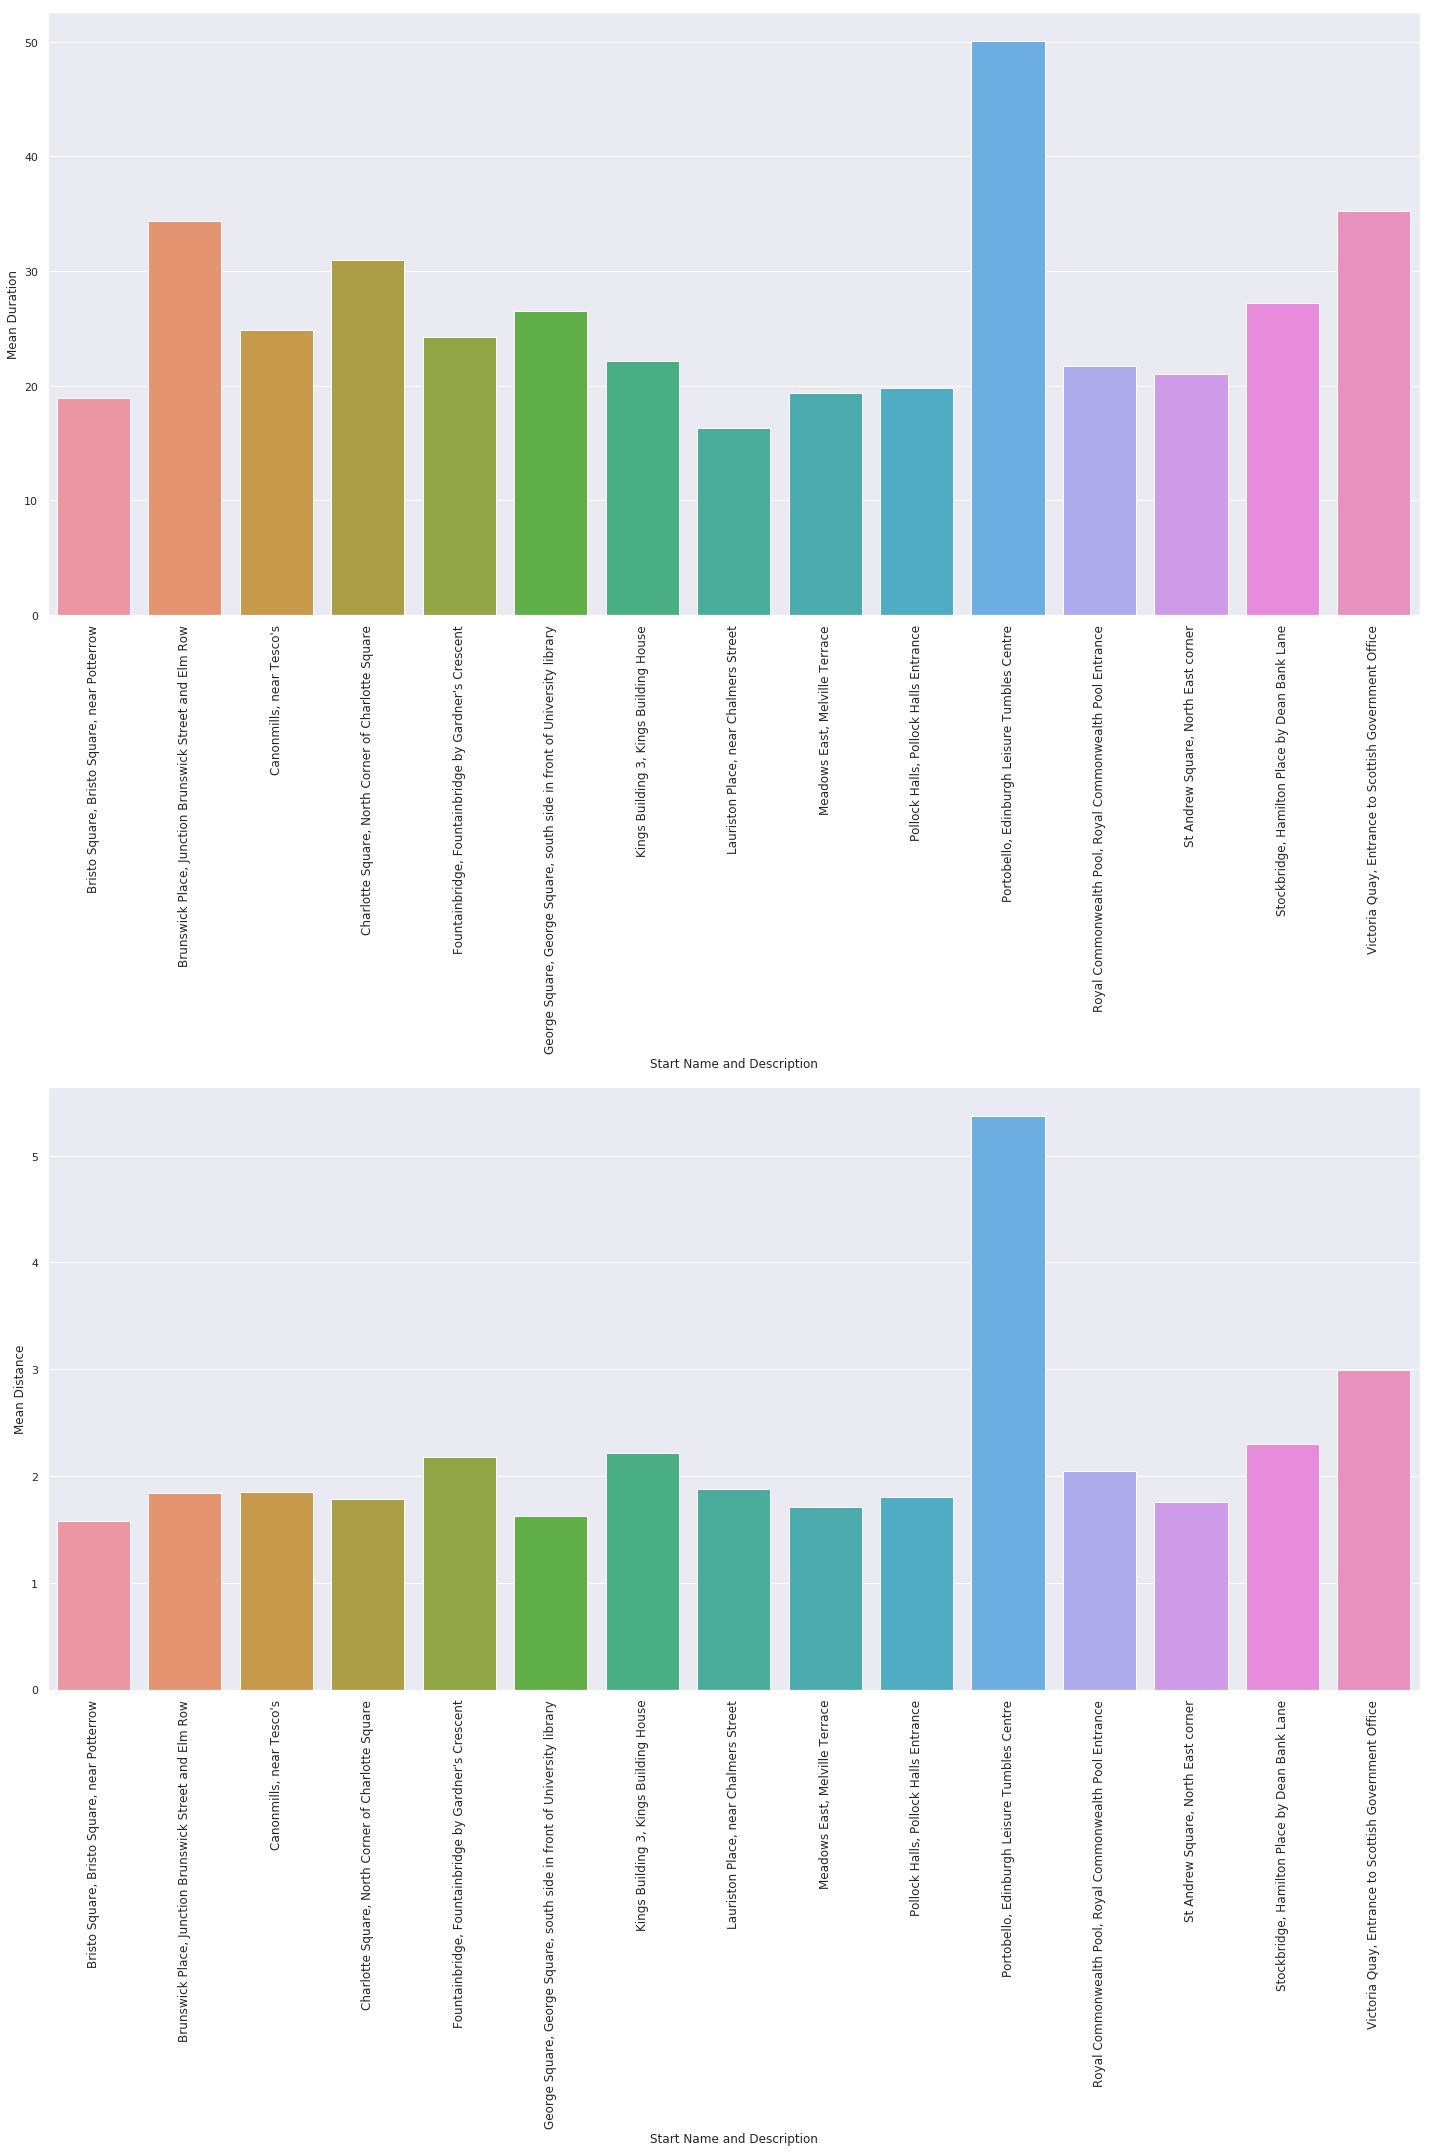

In [46]:
# Plot both on barplots

# Column names
cols_to_plot = ['mean_duration', 'mean_distance']

# Set up figure
fig = plt.figure(figsize = (20,30))

for subplot_index, col in enumerate(cols_to_plot):
    # Define which subplot we are on, and which subplot to plot on
    subplot_num = subplot_index + 1
    ax = fig.add_subplot(2, 1, subplot_num)
    
    col_label = ' '.join([word.capitalize() for word in col.split('_')]).strip()
    
    
    
    sns.barplot(x = 'start_name_and_desc', y = col, data = pos_dist_agg, ax = ax)
    ax.set_ylabel(col_label)
    ax.set_xlabel('Start Name and Description')
    ax.tick_params(axis = 'x', labelsize = 12, labelrotation = 90)
    
    
    


plt.tight_layout()
plt.show()

Portobello is a clear 'loser', in that people leave it for the longest time, and go the furthest away by far. The reason for this is that Portobello is a very isolated station. The figures will in fact work the other way round, as seen below

In [47]:
top_15_stations = end_plot_order[::-1][0:15]
pos_dist_top_15 = pos_dist.loc[pos_dist.loc[:, 'end_name_and_desc'].isin(top_15_stations) , :]

In [48]:
# Aggregate mean distance travelled and mean duration (in minutes) for each station
pos_dist_agg = pos_dist_top_15.groupby('end_name_and_desc').agg({'duration_mins': 'mean', 'distance': 'mean'})
pos_dist_agg.reset_index(inplace=True)
pos_dist_agg.columns = ['end_name_and_desc', 'mean_duration', 'mean_distance']

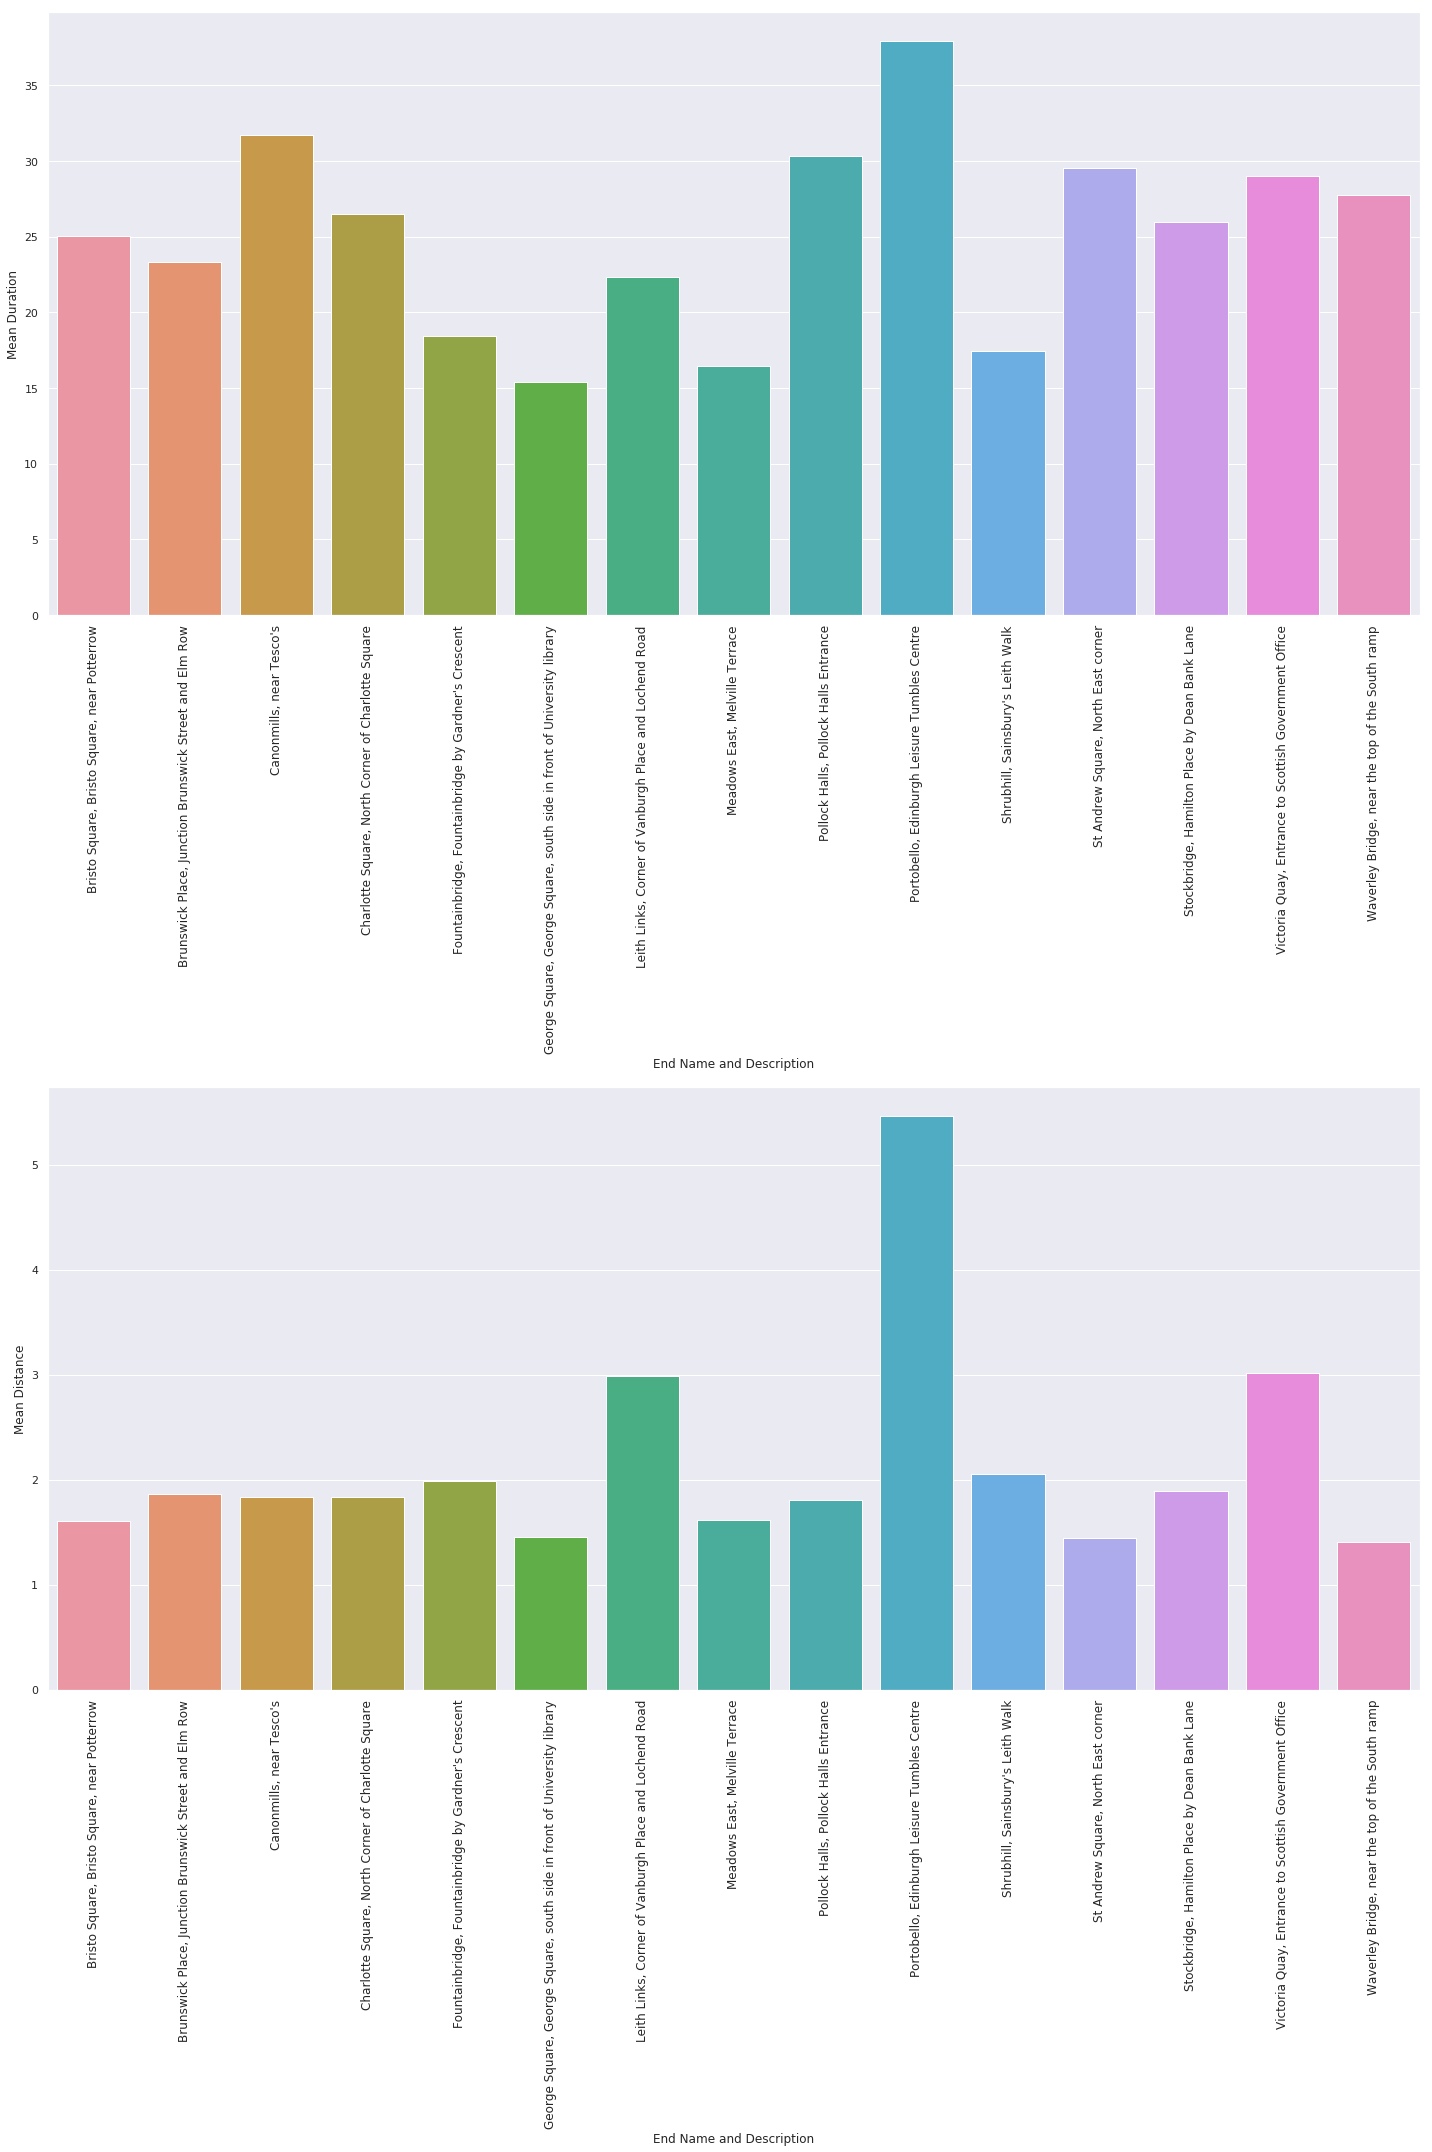

In [49]:
# Plot both on barplots

# Column names
cols_to_plot = ['mean_duration', 'mean_distance']

# Set up figure
fig = plt.figure(figsize = (20,30))

for subplot_index, col in enumerate(cols_to_plot):
    # Define which subplot we are on, and which subplot to plot on
    subplot_num = subplot_index + 1
    ax = fig.add_subplot(2, 1, subplot_num)
    
    col_label = ' '.join([word.capitalize() for word in col.split('_')]).strip()
    
    
    
    sns.barplot(x = 'end_name_and_desc', y = col, data = pos_dist_agg, ax = ax)
    ax.set_ylabel(col_label)
    ax.set_xlabel('End Name and Description')
    ax.tick_params(axis = 'x', labelsize = 12, labelrotation = 90)
    
    
    


plt.tight_layout()
plt.show()

## Geographic Analysis

### NB: The code below does NOT work in Microsoft Edge. It has been tested in Google Chrome and works. Other browsers are undetermined. 

In [50]:
# Construct geospatial df, lat, long, duration,count

#geo_df = all_data.loc[: ('start_date')]

geo_df = all_data.loc[:, ('start_date', 'start_station_latitude', 'start_station_longitude','start_co_ordinate',
                          'start_name_and_desc',
                          
                          'end_station_latitude', 'end_station_longitude', 'end_co_ordinate', 
                          'end_name_and_desc', 'duration_mins', 'count')]

We will be plotting co-ordinates on a map of Edinburgh, and we are required to specify a co-ordinate to instantiate the map. A sensible point would be the average of all our co-ordinates which we find below. We do not weight the start and end points, as we just need a general average for the centre-point of the map. 

In [51]:
# Get averages to find a starting point for folium map
                            
avg_start_lat = np.mean(geo_df.loc[:, 'start_station_latitude'])
avg_start_lon = np.mean(geo_df.loc[:, 'start_station_longitude'])
avg_end_lat = np.mean(geo_df.loc[:, 'end_station_latitude'])
avg_end_lon = np.mean(geo_df.loc[:, 'end_station_longitude'])

avg_lat = 0.5*(avg_start_lat + avg_end_lat)
avg_lon = 0.5*(avg_start_lon + avg_end_lon)

avg_coord = (avg_lat, avg_lon)  #  This is what's important


# Combine co_ords and their station names into a dataframe
# Note that above operations, no data removed so order is safe. 
start_df = geo_df.loc[:, ('start_co_ordinate', 'start_name_and_desc')]

# Drop duplicate values, only plot points once. 
start_df_unique = start_df.drop_duplicates().sort_values('start_name_and_desc')


### Station Location

We now plot the stations on a map of Edinburgh, and see where they are positioned

In [52]:
# Creates an overview of Edinburgh
geo_map = folium.folium.Map(avg_coord, zoom_start=12)

# For each co-ordinate, plot its point on the map, and label it with the name and description
for row_index in range(len(start_df_unique)):
    # Access the specific row we are on, and then access the
    # co-ordinate and name corresponding to this row. 
    co_ord = start_df_unique.iloc[row_index].loc['start_co_ordinate']
    station = start_df_unique.iloc[row_index].loc['start_name_and_desc']
    # Clickable markers on the map with 'station' as popup string. 
    popup = folium.Popup(station, parse_html=True)
    # Add marker to the map
    folium.Marker(co_ord, popup=popup).add_to(geo_map)

# Edinburgh city centre - princes street
# 55.95181, -3.197831
# Plot circles around Edinburgh city centre for various radii. 

folium.Circle([55.95181, -3.197831], radius=500, popup = 'Edinburgh City Centre (500m)',
              color='red', fill=True).add_to(geo_map)
folium.Circle([55.95181, -3.197831], radius=1000, popup = 'Edinburgh City Centre (1000m)',
              color='green', fill=True).add_to(geo_map)
folium.Circle([55.95181, -3.197831], radius=1500, popup = 'Edinburgh City Centre (1500m)',
              color='black',fill=True).add_to(geo_map)

# Note this code may not work in Microsoft Edge/Internet Explorer. It has been tested in Chrome, and works. 
display(geo_map)

From this we can see that most points are within 1.5km of Edinburgh city centre (assumed to be Princes Street), with a few more right on the boundary. Besides this, there is a cluster to the south where the King's Buildings are, and then another area for the stations is near the coast. If you wish to see what each marker is, click on it. 

Below shows the proportion of stations within each band.

In [53]:
# Check how many stations are within 500m, 1000m, and 1500m of Edinburgh city centre. 
# Firstly, set centre co-ordinate (Edinburgh city-centre)

centre_coord = (55.95181, -3.197831)

# Now can check if each station is in the circle at various distances

in_500 = start_df_unique.apply(lambda row: within_distance(row.loc['start_co_ordinate'], centre_coord, distance = 0.5, distance_unit='km'), axis=1)
in_1000 = start_df_unique.apply(lambda row: within_distance(row.loc['start_co_ordinate'], centre_coord, distance = 1, distance_unit='km'), axis=1)
in_1500 = start_df_unique.apply(lambda row: within_distance(row.loc['start_co_ordinate'], centre_coord, distance = 1.5, distance_unit='km'), axis=1)



# We can see proportions of stations within each distance (as a percentage)
prop_500 = round(100*np.mean(in_500),2)
prop_1000 = round(100*np.mean(in_1000),2)
prop_1500 = round(100*np.mean(in_1500),2)

print(f'The proportion of stations in within 500m, 1000m, and 1500m '+ 
      f'of Edinburgh city centre are {prop_500}%, {prop_1000}%, and '+
      f'{prop_1500}% respectively')


The proportion of stations in within 500m, 1000m, and 1500m of Edinburgh city centre are 24.24%, 48.48%, and 69.7% respectively


### Common Journeys

Now, we look at the most common journeys, as well as the most common starting and ending points. We create an initial aggregation that will serve as the base for this. 

In [54]:
# Get required columns
grouped_journeys = all_data.loc[:, ['start_name_and_desc', 'end_name_and_desc', 'start_co_ordinate', 'end_co_ordinate', 'count']]
# Sum number of journeys by each possible journey
grouped_journeys = grouped_journeys.groupby(['start_name_and_desc', 'end_name_and_desc', 'start_co_ordinate', 'end_co_ordinate'])
grouped_journeys = grouped_journeys.agg({'count':'sum'})
grouped_journeys.reset_index(inplace=True)


We look for the 15 most common journeys so as not to overload the map. We are checking which stations people travel most frequently **between**. We can then look at the outputted table to see more detail about how people start and end.

In [55]:
# Above dataframe can be further grouped later for 
start_ne_end = grouped_journeys.loc[grouped_journeys.loc[:,'start_name_and_desc'] != grouped_journeys.loc[:, 'end_name_and_desc'], :]


# Only plot 20 most common journeys. 
start_ne_end = start_ne_end.nlargest(25, 'count')

In [56]:
# Weights for line width
opacities = normalise(start_ne_end.loc[:, 'count'], 0.3, 0.8)

# Initiate map
journey_map = folium.folium.Map(avg_coord, zoom_start=12)

# Add town centre circles
folium.Circle([55.95181, -3.197831], radius=500,  color='red',   fill=False, opacity = 0.5).add_to(journey_map)
folium.Circle([55.95181, -3.197831], radius=1000, color='green', fill=False, opacity = 0.5).add_to(journey_map)
folium.Circle([55.95181, -3.197831], radius=1500, color='black', fill=False, opacity = 0.5).add_to(journey_map)
        


# List of lists of co-ordinates, for arrows
start_end = list(start_ne_end.apply(lambda row: [list(row.loc['start_co_ordinate']), list(row.loc['end_co_ordinate'])], axis=1))

# add markers and lines

for row_index in range(len(start_ne_end)):
    # Individual co-ordinates
    p1 = [start_ne_end.iloc[row_index].loc['start_co_ordinate']][0]
    p2 = [start_ne_end.iloc[row_index].loc['end_co_ordinate']][0]
    # Name and desc
    start = f'''"{start_ne_end.iloc[row_index].loc['start_name_and_desc']}"'''
    end = f'''"{start_ne_end.iloc[row_index].loc['end_name_and_desc']}"'''
    count = f"{start_ne_end.iloc[row_index].loc['count']}"
    # marker and line popups
    marker_popup_1 = folium.Popup(start, parse_html=True)
    marker_popup_2 = folium.Popup(end, parse_html=True)
    line_popup = folium.Popup(f'From {start} to {end}. Journeys: {count}', parse_html=True)
    # line weight
    opacity = opacities[row_index]  
    # Add circle and line
    # circle instead of markers to take up less space
    folium.Circle(p1, radius = 100, popup = marker_popup_1, color= 'green', fill = True).add_to(journey_map)
    folium.Circle(p2, radius = 100, popup = marker_popup_2, color = 'green', fill = True).add_to(journey_map)    
    folium.PolyLine([p1, p2], popup=line_popup, weight = 7.5, opacity = opacity).add_to(journey_map)
    # arrows
    arrows = get_arrows([p1, p2], journey_map, color='black', size = 5, n_arrows=1)
    for arrow in arrows:
        arrow.add_to(journey_map)


display(journey_map)

Note that both the circles indicating the station, and the journey lines themselves are clickable to get extra information.

A higher level of opacity means more journeys are going along a particular line. The arrows show which way the journey is going. If the arrows cross over, this indicates there are often journeys going both ways. 

Most journeys stay within a 1500m radius of Princes' Street. The most frequent departures from this area are to Victoria Quay, and Victoria Park. People also frequently go from George Square to Pollock Halls, and back (or vice-versa). 


### Starting and Ending Stations

Note in the plots below, the bubbles (as above) are clickable for extra information. 

In [57]:
# Number of journeys by starting/ending station
start_group = grouped_journeys.groupby(['start_name_and_desc', 'start_co_ordinate']).agg({'count':'sum'})
end_group =   grouped_journeys.groupby(['end_name_and_desc', 'end_co_ordinate']).agg({'count':'sum'})
start_group.reset_index(inplace=True)
end_group.reset_index(inplace=True)

#### Common Starting Stations

In [58]:
start_counts = start_group.loc[:, 'count']
radii_start = normalise(start_counts, 50, 150)
opacities_start = normalise(start_counts, 0.05, 1)

# Initiate map
start_map = folium.folium.Map(avg_coord, zoom_start = 12)

# Add town centre circles
folium.Circle([55.95181, -3.197831], radius=500,  color='red',   fill=False, opacity = 0.5).add_to(journey_map)
folium.Circle([55.95181, -3.197831], radius=1000, color='green', fill=False, opacity = 0.5).add_to(journey_map)
folium.Circle([55.95181, -3.197831], radius=1500, color='black', fill=False, opacity = 0.5).add_to(journey_map)

# Plot stations

for row_index in range(len(start_counts)):
    point = start_group.iloc[row_index].loc['start_co_ordinate']
    # Name and desc
    start = f'''"{start_group.iloc[row_index].loc['start_name_and_desc']}"'''
    count = f"{start_group.iloc[row_index].loc['count']}"
    # circle popup
    circ_popup = folium.Popup(start+f'Journeys: {count}', parse_html = True)
    # Opacity and radius
    radius = radii_start[row_index]
    opacity = opacities_start[row_index]
    # Add circle
    folium.Circle(point, radius = radius, color = 'red', popup = circ_popup, 
                  fill = True, fill_opacity = opacity).add_to(start_map)

display(start_map)

#### Common Ending Stations

In [59]:
end_counts = end_group.loc[:, 'count']
radii_end = normalise(end_counts, 50, 150)
opacities_end = normalise(end_counts, 0.05, 1)

# Initiate map
end_map = folium.folium.Map(avg_coord, zoom_start = 12)

# Add town centre circles
folium.Circle([55.95181, -3.197831], radius=500,  color='red',   fill=False, opacity = 0.5).add_to(journey_map)
folium.Circle([55.95181, -3.197831], radius=1000, color='green', fill=False, opacity = 0.5).add_to(journey_map)
folium.Circle([55.95181, -3.197831], radius=1500, color='black', fill=False, opacity = 0.5).add_to(journey_map)

# Plot stations

for row_index in range(len(end_counts)):
    point = end_group.iloc[row_index].loc['end_co_ordinate']
    # Name and desc
    end = f'''"{end_group.iloc[row_index].loc['end_name_and_desc']}"'''
    count = f"{end_group.iloc[row_index].loc['count']}"
    # circle popup
    circ_popup = folium.Popup(end+f'Journeys: {count}', parse_html = True)
    # Opacity and radius
    radius = radii_end[row_index]
    opacity = opacities_end[row_index]
    # Add circle
    folium.Circle(point, radius = radius, color = 'blue', popup = circ_popup, 
                  fill = True, fill_opacity = opacity).add_to(end_map)

display(end_map)

As nice as it is to see where journeys start and end on a map, we may want to know what the net travel is. I.e. see if people leave or arrive at a station more, and which has the biggest difference

First, rename the count column to be more explicit after joining, and then join the dataframes. We also rename the other columns to be nondescriptive, as we are looking at stations in isolation, so referring to it as the 'start' or 'end' station is uninformative. Though when we join this will be removed anyway, it is to make this clear early on.

In [60]:
# Column renaming for clarity
start_group.columns = ['name_and_desc', 'co_ordinate', 'count_start']
end_group.columns = ['name_and_desc', 'co_ordinate', 'count_end']

# Join tables to calculate net journeys
net_group = pd.merge(start_group, end_group, how = 'outer', 
                     left_on = ['name_and_desc', 'co_ordinate'],
                     right_on = ['name_and_desc', 'co_ordinate'])

# In doing an outer join we may get NaN values, so convert these to 0. 
# Ensure both series still integers
net_group.fillna(0, inplace = True)
net_group.loc[:, 'count_start'] = net_group.loc[:, 'count_start'].astype('int') 
net_group.loc[:, 'count_end'] = net_group.loc[:, 'count_end'].astype('int') 

# Create net count, so positive values mean net arrivals
net_group.loc[:, 'net_count'] = net_group.loc[:, 'count_end'] - net_group.loc[:, 'count_start']

In [61]:
# First normalisation of counts
net_counts_abs = net_group.loc[:, 'net_count'].abs()
radii_net = normalise(net_counts_abs, 50, 150)
opacities_net = normalise(net_counts_abs, 0.1, 1)

# Map
net_map = folium.folium.Map(avg_coord, zoom_start=12)


for row_index in range(len(net_counts_abs)):
    point = net_group.iloc[row_index].loc['co_ordinate']
    count = net_group.iloc[row_index].loc['net_count']
    # name and desc, and count
    name = f'''"{net_group.iloc[row_index].loc['name_and_desc']}"'''
    # decide colour
    if count > 0:
        col = 'red'
    else:
        col = 'blue'
    # popup
    circ_popup = folium.Popup(name + f' Net journeys: {count}', parse_html=True)
    # Opacity and radius
    radius = radii_net[row_index]
    opacity = opacities_net[row_index]
    # Add circle
    folium.Circle(point, radius = radius, color = col, popup=circ_popup,
                  fill = True, fill_opacity = opacity).add_to(net_map)

net_map
display(net_map)

There is a clear north-south divide in terms of net travel suggesting, on average, people leave the south to go North. Frequently to go to Victoria Quay (the largest red circle). 

It appears as though in general, people leave the centre and south of Edinburgh to go north, specifically to Victoria Quay (the largest red circle), as well as to Canonmill's (near Tesco, suggesting shopping), and Stockbridge. There seems to generally be a net outpouring of people from Bristo Square.


### Note:

If new data comes in, the combination of the normalisation function with map plotting allows us to easily geographically visualise how stations vary with respect to different variables and metrics. 

## Task 2 - Text data analysis

The second task concerns the text file `midsummer.txt` which contains the text of William Shakespeare's play *A Midsummer Night's Dream*. The play contains 5 acts, each with 2 scenes, and the task is to investigate them, and in particular to decide how positive or negative each scene is.

To that end, there are two more data files: `positive-words.txt` and `negative-words.txt`, which contain lists of positive and negative words respectively. These words come from the paper *Minqing Hu and Bing Liu. "Mining and summarizing customer reviews." Proceedings of the ACM SIGKDD International Conference on Knowledge Discovery & Data Mining, Seattle, Washington, USA, Aug 22-25, 2004*. So whilst the words are not ideal for our purpose (since they are mainly to do with product review sentiments), they still represent an interesting way to examine our scenes.

- You should read in all three of the data files. You will need to split the play in 'midsummer.txt' up so that each scene can be considered individually. 

- You need to invent a metric for how positive or negative a given scene is, based on how many of the words in it are in the positive/negative word lists. For instance, is a scene containing one positive and one negative word: overall positive, negative or neutral? - try and develop a single measure based on the word occurrences that will describe the positivity/negativity of the scene.

- Make a plot of the measure you have invented as a y-axis, with scene number as an x-axis.

- When a character starts speaking, their name appears in capitals, on its own line. Which character(s) speak most often?

- Can you use this data to answer any other questions about the data? For instance, could you compare different measures of positivity/negativity, or compare the pattern of positivity/negativity with that found in other plays? (You can find other texts on [the Project Gutenberg website](http://www.gutenberg.org/wiki/Main_Page).)

Note - this is a very simplistic way of doing this kind of text analysis, there are far more complex things that can be done, but I think even the basic approach is cool and can give quite interesting results.

Please include here all the code used to answer this question and generate any plots.


# Note that all Packages Necessary will be 're'-imported for clarity

In [62]:
# Import packages
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import re
from string import punctuation as str_punctuation

## Functions

### Text Cleaning

In [63]:
def match_spans(pattern, string):
    '''
    Return a list of tuples corresponding to matching pattern in string. Each
    tuple's first element is the index where the pattern starts, and the
    second element is where the pattern ends. 
    
    Arguments
    -----------------
        pattern: A regular expression pattern to search
        string:  The string to search for the pattern
    Returns:
    -----------------
        spans: A list of tuples
            Each tuple has 2 elements. The first element is the index where the 
            pattern starts in the string, and the second element is the index 
            where the pattern ends. 
    
    Example
    -----------------
    
    >>> string_ex = 'The cat jumped over the cat which jumped over the hat'
    >>> pattern = '[a-z]at*'
    >>> match_spans(pattern, string_ex)
    [(4, 7), (24, 27), (50, 53)]
    
    
    '''
    # Compile pattern to a pattern object, and find all matches
    # of that pattern object in the input string
    pattern = re.compile(pattern)
    matches = re.finditer(pattern, string)
    spans = [match.span() for match in matches]
    return spans

def split_keep(break_pattern, string, preamble=True):
    '''
    
    Splits a string. break_pattern can be a regular expression pattern. 
    We want to keep the words in the break_pattern
    preamble = True if you want first element of output to be stuff before
    the first act, like characters. 
    Arguments
    --------------
    break_pattern: A regular expression pattern to split the string on, keeping
                   the pattern in the string.
    string:        The string to find the break pattern in
    preamble:      Boolean indicating whether text before the first occurrence
                   of the break pattern is wanted

    Returns
    --------------
    List of strings
        A list of strings broken on the break pattern. If preamble is True,
        the index 1 of the list contains the first occurrence of the break
        pattern along with everything until the second occurrence of the break
        pattern etc. If preamble is False, then shift the index down one. I.e.
        index 0 contains the first occurrence of the break pattern.     
    
    Example
    ----------
    >>> string_test = """preamble is text prior to first occurrence of \
break_pattern. ACT I text for act 1 ACT II text for act 2"""
    >>> break_pattern = 'ACT [IV]+'
    >>> split_keep(break_pattern, string_test, preamble = True)
    ['preamble is text prior to first occurrence of break_pattern. ', \
'ACT I text for act 1 ', 'ACT II text for act 2']
    '''
    # Find spans of break pattern in string
    breakon_spans = match_spans(break_pattern, string)

    # Create list to store separate breaks in

    string_breakon_sep = list()

    # Want to use the first elements for slicing, so extract these
    # len(play_txt) is the very end of the play, and will be used
    # for the final slice

    slice_indices = [x[0] for x in breakon_spans] + [len(string)]

    # if preamble True, we want things before first occurrence, so first slice is 0
    if preamble == True:
        slice_indices = [0] + slice_indices
    
    # len(slice_indices) -1 to avoid index error, as we use i as start, and i+1 as end
    
    
    # Slice string, and append to string_breakon_sep

    for index in range(len(slice_indices)-1):
        start_index = slice_indices[index]
        end_index = slice_indices[index+1]
        string_breakon_sep.append(string[start_index:end_index])
    
    return string_breakon_sep



def remove_chars(string, chars):
    '''
    Removes each character in 'chars' from the string. chars is a string of characters to remove. 
    '''
    
    # Create translation table
    trans_table = str.maketrans('', '', chars)
    # 'Translate' the string using above table, to remove characters.
    str_removed_chars = string.translate(trans_table)
    return str_removed_chars

### Dataframe Manipulation

In [64]:
def acts_scenes_to_df(act_split_scenes, play_part_name = 'Part_of_Play', text_col_name = 'Text'):
    '''
    
    Arguments
    ----------------
    act_split_scenes: A list of lists, where each element of the outer list is an act, and each inner
                      list's elements are strings denoting different scenes. I.e.
                      act_split_scenes[i][j] corresponds to act i + 1 scene j + 1:
                      act_split_scenes[1][2] corresponds to act 2 scene 3
    play_part_name:   What to name the column specifying the act and scene
    text_col_name:    What to name the column containing the text corresponding to a particular act and scene
    
    Returns
    ----------------
    dataframe
        Columns being the part of the play and the text corresponding to the part of the play. 

    Example
    -----------------
    >>> act_split_scenes = [['Act 1 Scene 1 text', 'Act 1 Scene 2 text'], \
['Act 2 Scene 2 text', 'Act 2 Scene 2 text', 'Act 2 Scene 3 text']]
    >>> acts_scenes_to_df(act_split_scenes, 'PLAY_PART_NAME', 'TEXT_COL_NAME')
      PLAY_PART_NAME       TEXT_COL_NAME
    0  Act 1 Scene 1  Act 1 Scene 1 text
    1  Act 1 Scene 2  Act 1 Scene 2 text
    2  Act 2 Scene 1  Act 2 Scene 2 text
    3  Act 2 Scene 2  Act 2 Scene 2 text
    4  Act 2 Scene 3  Act 2 Scene 3 text

    '''
    # Dictionary to store part of play and text corresponding to part of play
    act_scene_dict = dict()
    
    # Get key-value pairs in dictionary of the form
    
    # {'Act 1 Scene 1': text, 
    #   'Act 1 Scene 2': text,
    #    ...   } 
    
    
    for act_num, act_list in enumerate(act_split_scenes):
        for scene_num, scene_text in enumerate(act_list):
            # Indexing starts at 1, so actual act number is index number + 1
            key = f'Act {act_num+1} Scene {scene_num + 1}'
            # Convert scene_text to one element list for reading to pandas df.
            act_scene_dict[key] = [scene_text]

    # convert to dataframe, and name columns
    
    df = pd.DataFrame.from_dict(act_scene_dict, orient='index')
    df.reset_index(inplace = True)
    df.columns = [play_part_name, text_col_name]
    return df


def act_and_scene(dataframe, act_scn_col_name = 'Part_of_Play', act_col_name = 'Act', scn_col_name = 'Scene',inplace=True):
    '''
    Extracts act and scene from a series in a pandas dataframe where each 
    entry has the structure:
    
    Act {act number} Scene {scene number}
    
    Returns a dataframe with this information. 
    Arguments
    -----------------
    dataframe: Dataframe containing the column to get act and scene number from
    act_scn_col_name: Name of column containing "Act {act number} Scene {scene number}"
    act_col_name:     What to name the new column containing the act number
    scn_col_name:     What to name the new column containing the sccene number
    inplace:          Whether to operate on dataframe in place, or whether to make a copy
    
    Returns
    -----------------
    Nothing if inplace = True - operates on existing dataframe
    A dataframe with 4 columns. 
        The first 2 columns from the original dataframe. The next 2 are defined by
        act_col_name (containing act number) and scn_col_name (containing scene
        number of its corresponding act).
     
    
    Example
    ----------------
    Example is an extension of the example in acts_scenes_to_df
    
    >>> act_split_scenes = [['Act 1 Scene 1 text', 'Act 1 Scene 2 text'], \
['Act 2 Scene 2 text', 'Act 2 Scene 2 text', 'Act 2 Scene 3 text']]
    >>> df = acts_scenes_to_df(act_split_scenes, 'PLAY_PART_NAME', 'TEXT_COL_NAME')
    >>> act_and_scene(df, 'PLAY_PART_NAME', 'OUT_ACT_COL', 'OUT_ACT_SCN', inplace = False)
      PLAY_PART_NAME       TEXT_COL_NAME  OUT_ACT_COL  OUT_ACT_SCN
    0  Act 1 Scene 1  Act 1 Scene 1 text            1            1
    1  Act 1 Scene 2  Act 1 Scene 2 text            1            2
    2  Act 2 Scene 1  Act 2 Scene 2 text            2            1
    3  Act 2 Scene 2  Act 2 Scene 2 text            2            2
    4  Act 2 Scene 3  Act 2 Scene 3 text            2            3
    
    '''
    # Extract numbers
    act = dataframe.loc[:, act_scn_col_name].apply(lambda x: re.findall('[0-9]+', x)[0])
    scn = dataframe.loc[:, act_scn_col_name].apply(lambda x: re.findall('[0-9]+', x)[1])
    
    # Convert numbers to integers
    
    act = act.apply(lambda x: int(x))
    scn = scn.apply(lambda x: int(x))
    
    # Add to dataframe
    
    if inplace == True:
        dataframe[act_col_name] = act
        dataframe[scn_col_name] = scn
    else:
        new_df = dataframe.copy()
        act_and_scene(new_df, act_scn_col_name, act_col_name, scn_col_name, inplace=True)
        return new_df
    

def convert_to_df(series):
    '''
    Converts pandas series of dictionaries into a dataframe
    '''
    new_df = pd.DataFrame(list(series))
    return new_df

### Analytical

#### Word Counting

In [65]:
def char_count(string, char_list=(), split_char = '\n'):
    '''
    Returns dictionary counting each character's appearance in the string.  
    character refers to a person, e.g. 'THESEUS' or 'ROMEO', not 'a', 'b' etc.
    
    Arguments
    --------------
    string: The string to count the characters in
    char_list: List of characters to search for
    split_char: How to split the string. Newline default, as in plays considered, current speaker has their name on its own line
    
    
    Returns
    --------------
    Dictionary, where keys are elements of char_list, and values are number of times they appear in
    string. 
    
    
    '''
    # initialise dictionary
    char_dict = {}
    # Split the string on newlines
    string_split = string.split(split_char)
    # Ensure all names in dictionary
    for char in char_list:
        char_dict[char] = 0
    # Loop through all the lines in the string, and add one to value when name appears.
    for line in string_split:
        if line in char_list:
            char_dict[line] += 1
    
    return char_dict


def word_counter(string, stopwords=()):
    '''
    Returns a dataframe containing the number of times each word appears in the string, excluding the stopwords. 
    '''
    # Dictionary to store key-value pairs
    word_dict = dict()
    
    # Convert string to lowercase for common counting
    string = string.lower()
    
    # Newlines replaced with spaces to avoid undercounting
    chars_removed = string.replace('\n', ' ')
    
    # For each word in the string
    for word in chars_removed.split():
        # if the word is in the stopwords, go to the next iteration
        if word in stopwords:
            continue
        # .get() creates the word as a key if it does not yet exist as one
        word_dict[word] = word_dict.get(word, 0) + 1
        
    # Convert the dictionary counter to a dataframe
    df = pd.DataFrame.from_dict(word_dict, orient = 'index')
    return df
        

#### Positiviy

In [66]:
def net_positivity(string, pos_words, neg_words, words = False, dist = False):
    '''
    Gets the net positivity of a string, defined as (number of positive words) - (number of negative words)
    
    Arguments
    ----------------
    string: String to get net positivity of
    pos_words: Iterable of words we classify as positive
    neg_words: Iterable of words we classify as negative
    words: Boolean indicating whether we want to return lists containing the positive and negative words
    dist:  Whether to return how the net positivity is distributed amongst positive and negative
    
    Returns
    ----------------
    If words = False and dist = False, returns an integer reflecting the net positivity of the scene. 
    
    Otherwise returns a dictionary where the keys are 'Net Positivity' and (depending on words and dist), 'Positivity', 
    'Negativity (if dist = True)' and 'pos_list', 'neg_list' if words = True. 
    
    Example
    ----------------
    >>> test_string = 'positive1 negative1 PosITIve1 NegATiVe2 HAPPY neutral neutral'
    >>> pos_words = ('positive1', 'happy')
    >>> neg_words = ('negative1, negative2')
    >>> net_positivity(test_string, pos_words, neg_words, words = True, dist = True)
    {'Net Positivity': 1, 'Positivity': 3, 'Negativity': 2, 'Positive Words': ['positive1', 'positive1', 'happy'], 'Negative Words': ['negative1', 'negative2']}
    '''
    # Initial positivity counts
    pos_count = 0
    neg_count = 0
    # Convert string to lower case so all occurrences counted
    string = string.lower()
    # Split to list, to count each word. 
    string_list = string.split()
    
    
    # If we want the words themselves that are classified as positive or negative. 
    if words == True:
        pos_list = list()
        neg_list = list()
        for word in string_list:
            # if word is positive, add one to the count and 
            # add the word to the list of positive words found
            if word in pos_words:
                pos_count += 1
                pos_list.append(word)
                continue
            # Same principle as for positive words
            if word in neg_words:
                neg_count += 1
                neg_list.append(word)
                continue
        # If we want the distribution, include extra keys, otherwise return 
        # net positivty and word lists
        if dist == True:
            returnvalue =  {'Net Positivity': pos_count - neg_count,
                            'Positivity':pos_count, 
                            'Negativity':neg_count,
                            'Positive Words': pos_list, 
                            'Negative Words': neg_list}
        else:
            returnvalue =  {'Net Positivity': pos_count - neg_count,
                            'Positive Words': pos_list, 
                            'Negative Words': neg_list}
    else:
    # if words is not true
        # Count the number of positive and negative words
        
        for word in string_list:
            if word in pos_words:
                pos_count += 1
                continue
            if word in neg_words:
                neg_count += 1
                continue
        # alter returnvalue based on distribution request. 
        if dist == True:
            returnvalue =  {'Net Positivity': pos_count - neg_count,
                            'Positivity':pos_count, 
                            'Negativity':neg_count}
        else:
            returnvalue =  pos_count-neg_count
    
    # Return at end for readability. 
    return returnvalue

def cumulative_positivity(string, pos_words, neg_words, totals=False):
    '''
    Outputs list of tuples. The tuple at index i shows the (i+1)th word in the string, and the 
    net positivity at that point. 
    
    Arguments
    ---------------
    string: The string to calculate cumulative positivity for
    pos_words: Iterable of positive words
    neg_words: Iterable of negative words
    totals: Whether or not each tuple should have total positive and total negativity
    
    Returns
    ----------------
    List of tuples: (word, net positivity, [total positivity, total negativity])
        Contains the word as the first element of each tuple, the net positivity as the second element, and then
        if totals = True, the total positivity and total negativity. 
    
    
    Example
    ----------------
    >>> test_string = 'positive1 negative1 PosITIve1 NegATiVe2 HAPPY neutral neutral'
    >>> pos_words = ('positive1', 'happy')
    >>> neg_words = ('negative1, negative2')
    >>> cumulative_positivity(test_string, pos_words, neg_words, totals = True)
    [('positive1', 1, 1, 0), ('negative1', 0, 1, 1), ('positive1', 1, 2, 1), ('negative2', 0, 2, 2), ('happy', 1, 3, 2), ('neutral', 1, 3, 2), ('neutral', 1, 3, 2)]
    '''
    
    # Store word count, and net positivity
    tuples = list()
    
    string_as_list = string.split()
    
    words = 0
    net_pos = 0
    tot_pos = 0
    tot_neg = 0
    for word in string_as_list:
        word = word.lower()
        words += 1
        if word in pos_words:
            net_pos += 1
            tot_pos += 1
        elif word in neg_words:
            net_pos -= 1
            tot_neg += 1
        if totals == True:
            tuples.append((word, net_pos, tot_pos, tot_neg))
        else:
            tuples.append((word, net_pos))
    return tuples



def chain_positivity(string, pos_words, neg_words, n=100):
    '''
    
    Outputs list of tuples. The tuple at index i shows the (i+1)th word in the string, and the 
    chain positivity at that point. Chain positivity gives a weighting of 'w' to a positive word
    if the past 'n' words are net positive, and vice-versa for negative words. 
    
    Arguments
    ---------------
    string: The string to calculate cumulative positivity for
    pos_words: Iterable of positive words
    neg_words: Iterable of negative words
    n:         Number of previous words to consider when weighting the current word
    w:         The weight to apply to a word if its classification does not match the past n words. 
    
    Returns
    ----------------
    List of tuples: (word, chain positivity)
        Contains the word as the first element of each tuple, the net positivity as the second element, and then
        if totals = True, the total positivity and total negativity. 
    
    
    Example
    ----------------
    >>> test_string = 'positive1 positive1 PosITIve1 NegATiVe2 HAPPY neutral neutral'
    >>> pos_words = ('positive1', 'happy')
    >>> neg_words = ('negative1, negative2')
    >>> chain_positivity(test_string, pos_words, neg_words, n = 3)
    [('positive1', 1), ('positive1', 2), ('positive1', 3), ('negative2', 2.6666666666666665), ('happy', 3.6666666666666665), ('neutral', 3.6666666666666665), ('neutral', 3.6666666666666665)] 
 
    '''
    string = string.lower()
    # Create list to store words, and the positivity measure at that stage
    pos_list = list()
    # Split string into a list so we can analyse word by word
    string_as_list = string.split()
    # 
    # Starting positivity of 0. 
    positivity = 0
    
    for word_idx in range(0, len(string_as_list)):
        # Ensure no negative indexing. 
        start_index = max(0, word_idx - n)
        
        # if first iteration, or not considering any previous words, the
        # cumulative positivity is 0.
        if word_idx == 0 or n == 0:
            cum_pos = 0
        else:
            # Create string from previous n words
            prev_str = ' '.join(string_as_list[start_index:word_idx])
            # Get cumulative positivity of those previous n words
            cum_pos = cumulative_positivity(prev_str, pos_words, neg_words)
            # Latest cumulative positivity is 2nd element of last element
            cum_pos = cum_pos[-1][1]

        # Get the specific word we have currently
        word = string_as_list[word_idx]
        
        # IF word in a certain list, and previous positivity neutral, then update by 1
        
        # if the word does not 'fit' in the sequence, then do not give it equal weighting. 
        if word in pos_words:
            if cum_pos >= 0:
                positivity += 1
            else:
                w = abs(1/cum_pos)
                positivity += w
            
            
        elif word in neg_words:
            if cum_pos <= 0:
                positivity -= 1
            else:
                w = abs(1/cum_pos)
                positivity -= w
            
                
        # Add the current word, and the positivity measure to the list
        pos_list.append((word, positivity))
        
    return pos_list
            
            
def classifier(word, pos_words, neg_words):
    '''
    Classifies a single word as positive or negative based on iterables passed to pos_words and neg_words containing 
    positive and negative words. 
    '''
    word = word.lower()
    if word in pos_words:
        return 'Positive'
    if word in neg_words:
        return 'Negative'
    else:
        return 'Neutral'
    



### File Opening

In [67]:
def open_gutenberg(file_name, start_mark, end_mark, url = False):
    '''
    Opens a local or internet file from Project Gutenberg, and keeps everything between
    the start of the start_mark (inclusive) and the start of the end_mark (exclusive) 
    of the text. 
    
    It is recommended to copy and paste the start and end marks from the file to avoid typos. 
    
    Arguments
    ----------------------
    file_name:  A local file or url to the file to open
    start_mark: A string denoting the first words in the file to keep. Case sensitive. 
    end_mark:   A string denoting the last words in the file to discard. Case sensitive. 
    url:        A boolean stating whether the file_name is a url or a local file. 
    
    
    Returns
    ----------------------
    String:
        The opened and read file with the start_mark as the starting point, and with everything
        before end_mark included. 
        
    '''

    # If local file, read in and perform operations
    if url == False:
        with open(file_name) as file_handle:
        # Read file as a single string
            file_string = file_handle.read()

            # Finds occurrences of the pattern in the string, and the index
            # of their start and end points
            # Only one occurrence of each should occur, so take first element
            # Take first part of each tuple (keep title, remove project gutenberg)
            # mentions
            
            # Find start and end of palay using spans from re match object
            start_span = match_spans(start_mark, file_string)
            end_span = match_spans(end_mark, file_string)
            # start and end index
            play_start = start_span[0][0]
            play_end = end_span[0][0]
            # Want everything between beginning of start, and beginning of end. 
            play_txt = file_string[play_start:play_end].strip()


    else:
        # Get file from online, and convert to text
        response = requests.get(file_name)
        file_string = response.text
        # Perform steps as above after reading the file handle. 
        start_span = match_spans(start_mark, file_string)
        end_span = match_spans(end_mark, file_string)
        play_start = start_span[0][0]
        play_end = end_span[0][0]
        play_txt = file_string[play_start:play_end].strip()
        
    
    return play_txt
        



# General Data Preparation

### Get Sentiment Files

In [68]:
# Create list of strings. 
# 1st element positive words string
# 2nd element negative words string
word_lists = list()

file_names = ['positive-words.txt', 'negative-words.txt']
slice_pattern = ';;;\n\n'

for file_name in file_names:
    # Open and read as long string
    file_handle = open(file_name, encoding='latin-1')  #  encoding to avoid error
    file_string = file_handle.read()
    
    # Find where pattern found in string
    # Structure of files such that if pattern found multiple times, get last occurrence    
    spans = match_spans(slice_pattern, file_string)
    final_occ = spans[-1][1]
    
    # Get everything after this occurrence (i.e. the words in the list)
    # Split on newline character to make list, convert to tuple
    # Append to word_lists.  
    word_tuple = (file_string[final_occ:].split('\n'))
    word_lists.append(word_tuple)
    
    # Close file
    file_handle.close()

# Extracts word_lists and places into sets for access speed in future

pos_words = set([word for word in word_lists[0] if word !=''])
neg_words = set([word for word in word_lists[1] if word !=''])


### Get Stopwords

In [69]:
# Get stopwords from github txt file, forked from Stanford NLP
# stopwords contain no significant text information, i.e. there is no sentiment
# We can use these to remove words from the play which have no significance. 
# Later, get word frequency. 

file_url = 'https://raw.githubusercontent.com/S1889112/CoreNLP/master/data/edu/stanford/nlp/patterns/surface/stopwords.txt'
response = requests.get(file_url)
raw_text = response.text
stopwords = raw_text.split('\n')

## Midsummer Night's Dream

### Open and clean local file

In [70]:
# Define file name, title, and ending line of project gutenberg file
file_name = 'midsummer.txt'
title = 'A MIDSUMMER NIGHT\'S DREAM'
end_line = 'End of Project Gutenberg'

# Extract just the play, not the project gutenberg disclaimers etc.
mid_txt = open_gutenberg(file_name=file_name, start_mark = title, end_mark=end_line)



# Remove Punctuation (excluding apostrophes and commas)

# First: Removecommas from string of punctuation to remove, useful in character extraction

remove = remove_chars(str_punctuation, ",")


# remove the remaining characters
mid_txt = remove_chars(mid_txt, remove)

#### Break play into acts and scenes

In [71]:
# BREAK INTO ACTS

# What to break on: This is a pattern. Look up regular expressions. 
break_pattern = 'ACT [IV]+'

# Break play into acts, and keeping preamble for character representation. 
midsum_acts_inc_preamble = split_keep(break_pattern, mid_txt, preamble=True)

preamble = midsum_acts_inc_preamble[0]
midsum_acts = midsum_acts_inc_preamble[1:]

# remove commas, as we have the preamble separate
midsum_acts = [remove_chars(act, ',') for act in midsum_acts]


# Create the main body of the text, i.e. the preamble removed
# This is all of the text of the play itself, with all punctuation removed. 
mid_body = ' '.join(midsum_acts).strip()

# BREAK EACH ACT INTO ITS SCENES

# Apply split_keep to each act in the play, splitting on SCENE [I]+. so 'I' appears at least once
# midsummer night's dream only 2 scenes per act, so don't need to account for X  or V, done for completeness

# In each act, get everything between each occurrence of 'SCENE [IVX]+'
# Do not want information before first occurrence. 
midsum_act_split_scenes = [split_keep('SCENE [IVX]+', act, preamble=False) for act in midsum_acts]

# midsum_act_split_scenes[i][j] gets j+1th scene of i+1th act

#### Get Characters from Preamble

In [72]:
# character names all in caps, commas denote descriptions so ignore.
midsum_char_list = re.findall('[A-Z]+,', preamble)


# remove comma from from each match in the character list. 
chars_to_remove =','
midsum_char_list = [remove_chars(string, chars_to_remove) for string in midsum_char_list]

# set for speed
midsum_char_list = set(midsum_char_list)

#### Convert Data into Dataframe

In [73]:
# Base dataframe
msnd_df = acts_scenes_to_df(midsum_act_split_scenes)

#Get acts and scenes in own column
act_and_scene(msnd_df)

# Reorder columns
msnd_df = msnd_df.loc[:, ('Part_of_Play', 'Act', 'Scene', 'Text')]

## Analysis of MSND

### Main Characters

We find first which characters are the most frequent speakers. First considering the play overall, then looking at how much each character speaks by scene

In [74]:
# Whole play
# Punctuation has been removed

# Get character count of each characer in mid_body, then convert to dataframe
word_freq_play = pd.DataFrame.from_dict((char_count(mid_body, midsum_char_list)), orient='index')
# index as column, rename columns, sort by number of lines
word_freq_play.reset_index(inplace=True)
word_freq_play.columns = ['Character', 'Lines']
word_freq_play.sort_values('Lines', ascending=False, inplace=True)

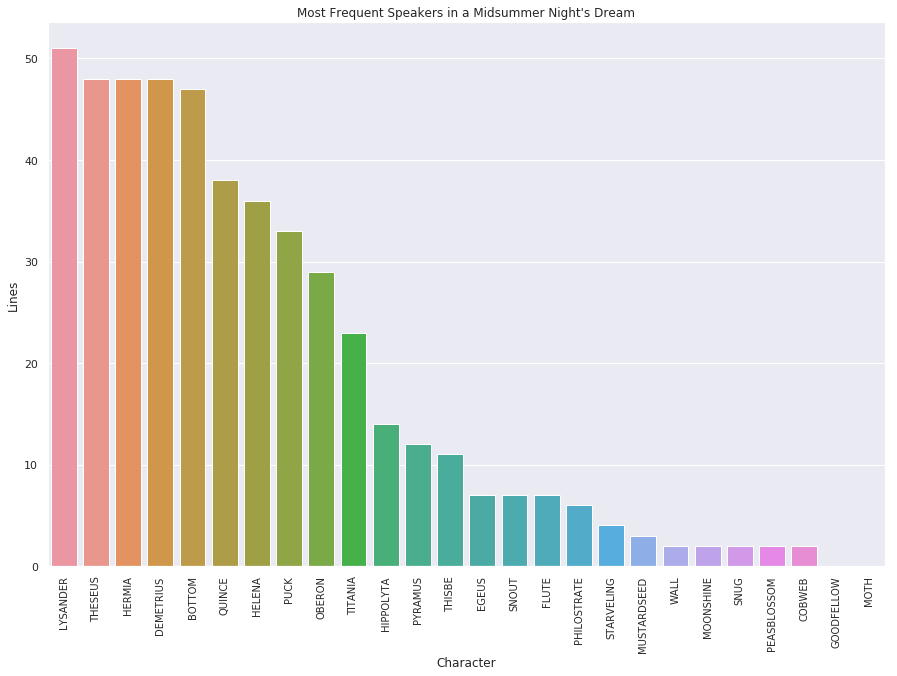

In [75]:
fig = plt.figure(figsize = (15,10))
ax1 = fig.add_subplot(111)
sns.barplot(x = 'Character', y = 'Lines', data=word_freq_play, ax=ax1)
ax1.tick_params(axis='x', which='major', labelsize = 10, labelrotation=90.0)
ax1.set_title("Most Frequent Speakers in a Midsummer Night's Dream")
plt.show()

There is seemingly a break after the top 5 characters (Lysander to Bottom). The play mainly concerns Lysander, Theseus, Demetrius, Hermia, and Bottom. The next 5 (Quince, Helena, Puck, Oberon, Titania) also have fairly prominent roles, but after Hippolyta the characters are largely irrelevant. 

These results are perhaps surprising, given Helena is one of the 2 main love interests in the play, and Puck is the key 'mischiefmaker' in the play - causing Lysander and Demetrius both to fall out of love with Hermia (as the play starts) and into love with Helena. Furthermore turning Bottom's head into a donkey's, and making Queen of the fairies Titania fall in love with him. 

In the following analysis, we will chart these 2 groups separately. First, let us extract these characters

In [76]:
group1 = list(word_freq_play.iloc[0:5].loc[:, 'Character']) #  5 most frequent
group2 = list(word_freq_play.iloc[5:10].loc[:, 'Character']) # 6-10 most frequent. 

In [77]:
# Get how many lines each character has by scene.
char_counts = msnd_df.loc[:, 'Text'].apply(lambda row: char_count(row, midsum_char_list))
char_freq_df = convert_to_df(char_counts)
char_freq_df = pd.merge(msnd_df, char_freq_df, left_index=True, right_index=True)

# Only keep characters of interest, and part of play
char_freq_df = char_freq_df.loc[:, ['Part_of_Play']+group1+group2]

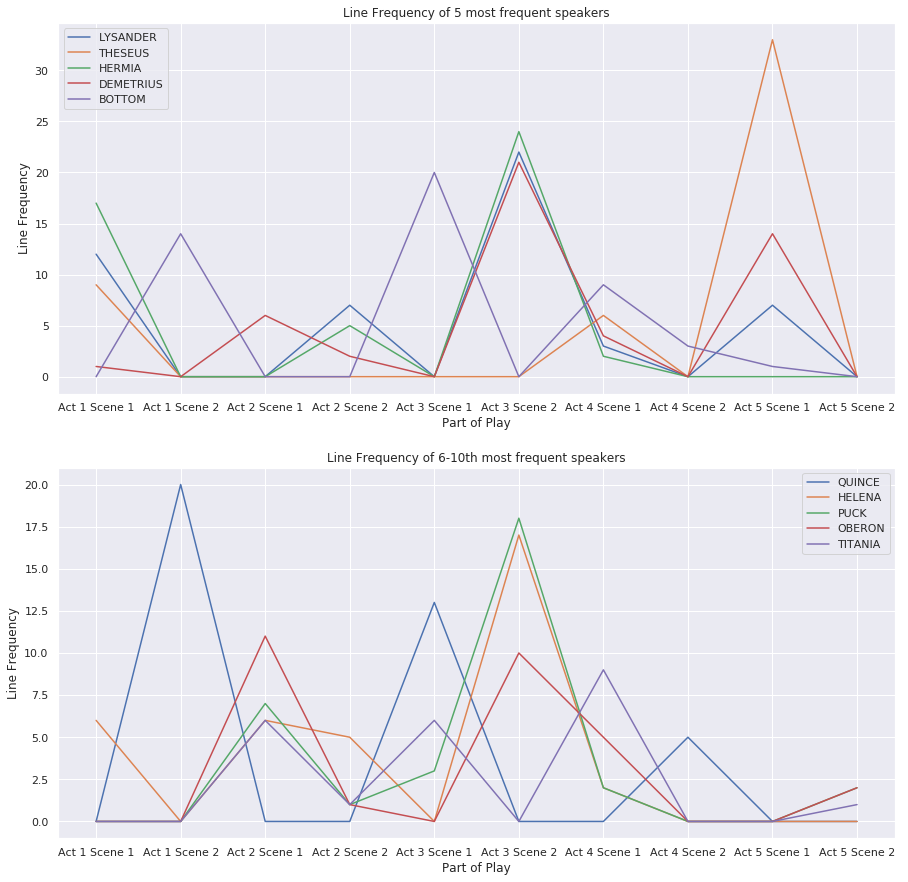

In [78]:
# Set up subplots
fig = plt.figure(figsize=(15,15))
ax1 = fig.add_subplot('211')
ax2 = fig.add_subplot('212')

# Plot line for each character in the popular groups
act_scene = char_freq_df.loc[:, 'Part_of_Play']
for char_index, char in enumerate(group1):
    character_1 = group1[char_index]
    character_2 = group2[char_index]
    sns.lineplot(x = act_scene, y = character_1, data=char_freq_df, label = character_1, ax = ax1)
    sns.lineplot(x = act_scene, y = character_2, data=char_freq_df, label = character_2, ax = ax2)
    
# Label axes
ax1.set_xlabel('Part of Play')
ax1.set_ylabel('Line Frequency')
ax1.set_title('Line Frequency of 5 most frequent speakers')
ax2.set_xlabel('Part of Play')
ax2.set_ylabel('Line Frequency')
ax2.set_title('Line Frequency of 6-10th most frequent speakers')

plt.show()
    
    

Given the above plot, it does not appear as if any character was a consistent speaker throughout the play. In fact, we can see from the dataframe (msnd_df) that despite Theseus being the 2nd most frequent speaker, he only speaks in 3 scenes due to being a key part in the penultimate scene. It could perhaps be that as the Duke, the penultimate scene is likely to be a summary of the play's events, spoken by Theseus as the ruler of the land in which the tale takes place. 

The above also shows which charaacter speaks the most in which scene (considering only the top 10). 

### Most Common Words

In [79]:
# Convert characters to lower case so mentions are removed
characters = [word.lower() for word in midsum_char_list]
# Get dataframe of most common words, then reset index, rename columns, sort
word_df = word_counter(mid_body, stopwords=stopwords+characters)
word_df.reset_index(inplace=True)
word_df.columns = ['Word', 'Count']
word_df.sort_values(by = 'Count', ascending=False, inplace=True)
# Add column to show if word is positive, negative or neutral
word_df['Positivity'] = word_df.apply(lambda row: classifier(row.loc['Word'], pos_words, neg_words), axis = 1)

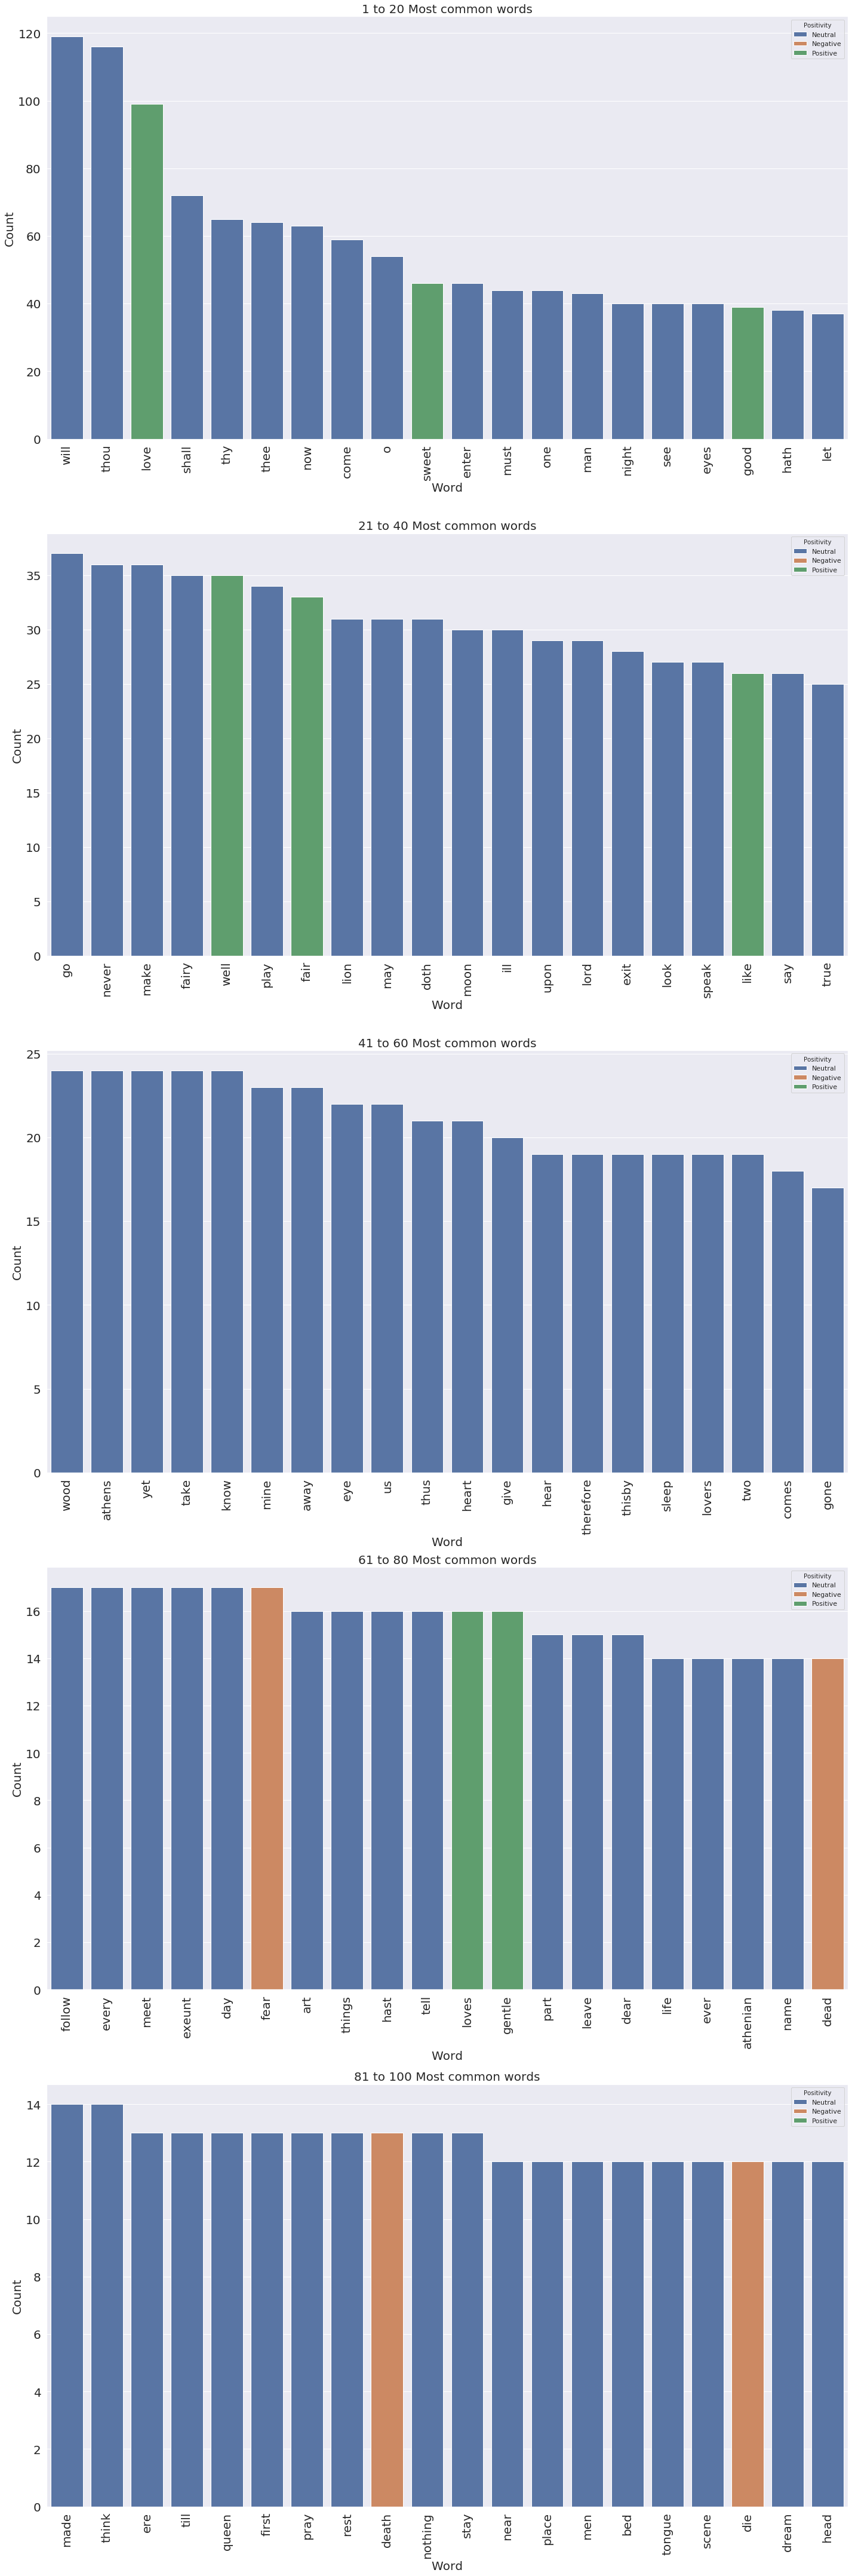

In [80]:
fig = plt.figure(figsize = (20, 60))

# How many of most common words to get
num_most_common = 100
# Get them in sets of this size
set_size = 20
# number of subplots (must ensure this is an integer)
subplots = num_most_common/set_size

for subplot_index, lower_index in enumerate(range(0, num_most_common, set_size)):
    subplot = subplot_index + 1
    upper_index = lower_index + set_size
    ax = fig.add_subplot(subplots, 1, subplot)
    filt_data = word_df.iloc[lower_index:upper_index]
    # dodge avoids the hue argument shifting the bars around (hue normally used for an extra dimension such as month, as seen
    # in Task 1). 
    # hue_order keeps the colours consistent. 
    # hue colours bars based on their classification as positive, negative, or neutral. 
    sns.barplot(x =  'Word', y = 'Count', hue = 'Positivity', data = filt_data, dodge=False,
                hue_order = ['Neutral', 'Negative', 'Positive'])
    ax.tick_params(axis = 'x', which = 'major', labelsize = 20, labelrotation = 90)
    ax.tick_params(axis = 'y', which = 'major', labelsize = 20)
    ax.set_xlabel('Word', fontsize = 20)
    ax.set_ylabel('Count', fontsize = 20)
    # 'Real life' indexing starts at 1, - most common word at index 0 etc. 
    ax.set_title(f'{lower_index + 1} to {upper_index} Most common words', fontsize = 20)

plt.tight_layout()
plt.show()

In this play, considering the top 100 words, Shakespeare used positive words much more frequently, with negative words not even breaking into the top 50. This suggests early on that the play will be largely positive. However, 3 of the 4 negative words revolve around death, which could indicate some very negative instances in the play, or allusions to murder. 

### Sentiment

#### Net Positivity

In [81]:
# This gets the net positivity of MSND and how it is distributed between positive and negative

net_positivity(mid_body, pos_words, neg_words, words = False, dist = True)

{'Net Positivity': 95, 'Positivity': 755, 'Negativity': 660}

Applying this to each column, and merging with the original dataframe

In [82]:
# Apply net positivity to each scene
pos_series = msnd_df.loc[:, 'Text'].apply(lambda row: net_positivity(row, pos_words, neg_words, words=False, dist=True))
# convert to dataframe
pos_df = convert_to_df(pos_series)
# merge with original
msnd_df_pos = pd.merge(msnd_df, pos_df, left_index=True, right_index=True)

For aesthetic reasons (negative bar going downwards), make the negativity measure numbers negative. At the moment it is a count of negative words, we now convert it to a score of net positivity. 

In [83]:
msnd_df_pos.loc[:, 'Negativity'] = -msnd_df_pos.loc[:, 'Negativity']

Now, plot the net positivity over each scene

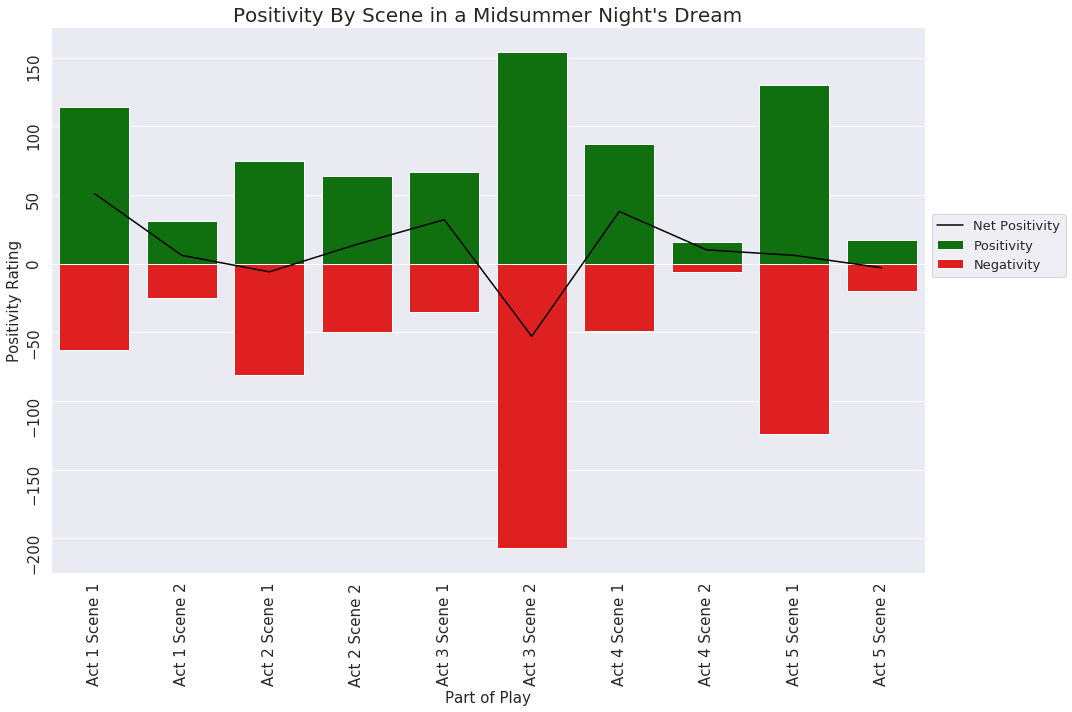

In [84]:
sns.set_style('darkgrid')

# Parameters
figsize_input = (15,10)
title_size = 20
xlabel_size = 15
ylabel_size = 15
tick_size = 15
legend_size = 13


# Set up figure
fig = plt.figure(figsize = figsize_input)
ax1 = fig.add_subplot(111)




# Plot
# make negativity count negative to display more easily. 
ax1.plot(msnd_df_pos.loc[:,'Net Positivity'], label = 'Net Positivity', color = 'black')
sns.barplot('Part_of_Play', 'Positivity', data = msnd_df_pos, ax = ax1, color = 'green', label = 'Positivity')
sns.barplot('Part_of_Play', 'Negativity', data = msnd_df_pos, ax = ax1, color = 'red', label = 'Negativity')


#Style

ax1.set_title('Positivity By Scene in a Midsummer Night\'s Dream', fontsize = title_size)
ax1.legend(loc = 'center left', bbox_to_anchor=(1,0.6),prop = {'size': legend_size})
ax1.set_xlabel('Part of Play', fontsize = xlabel_size)
ax1.set_ylabel('Positivity Rating', fontsize = ylabel_size)
ax1.tick_params(axis = 'both', labelsize = tick_size, labelrotation = 90)

plt.tight_layout()
plt.show()

As you would expect from a comedy play, most of the scenes are positive, and 2 of the negative scenes can be seen to be neutral (the final scene, and the 3rd scene), as they are hardly negative at all. However the other scene has the greatest magnitude in net positivity (it is more negative than any others are positive). This seems to fit with what happens in the scene, as this is after Puck has caused both Lysander and Demetrius to love Helena. She believes both are making fun of her, as both were chasing Hermia earlier in the play. Helena is angry, and argues with Hermia, while Lysander and Demetrius leave to try and duel as Puck attempts to prevent it. Though comedy is still in the scene, there is a clear negative tone due to the confusion and anger of Helena, and Shakespeare may have been trying to convey with his words that the situation is more tragic than funny. 

Extending this idea of net positivity, we can look at how the positivity changes word by word. That is, we can look at the cumulative positivity throughout the play, instead of just scene by scene.

In [85]:
# Use user-defined cumulative_positivity function, and convert to dataframe. Get total pos and neg
# Use index as the word count, add 1 to index for this. 
cum_pos_df = pd.DataFrame(cumulative_positivity(mid_body, pos_words, neg_words, totals=True))
cum_pos_df.reset_index(inplace=True)
cum_pos_df.columns = ['Word Count', 'Word', 'Net Positivity', 'Total Positivity', 'Total Negativity']
cum_pos_df.loc[:, 'Word Count'] += 1

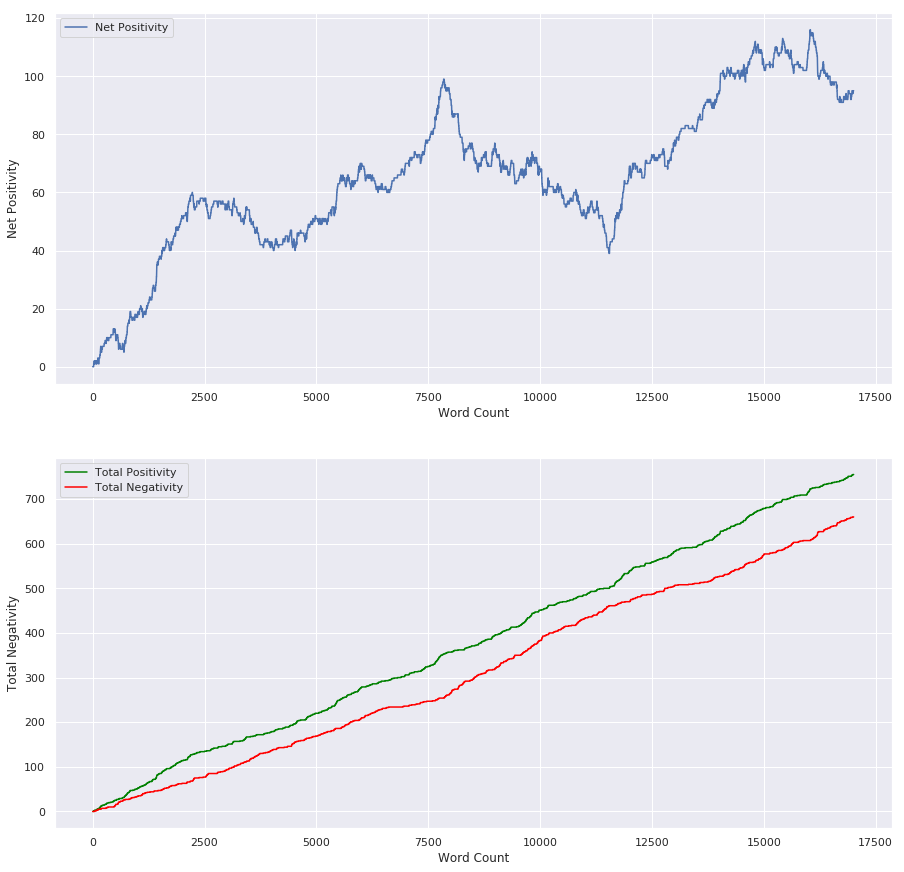

In [86]:
# Plot net positivty, total positivity, and total negativity word by word
fig = plt.figure(figsize = (15, 15))
ax1 = fig.add_subplot('211')
ax2 = fig.add_subplot('212')



sns.lineplot(x = cum_pos_df.loc[:, 'Word Count'], y = cum_pos_df.loc[:, 'Net Positivity'], ax=ax1, label = 'Net Positivity')
sns.lineplot(x = cum_pos_df.loc[:, 'Word Count'], y = cum_pos_df.loc[:, 'Total Positivity'], ax=ax2, color='Green', label = 'Total Positivity')
sns.lineplot(x = cum_pos_df.loc[:, 'Word Count'], y = cum_pos_df.loc[:, 'Total Negativity'], ax=ax2, color='Red',   label = 'Total Negativity')


Both positivity and negativity seem to rise gradually, however looking at the net positivity graph we can see there are clearly spikes and dips in the net positivity. Between 5000 and 7500, there is a huge dip in the net positivity, which likely corresponds to scene 6. We can test this out by finding the length of each scene.

In [87]:
# Get length of each scene
scene_len =  (msnd_df.loc[:, 'Text'].apply(lambda row: len(row.split())))
# Add 1 to index so we can match up more
scene_len.index += 1
# Cumulative sum, so we know where each scene ends. 
scene_len_cum = pd.Series(np.cumsum(scene_len))
#sns.wat(x = scene_len_cum.index, y = scene_len_cum)
end_point_list = list(scene_len_cum)

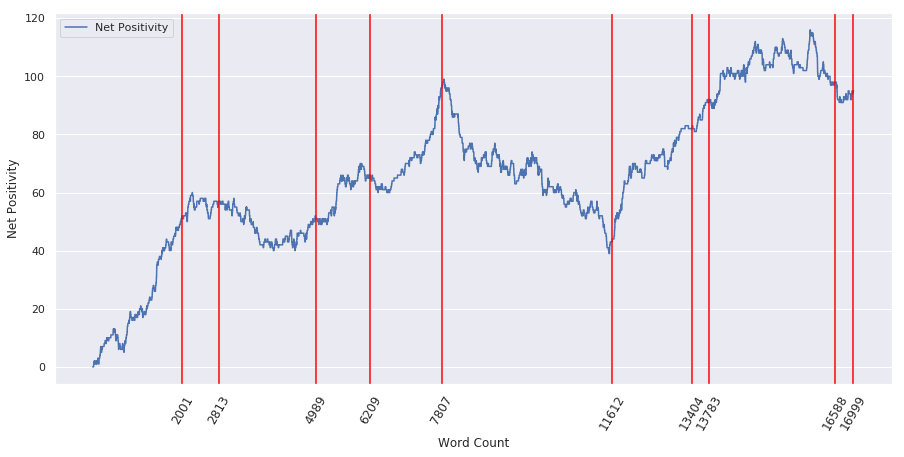

In [88]:
# Plot recreation
fig = plt.figure(figsize = (15, 15))
ax1 = fig.add_subplot('211')
sns.lineplot(x = cum_pos_df.loc[:, 'Word Count'], y = cum_pos_df.loc[:, 'Net Positivity'], ax=ax1, label = 'Net Positivity')
# Vertical lines
for x_point in end_point_list:
    ax1.axvline(x = x_point, color='red')

ax1.set_xticks(end_point_list)
ax1.tick_params(axis='x', labelsize = 12, labelrotation=60)
plt.show()

The red lines show the end of a scene. So 2001 is the end of the first scene. 7807 is the end of the 5th scene, so we can see that scene 6 starts off incredibly negatively, with very few positivewords, and then trends downwards until scene 7 when the tone picks up again rapidly. In fact scenes 7 and 8, though small, almost completely overhaul the positivity loss caused in scene 6. It also shows that, as suspected, scene 6 is the largest.  

#### Chain Positivity

In a crude attempt to account for context, this measure of positivity negatively weights a word if it is 'out of context'. For example if the previous 50 words were generally negative, a sudden positive word could be being used in a negative light (as we will see later in Romeo and Juliet). 

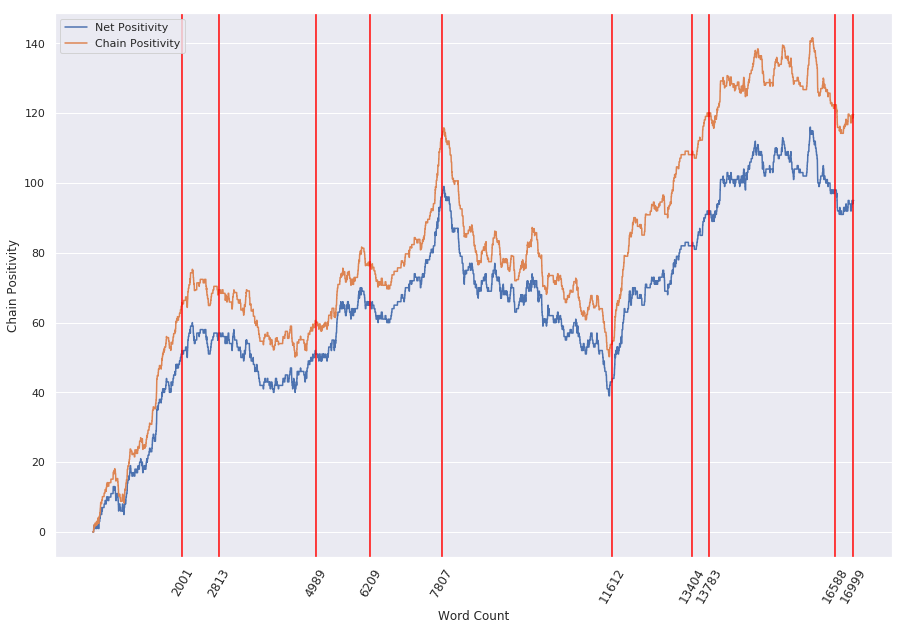

In [89]:
# Use user-defined cumulative_positivity function, and convert to dataframe. Get total pos and neg
# Use index as the word count, add 1 to index for this. 
cha_pos_df = pd.DataFrame(chain_positivity(mid_body, pos_words, neg_words, n=50))
cha_pos_df.reset_index(inplace=True)
cha_pos_df.columns = ['Word Count', 'Word', 'Chain Positivity']
cha_pos_df.loc[:, 'Word Count'] += 1

fig = plt.figure(figsize = (15, 10))
ax1 = fig.add_subplot('111')


sns.lineplot(x = cum_pos_df.loc[:, 'Word Count'], y = cum_pos_df.loc[:, 'Net Positivity'], ax=ax1, label = 'Net Positivity')
sns.lineplot(x = cha_pos_df.loc[:, 'Word Count'], y = cha_pos_df.loc[:, 'Chain Positivity'], ax=ax1, label = 'Chain Positivity')
for x_point in end_point_list:
    ax1.axvline(x = x_point, color='red')

    
ax1.set_xticks(end_point_list)
ax1.tick_params(axis='x', labelsize = 12, labelrotation=60)

Applying this measure has shifted the graph upwards, suggesting a higher level of positivity than considered when giving each word an equal weighting. This graph is shifted up more, as n (number of previous words considered) increases. 

## Romeo And Juliet

Now let us move onto Shakespeare's (arguably) most popular work, 'Romeo and Juliet'. The play is a tragedy, with both the titular characters committing suicide at the very end, with numerous deaths throughout and very little comedy. Given this, we would hope that applying positivity functions to the play should yield that the play is extremely negative.  

### Load Play from Project Gutenberg, Clean

In [90]:
url = 'http://www.gutenberg.org/files/1513/1513-0.txt'
start = 'Dramatis'
end = 'End of the Project Gutenberg EBook of Romeo and Juliet'

romeo_txt = open_gutenberg(url, start_mark=start, end_mark=end, url=True)

# Remove punctuation
remove = remove_chars(str_punctuation, ',')
romeo_txt = remove_chars(romeo_txt, remove)
# romeo text has carriage returns as well as newlines, replace returns with newlines now
# to avoid issues with functions and counting in future. 
romeo_txt = romeo_txt.replace('\r', '\n')

#### Break into acts and Scenes

In [91]:
break_pattern = 'ACT [IV]+'

romeo_acts_inc_preamble = split_keep(break_pattern, romeo_txt, preamble = True)
preamble = romeo_acts_inc_preamble[0]
romeo_acts = romeo_acts_inc_preamble[1:]

# remove commas from midsummer text
romeo_acts = [remove_chars(act, ',') for act in romeo_acts]

# Create main body of text
romeo_body = ' '.join(romeo_acts).strip()

# Scenes
romeo_act_split_scenes = [split_keep('SCENE [IVX]+', act, preamble=False) for act in romeo_acts]

#### Charcters from Preamble

In [92]:
# Get characters
romeo_char_list = re.findall("[A-Z ’]+,", preamble)
# Remove comma
romeo_char_list = [remove_chars(word, ',') for word in romeo_char_list]
romeo_char_list = set(romeo_char_list)
#print(preamble)

#### Dataframe

In [93]:
romeo_df = acts_scenes_to_df(romeo_act_split_scenes)
act_and_scene(romeo_df)
# Reorder columns
romeo_df = romeo_df.loc[:, ['Part_of_Play', 'Act', 'Scene', 'Text']]

## Analysis of Romeo and Juliet

### Main Characters

In [94]:
# looking at raw text, new lines denoted by \n, after we replaced \r with \n
word_freq_play = pd.DataFrame.from_dict((char_count(romeo_body, romeo_char_list, '\n')), orient='index')
word_freq_play.reset_index(inplace=True)
word_freq_play.columns = ['Character', 'Lines']
word_freq_play.sort_values('Lines', ascending=False, inplace=True)

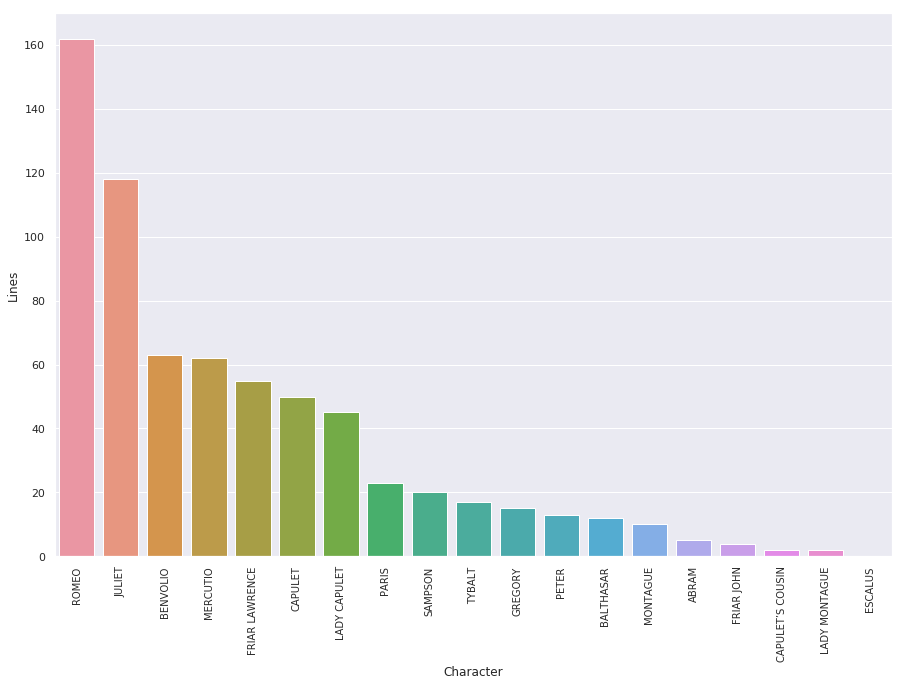

In [95]:
fig = plt.figure(figsize = (15,10))
ax1 = fig.add_subplot(111)
sns.barplot(x = 'Character', y = 'Lines', data=word_freq_play, ax=ax1)
ax1.tick_params(axis='x', which='major', labelsize = 10, labelrotation=90.0)

As expected, Romeo and Juliet speak the most and by far. This is in contrast to a MSND, where there are 5 characters ahead of the rest, and even then the gap between the top 5 and the next 5 is not as significant as the gap between Juliet and Benvolio.  

As previously done, let us plot when each of the top 10 characters spoke, with equally sized groups. 

In [96]:
# Extract characters
group1 = list(word_freq_play.iloc[0:5].loc[:, 'Character']) #  5 most frequent
group2 = list(word_freq_play.iloc[5:10].loc[:, 'Character']) # 6-10 most frequent. 

# Get how many lines each character has by scene.
char_counts = romeo_df.loc[:, 'Text'].apply(lambda row: char_count(row, romeo_char_list))
char_freq_df = convert_to_df(char_counts)
char_freq_df = pd.merge(romeo_df, char_freq_df, left_index=True, right_index=True)

# Only keep characters of interest, and part of play
char_freq_df = char_freq_df.loc[:, ['Part_of_Play']+group1+group2]

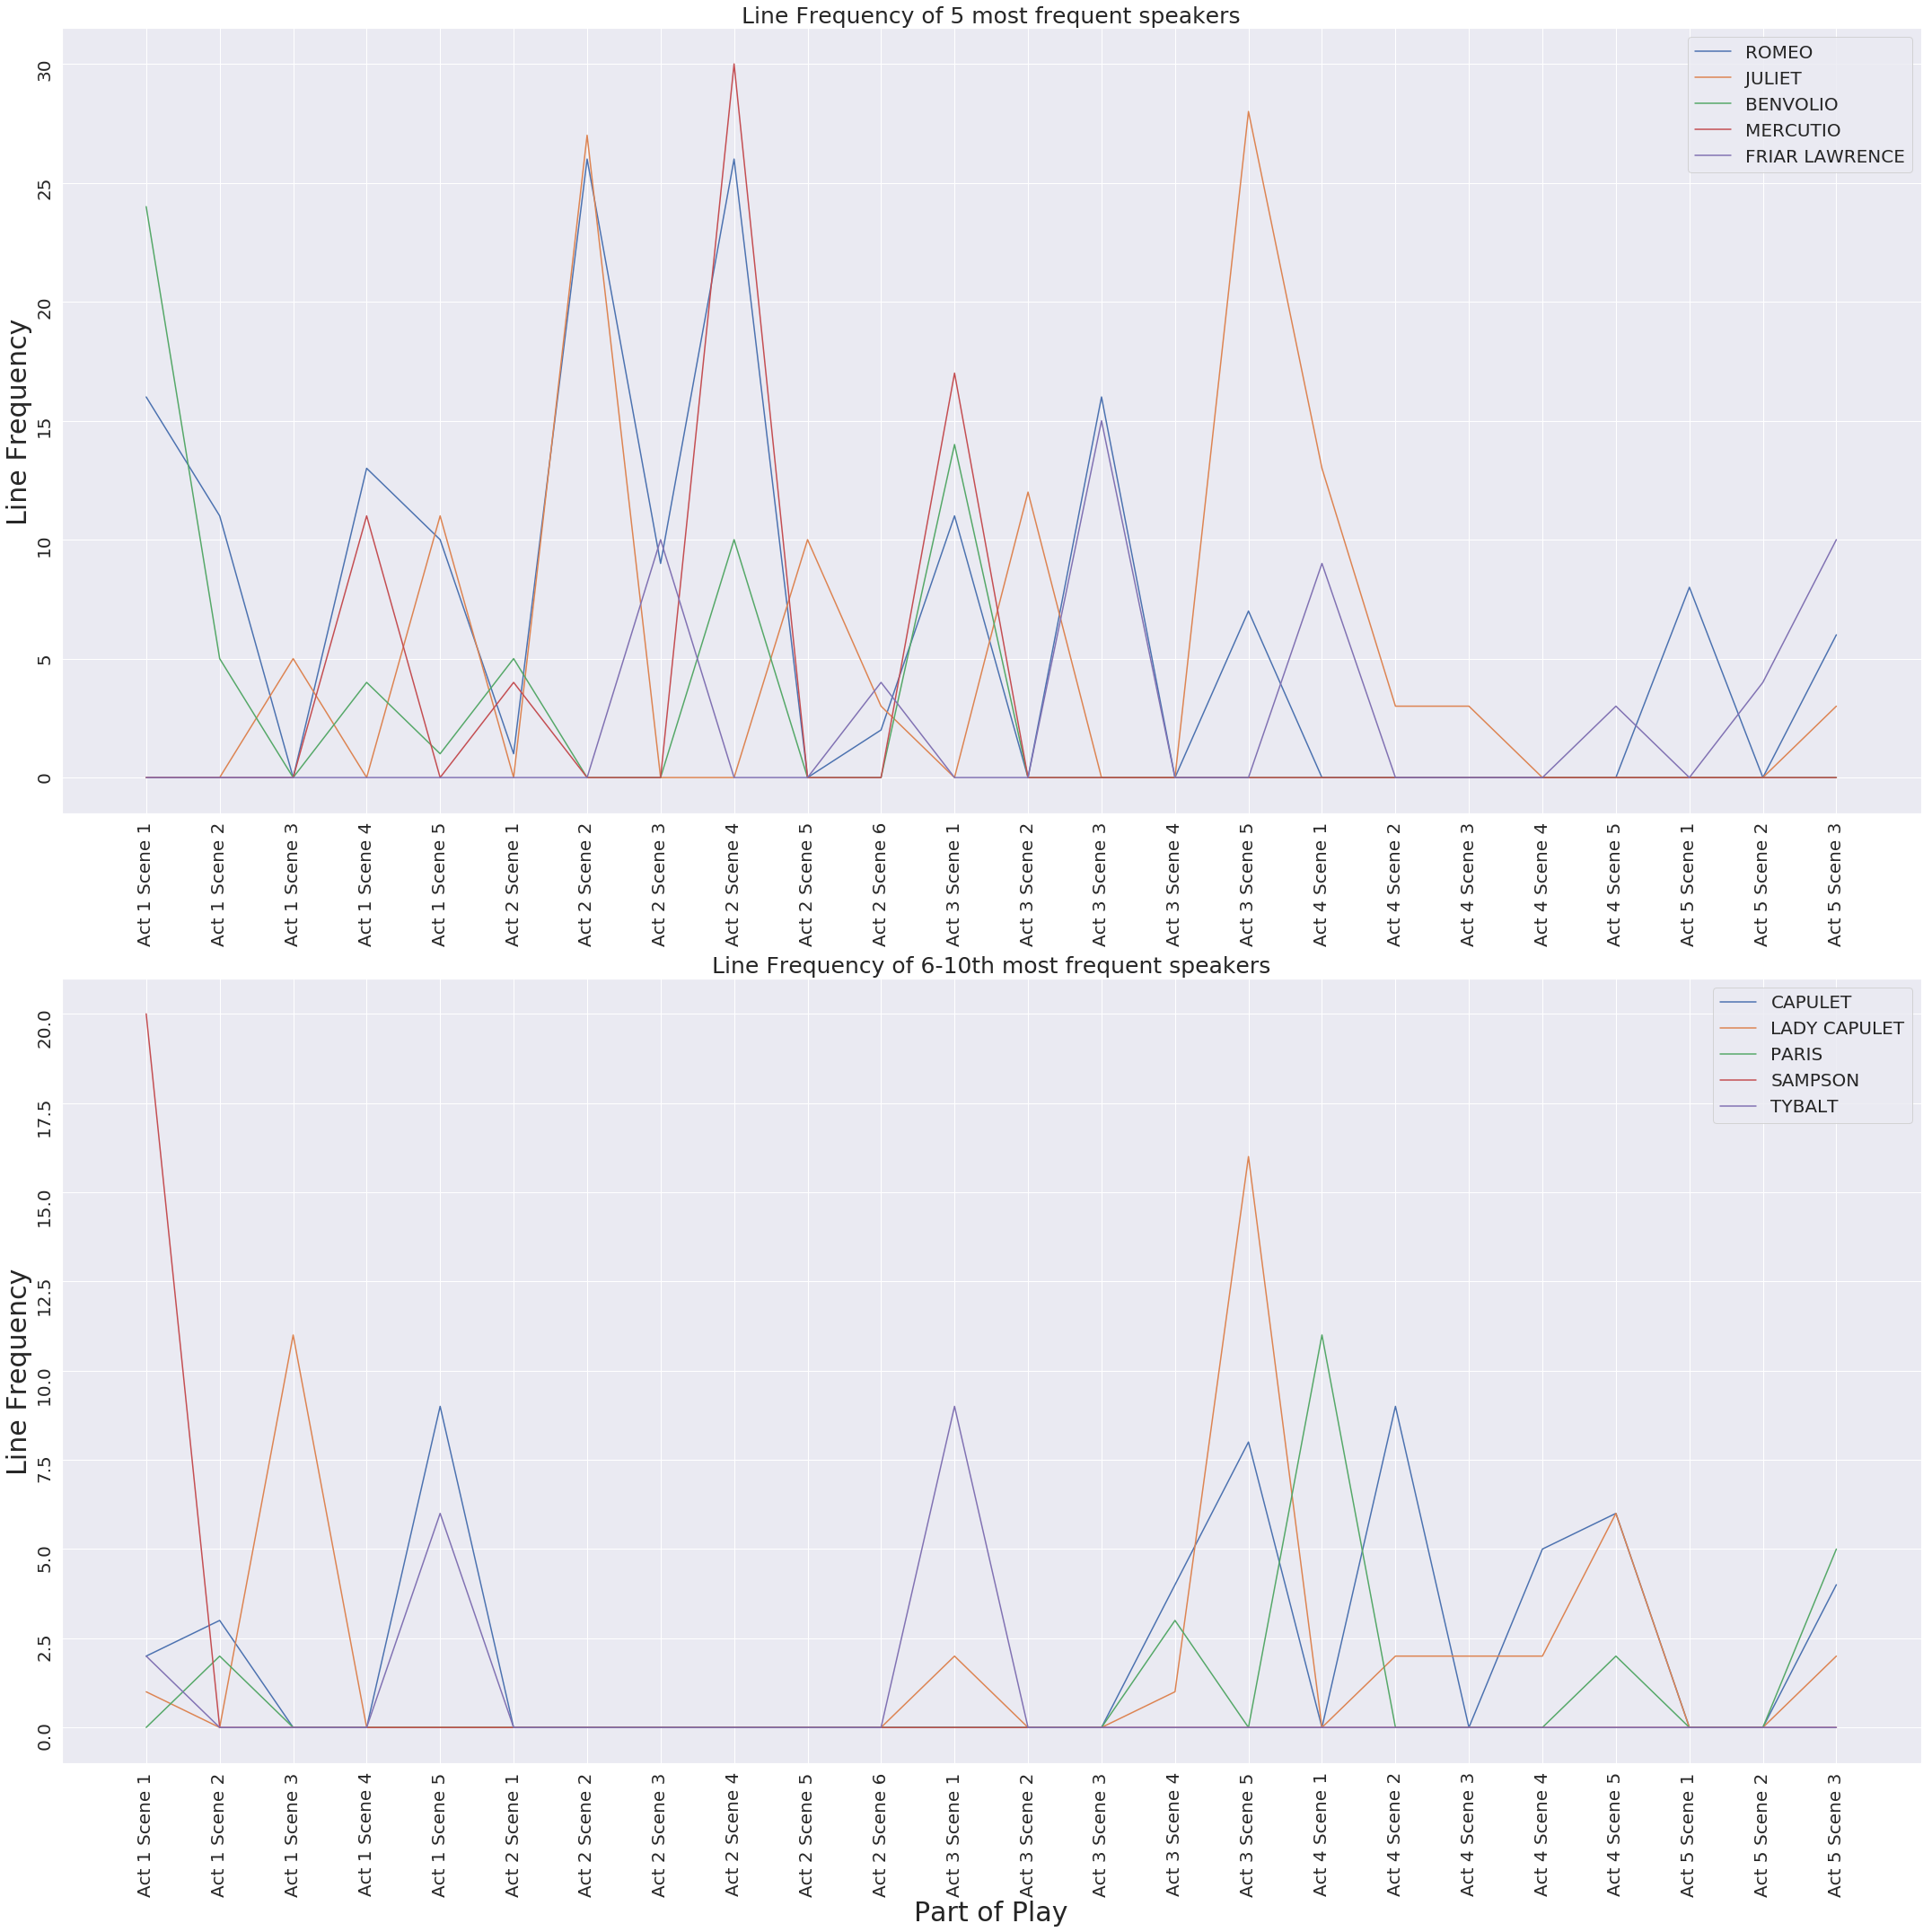

In [97]:
# Set up subplots
fig = plt.figure(figsize=(30,30))
ax1 = fig.add_subplot('211')
ax2 = fig.add_subplot('212')

# Plot line for each character in the popular groups
act_scene = char_freq_df.loc[:, 'Part_of_Play']
for char_index, char in enumerate(group1):
    character_1 = group1[char_index]
    character_2 = group2[char_index]
    sns.lineplot(x = act_scene, y = character_1, data=char_freq_df, label = character_1, ax = ax1)
    sns.lineplot(x = act_scene, y = character_2, data=char_freq_df, label = character_2, ax = ax2)
    
# Label axes
ax1.set_xlabel('')
ax1.set_ylabel('Line Frequency', fontsize = 30)
ax1.set_title('Line Frequency of 5 most frequent speakers', fontsize = 25)
ax1.tick_params(labelrotation = 90, labelsize = 20)
ax1.legend(prop = {'size':20})

ax2.set_xlabel('Part of Play', fontsize = 30)
ax2.set_ylabel('Line Frequency', fontsize = 30)
ax2.set_title('Line Frequency of 6-10th most frequent speakers', fontsize = 25)
ax2.tick_params(labelrotation = 90, labelsize = 20)
ax2.legend(prop = {'size':20})


plt.tight_layout()
plt.show()
    
    

### Most Common Words

In [98]:
characters = [word.lower() for word in romeo_char_list]
word_df = word_counter(romeo_body, stopwords=stopwords+characters)
word_df.reset_index(inplace=True)
word_df.columns = ['Word', 'Count']
word_df.sort_values(by = 'Count', ascending=False, inplace=True)
# Add column to show if word is positive, negative or neutral
word_df['Positivity'] = word_df.apply(lambda row: classifier(row.loc['Word'], pos_words, neg_words), axis = 1)

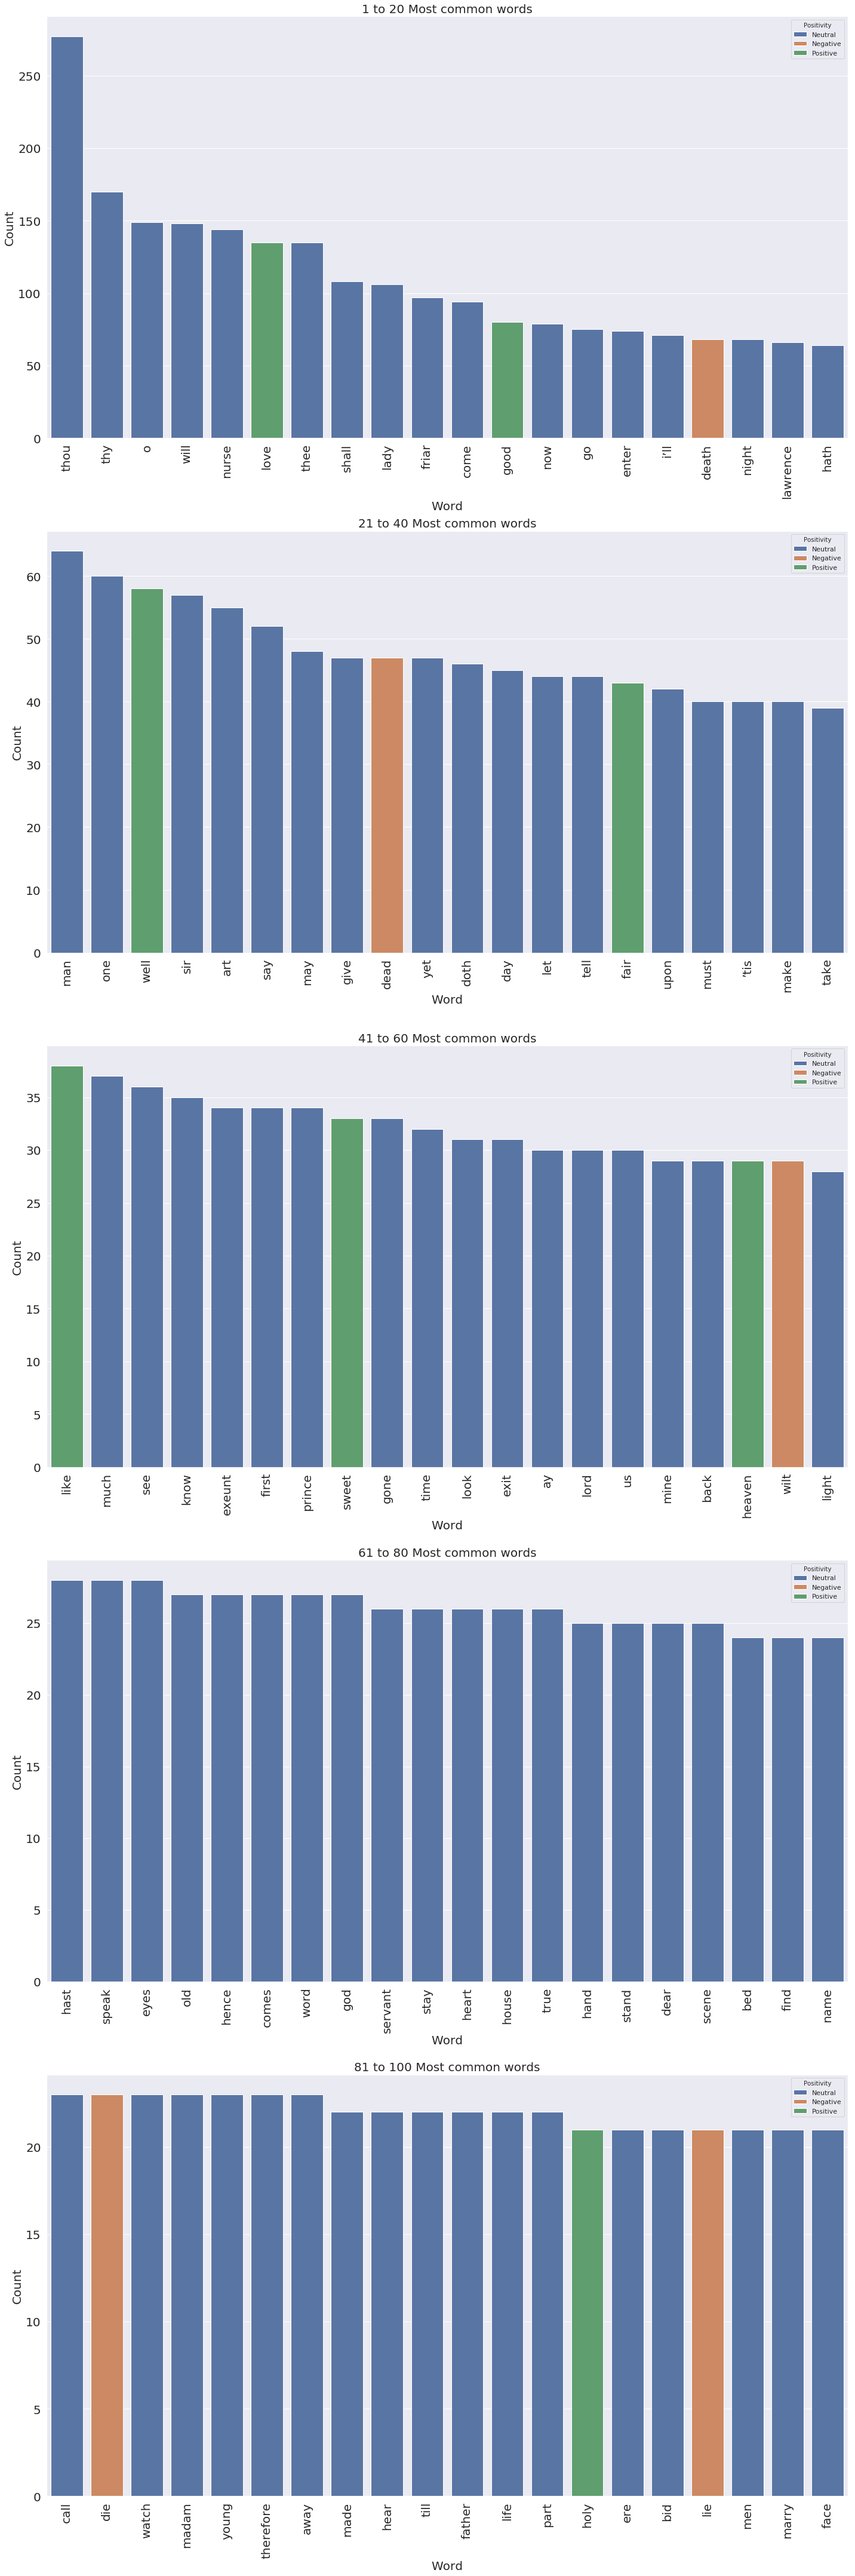

In [99]:
fig = plt.figure(figsize = (20, 60))

# How many of most common words to get
num_most_common = 100
# Get them in sets of this size
set_size = 20
# number of subplots
subplots = num_most_common/set_size

for subplot_index, lower_index in enumerate(range(0, num_most_common, set_size)):
    subplot = subplot_index + 1
    upper_index = lower_index + set_size
    ax = fig.add_subplot(subplots, 1, subplot)
    filt_data = word_df.iloc[lower_index:upper_index]
    # dodge avoids the hue argument shifting the bars around (hue normally used for an extra dimension such as month, as seen
    # in Task 1). 
    # hue_order keeps the colours consistent. 
    sns.barplot(x =  'Word', y = 'Count', hue = 'Positivity', data = filt_data, dodge=False,
                hue_order = ['Neutral', 'Negative', 'Positive'])
    ax.tick_params(axis = 'x', which = 'major', labelsize = 20, labelrotation = 90)
    ax.tick_params(axis = 'y', which = 'major', labelsize = 20)
    ax.set_xlabel('Word', fontsize = 20)
    ax.set_ylabel('Count', fontsize = 20)
    ax.set_title(f'{lower_index + 1} to {upper_index} Most common words', fontsize = 20)

plt.tight_layout()
plt.show()

Surprisingly, even in a tragedy it appears as if Shakespeare mostly used positive words. However, we do not know the context in which they were used. For example, it is commented (prior to Romeo meeting Juliet) that Romeo has 'unrequited love' for Rosaline. Although the use of 'love' is clearly negative in this instance, as it comments on Romeo's pain - this basic classifier still considers it a positive word. It may be the case that Shakespeare often uses positive words in a negative context to draw more attention to the negative tone of the play by contrasting it with the prospect of positivity. That is, the measure falls because it cannot detect context.

### Sentiment

#### Net Positivity

In [100]:
# Apply net positivity to each scene
pos_series = romeo_df.loc[:, 'Text'].apply(lambda row: net_positivity(row, pos_words, neg_words, words = False, dist = True))
# Convert to dataframe
pos_df = convert_to_df(pos_series)
#pos_df = convert_to_df(pos_series)
romeo_df_pos = pd.merge(romeo_df, pos_df, left_index=True, right_index=True)

In [101]:
romeo_df_pos.loc[:, 'Negativity'] = -romeo_df_pos.loc[:, 'Negativity']

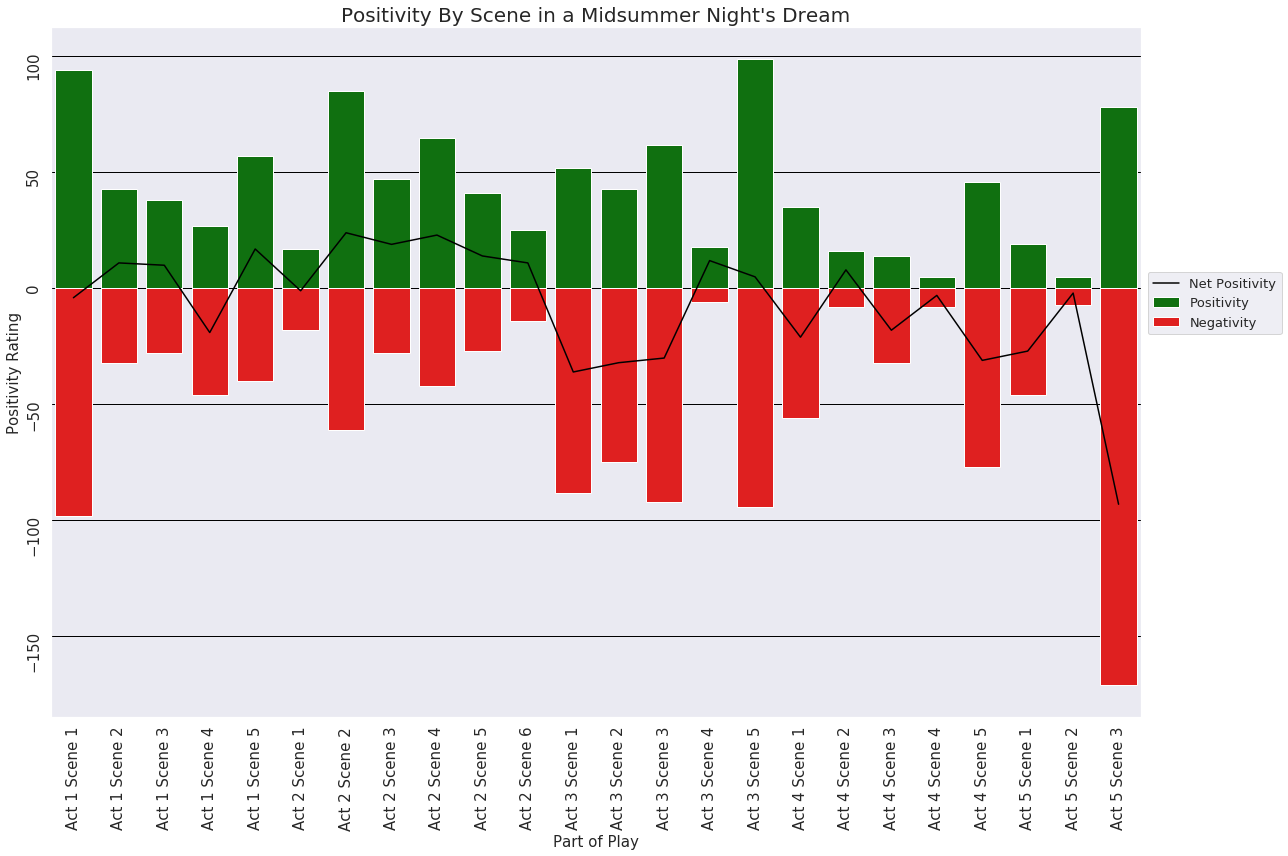

In [102]:
sns.set_style('darkgrid')

# Parameters
figsize_input = (18,12)
title_size = 20
xlabel_size = 15
ylabel_size = 15
tick_size = 15
legend_size = 13


# Set up figure
fig = plt.figure(figsize = figsize_input)
ax1 = fig.add_subplot(111)




# Plot
# make negativity count negative to display more easily. 
ax1.plot(romeo_df_pos.loc[:,'Net Positivity'], label = 'Net Positivity', color = 'black')
sns.barplot('Part_of_Play', 'Positivity', data = romeo_df_pos, ax = ax1, color = 'green', label = 'Positivity')
sns.barplot('Part_of_Play', 'Negativity', data = romeo_df_pos, ax = ax1, color = 'red', label = 'Negativity')


#Style

ax1.set_title('Positivity By Scene in a Midsummer Night\'s Dream', fontsize = title_size)
ax1.legend(loc = 'center left', bbox_to_anchor=(1,0.6),prop = {'size': legend_size})
ax1.set_xlabel('Part of Play', fontsize = xlabel_size)
ax1.set_ylabel('Positivity Rating', fontsize = ylabel_size)
ax1.tick_params(axis = 'both', labelsize = tick_size, labelrotation = 90)
ax1.grid(axis='y', color='black', linestyle='-')


plt.tight_layout()
plt.show()

For a summary of Romeo and Juliet, read here:

http://hudsonshakespeare.org/Shakespeare%20Library/Synopsis/synopsis_romeoandjuliet.htm

We can see that events in the play line up with using net positivity. The first few scenes are relatively timid, and the opening scene is perhaps even quite humorous ("Do you bite your thumb at me?"). In A1S4, we see Romeo's unrequited love for Rosaline is hurting him as he refuses to dance, and says of love - "Too rude, too boisterous; and it pricks like thorn." In this passage we can see, as alluded to earlier, the consistent use of love in a negative manner - artificially boosting the positivity rating. 

In A1S5, as in the link - Romeo notices Juliet, his love for Rosaline (though unrealistically) vanishing. The mutual love between them is immediate. Although they each find out their families are rivals, this does not stop the scene from being positive overall. 

A2S1 is largely a 'nothing' scene, in that virtually nothing happens. Romeo's friends just notice he has gone to see Rosaline. 
A2S2 contains the famous "Wherefore art thou Romeo" line (Read wherefore as 'why' - why must you be a Montague). This is the start of their love truly blossoming. From here until the end of Act 2, each scene is about Romeo and Juliet's love growing, until Scene 6 when the Friar marries them (this is done offstage, but it can be assumed it happens). 

In Act 3, things start to fall apart. Tybalt kills Mercutio, and in return Romeo kills Tybalt. The prince banishes Romeo from Verona as a result, and Juliet learns of her cousin's death (Tybalt), and the banishment of Romeo. Romeo and Juliet both already speak of suicide at the thought of not seeing each other again. 

In act 4, there is hope for a happy ending as Juliet hatches a plan with Friar Lawrence to fake her death. In the last scene of act 4, the Nurse finds Juliet dead, causing the Capulet family to mourn. 

And then in the final scene, we see a huge dip in positivity. Romeo finds Juliet 'dead', monologues, and commits suicide. Then Juliet awakens to find Romeo dead and kills herself. Lady Montague also dies at hearing of her son's death. Paris is also murdered by Romeo. There is a lot of tragedy in this final scene, which is reflected in the metric. 

Let us now again look at positivity word by word

In [103]:
# Use user-defined cumulative_positivity function, and convert to dataframe. Get total pos and neg
# Use index as the word count, add 1 to index for this. 
cum_pos_df = pd.DataFrame(cumulative_positivity(romeo_body, pos_words, neg_words, totals=True))
cum_pos_df.reset_index(inplace=True)
cum_pos_df.columns = ['Word Count', 'Word', 'Net Positivity', 'Total Positivity', 'Total Negativity']
cum_pos_df.loc[:, 'Word Count'] += 1

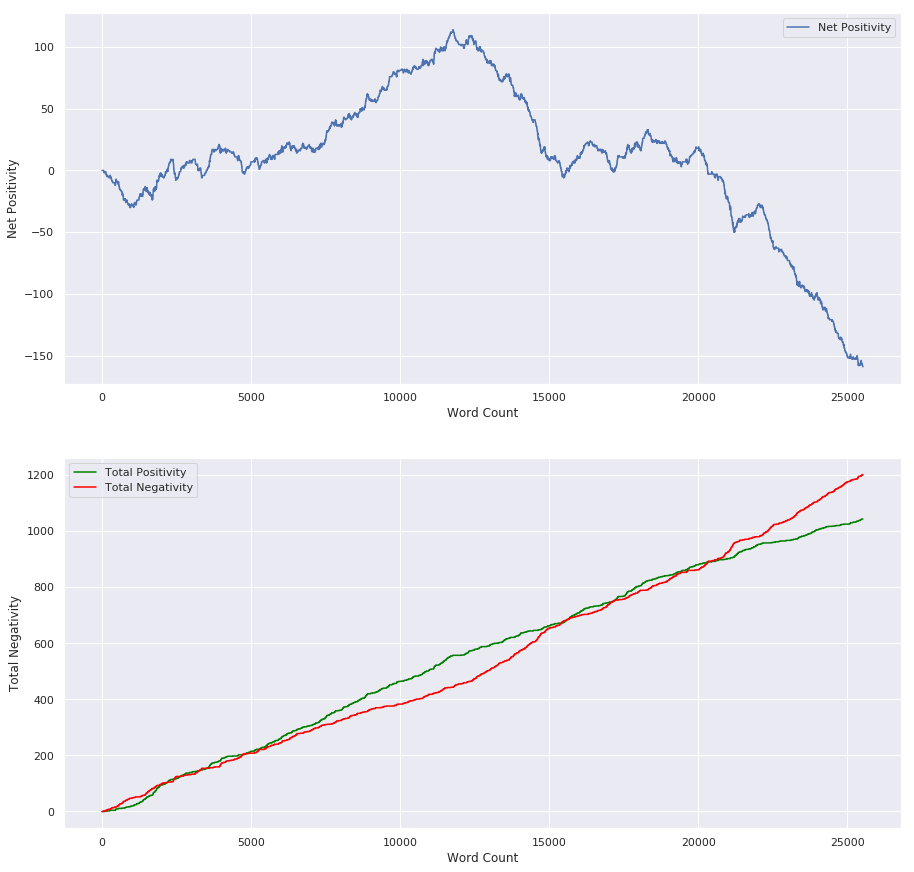

In [104]:
fig = plt.figure(figsize = (15, 15))
ax1 = fig.add_subplot('211')
ax2 = fig.add_subplot('212')



sns.lineplot(x = cum_pos_df.loc[:, 'Word Count'], y = cum_pos_df.loc[:, 'Net Positivity'], ax=ax1, label = 'Net Positivity')
sns.lineplot(x = cum_pos_df.loc[:, 'Word Count'], y = cum_pos_df.loc[:, 'Total Positivity'], ax=ax2, color='Green', label = 'Total Positivity')
sns.lineplot(x = cum_pos_df.loc[:, 'Word Count'], y = cum_pos_df.loc[:, 'Total Negativity'], ax=ax2, color='Red',   label = 'Total Negativity')


Here the pattern is far more satisfying than MSND. We can see a clear breakpoint at around the 12000th word. In fact, the play is very positive up until this point, with a net score of over 100, which MSND does not pass until near the end of the play. As before, let us plot the scene breaks on the above graph

In [105]:
# Get length of each scene
scene_len =  (romeo_df.loc[:, 'Text'].apply(lambda row: len(row.split())))
# Add 1 to index so we can match up more
scene_len.index += 1
# Cumulative sum, so we know where each scene ends. 
scene_len_cum = pd.Series(np.cumsum(scene_len))
#sns.wat(x = scene_len_cum.index, y = scene_len_cum)
end_point_list = list(scene_len_cum)

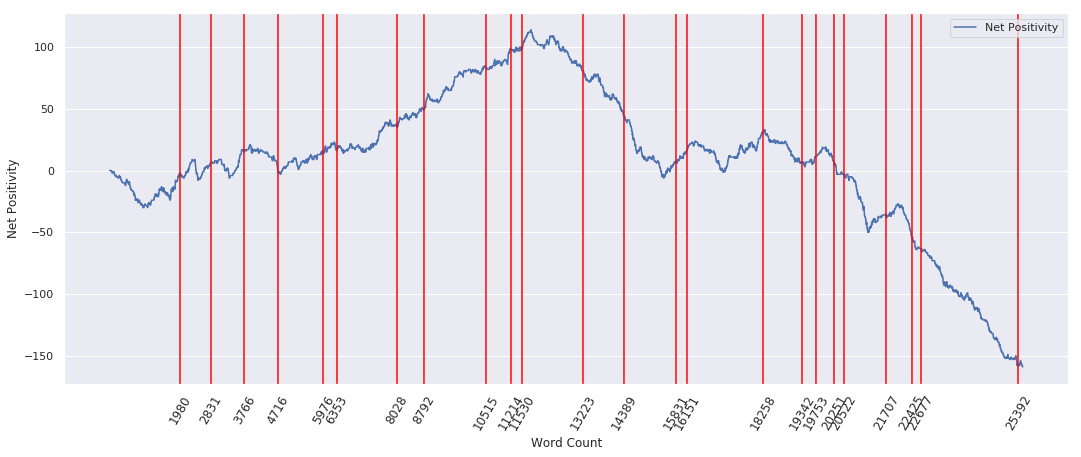

In [106]:
# Plot recreation
fig = plt.figure(figsize = (18, 15))
ax1 = fig.add_subplot('211')
sns.lineplot(x = cum_pos_df.loc[:, 'Word Count'], y = cum_pos_df.loc[:, 'Net Positivity'], ax=ax1, label = 'Net Positivity')
# Vertical lines
for x_point in end_point_list:
    ax1.axvline(x = x_point, color='red')

ax1.set_xticks(end_point_list)
ax1.tick_params(axis='x', labelsize = 12, labelrotation=60)
plt.show()

If we count the lines, we can see the line at 11530 is the end of A2S6, i.e. the start of A3S1, which is where the tragedy starts to set in as described above. It even seems as if Act 3 has a similarly negative gradient to the final scene, by looking at the slope of the cumulative positivity graph after 11500, and in the last segment. 

#### Chain Positivity

Let us now see how extremely negative the chain positivity measure makes Romeo and Juliet

In [107]:
# Use user-defined cumulative_positivity function, and convert to dataframe. Get total pos and neg
# Use index as the word count, add 1 to index for this. 
cha_pos_df = pd.DataFrame(chain_positivity(romeo_body, pos_words, neg_words, n=50))
cha_pos_df.reset_index(inplace=True)
cha_pos_df.columns = ['Word Count', 'Word', 'Chain Positivity']
cha_pos_df.loc[:, 'Word Count'] += 1

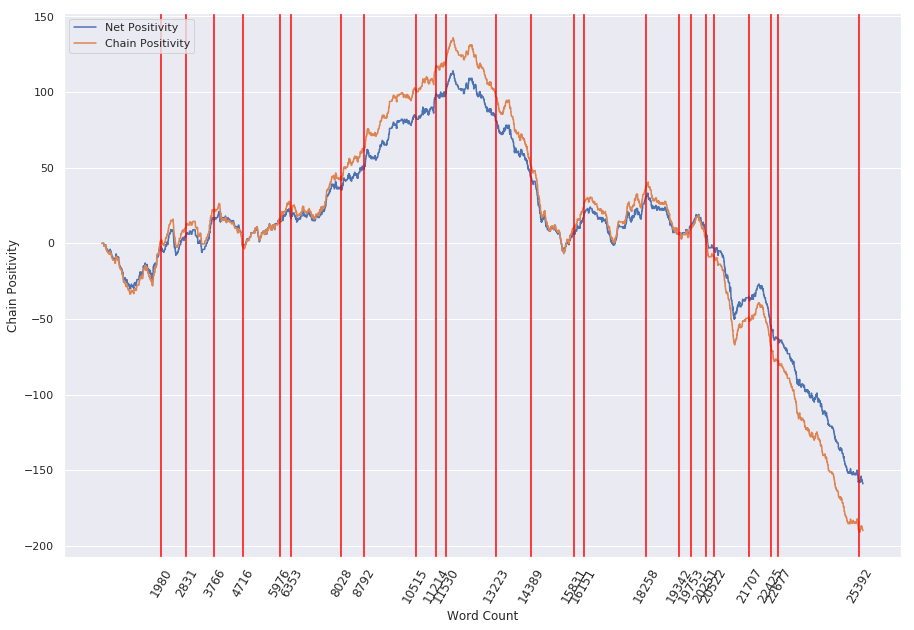

In [108]:
fig = plt.figure(figsize = (15, 10))
ax1 = fig.add_subplot('111')


sns.lineplot(x = cum_pos_df.loc[:, 'Word Count'], y = cum_pos_df.loc[:, 'Net Positivity'], ax=ax1, label = 'Net Positivity')
sns.lineplot(x = cha_pos_df.loc[:, 'Word Count'], y = cha_pos_df.loc[:, 'Chain Positivity'], ax=ax1, label = 'Chain Positivity')
for x_point in end_point_list:
    ax1.axvline(x = x_point, color='red')

    
ax1.set_xticks(end_point_list)
ax1.tick_params(axis='x', labelsize = 12, labelrotation=60)

As before, chain positivity has increased the magnitude of the final classification - it makes Romeo and Juliet more negative, as positive words are given less weight when among negative words. 

# Othello

Othello is considered one of the 4 great tragedies of Shakespeare, so let us see how it compares to Romeo and Juliet

### Downlaod

In [109]:
url = 'http://www.gutenberg.org/cache/epub/1531/pg1531.txt'
start = 'PERSONS REPRESENTED:'
end = 'End of Project Gutenberg Etext'

oth_txt = open_gutenberg(url, start_mark = start, end_mark = end, url = True)

# Remove punctuation
remove = remove_chars(str_punctuation, ',')
oth_txt = remove_chars(oth_txt, remove)
# twelfth_text has carriage returns as well as newlines, replace returns with newlines. 
oth_txt = oth_txt.replace('\r', '\n')

#### Split into Acts and Scenes

In [110]:
break_pattern = 'ACT [IV]+'

oth_acts_inc_preamble = split_keep(break_pattern, oth_txt, preamble = True)
preamble = oth_acts_inc_preamble[0]
oth_acts = oth_acts_inc_preamble[1:]

# remove commas from midsummer text
oth_acts = [remove_chars(act, ',') for act in oth_acts]

# Create main body of text
oth_body = ' '.join(oth_acts).strip()

# Split into scenes
oth_act_split_scenes = [split_keep('SCENE [IVX]+', act, preamble=False) for act in oth_acts]

In [111]:
# CHARACTERS

# Get characters
oth_char_list = re.findall("[A-Z ]+,", preamble) 
# Remove comma
oth_char_list = [remove_chars(word, ',') for word in oth_char_list]
oth_char_list = set(oth_char_list)

In [112]:
# DATAFRAME

oth_df = acts_scenes_to_df(oth_act_split_scenes)
act_and_scene(oth_df)
# Reorder columns
oth_df = oth_df.loc[:, ['Part_of_Play', 'Act', 'Scene', 'Text']]

### Main Characters

In [113]:
# looking at raw text, new lines denoted by \r\n
word_freq_play = pd.DataFrame.from_dict((char_count(oth_body, oth_char_list, '\n')), orient='index')
word_freq_play.reset_index(inplace=True)
word_freq_play.columns = ['Character', 'Lines']
word_freq_play.sort_values('Lines', ascending=False, inplace=True)

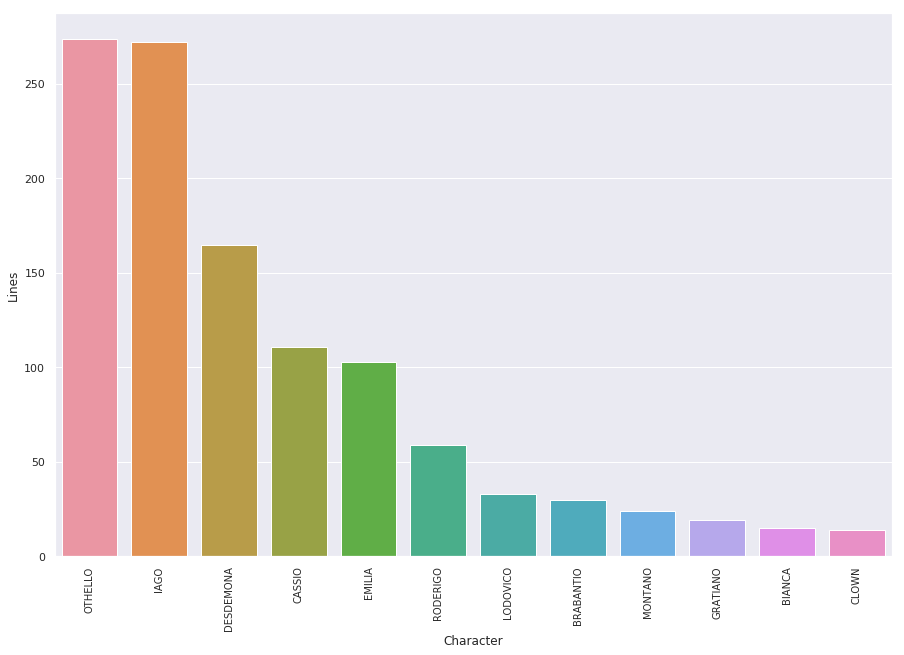

In [114]:
fig = plt.figure(figsize = (15,10))
ax1 = fig.add_subplot(111)
sns.barplot(x = 'Character', y = 'Lines', data=word_freq_play, ax=ax1)
ax1.tick_params(axis='x', which='major', labelsize = 10, labelrotation=90.0)

In [115]:
characters = [word.lower() for word in oth_char_list]
word_df = word_counter(oth_body, stopwords=stopwords+characters)
word_df.reset_index(inplace=True)
word_df.columns = ['Word', 'Count']
word_df.sort_values(by = 'Count', ascending=False, inplace=True)
# Add column to show if word is positive, negative or neutral
word_df['Positivity'] = word_df.apply(lambda row: classifier(row.loc['Word'], pos_words, neg_words), axis = 1)

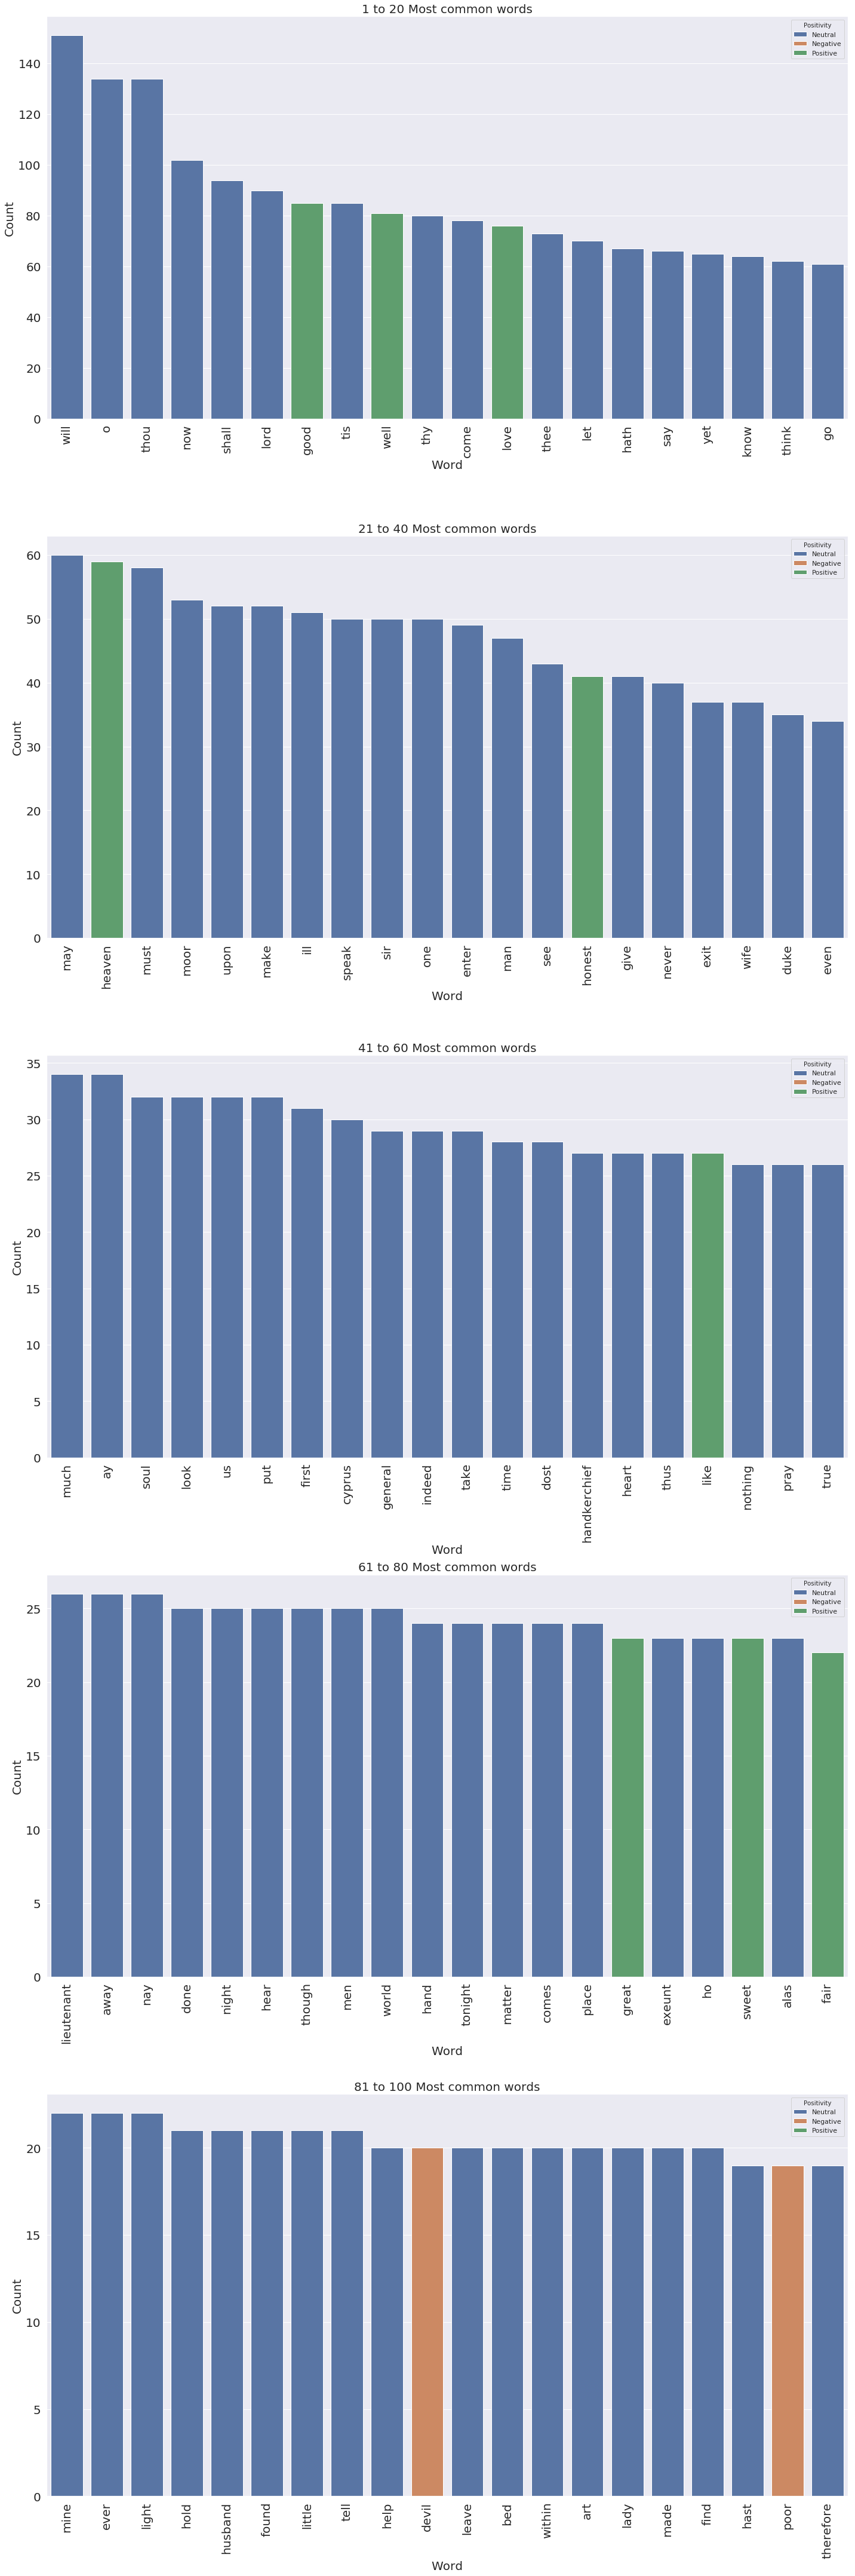

In [116]:
fig = plt.figure(figsize = (20, 60))

# How many of most common words to get
num_most_common = 100
# Get them in sets of this size
set_size = 20
# number of subplots
subplots = num_most_common/set_size

for subplot_index, lower_index in enumerate(range(0, num_most_common, set_size)):
    subplot = subplot_index + 1
    upper_index = lower_index + set_size
    ax = fig.add_subplot(subplots, 1, subplot)
    filt_data = word_df.iloc[lower_index:upper_index]
    # dodge avoids the hue argument shifting the bars around (hue normally used for an extra dimension such as month, as seen
    # in Task 1). 
    # hue_order keeps the colours consistent. 
    sns.barplot(x =  'Word', y = 'Count', hue = 'Positivity', data = filt_data, dodge=False,
                hue_order = ['Neutral', 'Negative', 'Positive'])
    ax.tick_params(axis = 'x', which = 'major', labelsize = 20, labelrotation = 90)
    ax.tick_params(axis = 'y', which = 'major', labelsize = 20)
    ax.set_xlabel('Word', fontsize = 20)
    ax.set_ylabel('Count', fontsize = 20)
    ax.set_title(f'{lower_index + 1} to {upper_index} Most common words', fontsize = 20)

plt.tight_layout()
plt.show()

Again, Shakespeare has used far more positive than negative words when considering the 100 most frequent words. However in Othello, there is surprisingly no mention of death, except for the references to 'heaven'.

In [117]:
# Apply net positivity to each scene
pos_series = oth_df.loc[:, 'Text'].apply(lambda row: net_positivity(row, pos_words, neg_words, words = False, dist = True))
# Convert to dataframe
pos_df = convert_to_df(pos_series)
#pos_df = convert_to_df(pos_series)
oth_df_pos = pd.merge(oth_df, pos_df, left_index=True, right_index=True)

In [118]:
oth_df_pos.loc[:, 'Negativity'] = -oth_df_pos.loc[:, 'Negativity']

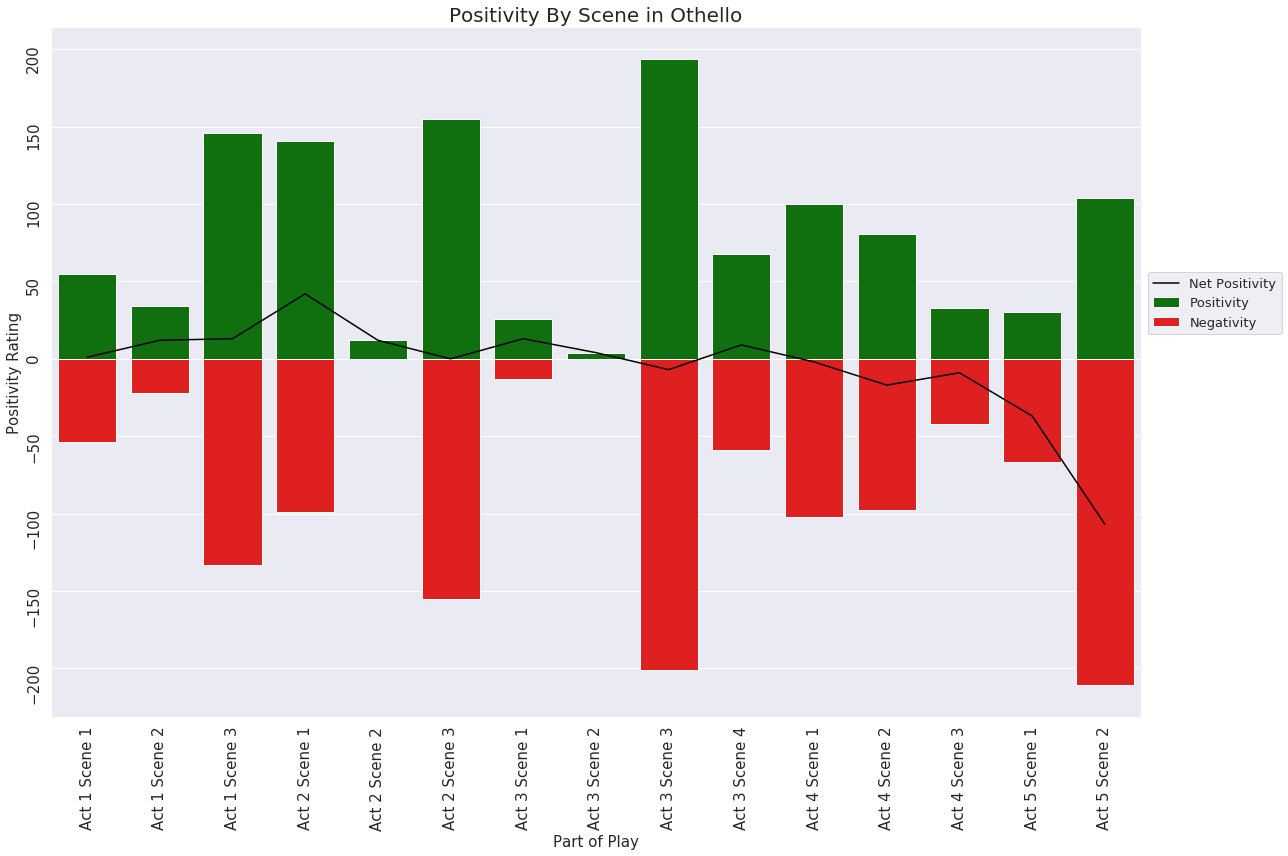

In [119]:
sns.set_style('darkgrid')

# Parameters
figsize_input = (18,12)
title_size = 20
xlabel_size = 15
ylabel_size = 15
tick_size = 15
legend_size = 13


# Set up figure
fig = plt.figure(figsize = figsize_input)
ax1 = fig.add_subplot(111)




# Plot
# make negativity count negative to display more easily. 
ax1.plot(oth_df_pos.loc[:,'Net Positivity'], label = 'Net Positivity', color = 'black')
sns.barplot('Part_of_Play', 'Positivity', data = oth_df_pos, ax = ax1, color = 'green', label = 'Positivity')
sns.barplot('Part_of_Play', 'Negativity', data = oth_df_pos, ax = ax1, color = 'red', label = 'Negativity')


#Style

ax1.set_title('Positivity By Scene in Othello', fontsize = title_size)
ax1.legend(loc = 'center left', bbox_to_anchor=(1,0.6),prop = {'size': legend_size})
ax1.set_xlabel('Part of Play', fontsize = xlabel_size)
ax1.set_ylabel('Positivity Rating', fontsize = ylabel_size)
ax1.tick_params(axis = 'both', labelsize = tick_size, labelrotation = 90)

plt.tight_layout()
plt.show()

In Othello, the play is largely neutral, never straying outside (-50,50) until the final scene. Shakespeare has adopted a very similar method to Romeo and Juliet, where he leaves most of the tragedy for the final scene, when there is a huge spike in negativity. The graph above shows that the final scene has a net positivity of less than -100, which is more tragic than Romeo and Juliet's final scene. 

In [120]:
# Use user-defined cumulative_positivity function, and convert to dataframe. Get total pos and neg
# Use index as the word count, add 1 to index for this. 
cum_pos_df = pd.DataFrame(cumulative_positivity(oth_body, pos_words, neg_words, totals=True))
cum_pos_df.reset_index(inplace=True)
cum_pos_df.columns = ['Word Count', 'Word', 'Net Positivity', 'Total Positivity', 'Total Negativity']
cum_pos_df.loc[:, 'Word Count'] += 1

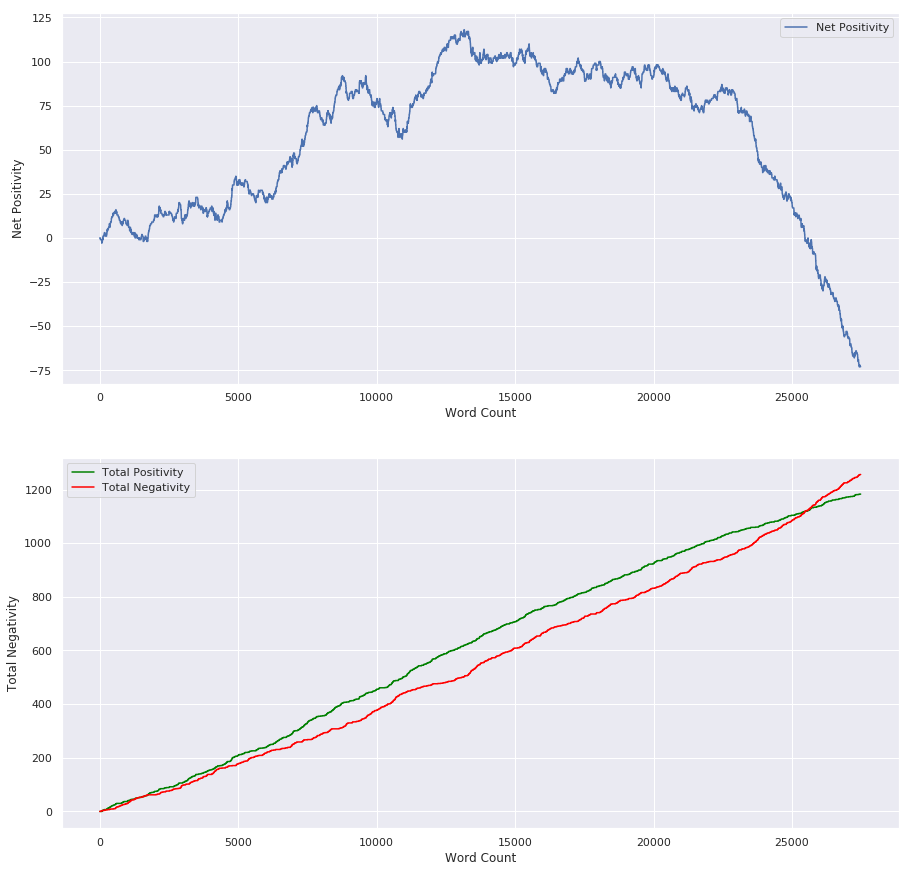

In [121]:
fig = plt.figure(figsize = (15, 15))
ax1 = fig.add_subplot('211')
ax2 = fig.add_subplot('212')



sns.lineplot(x = cum_pos_df.loc[:, 'Word Count'], y = cum_pos_df.loc[:, 'Net Positivity'], ax=ax1, label = 'Net Positivity')
sns.lineplot(x = cum_pos_df.loc[:, 'Word Count'], y = cum_pos_df.loc[:, 'Total Positivity'], ax=ax2, color='Green', label = 'Total Positivity')
sns.lineplot(x = cum_pos_df.loc[:, 'Word Count'], y = cum_pos_df.loc[:, 'Total Negativity'], ax=ax2, color='Red',   label = 'Total Negativity')


The above graph shows that Othello is actually (based on our measure) very positive until very close to the end of the play, when the positivity falls practically vertically. Even after 13000 words, we notice that the increase in positivity has stopped, and it very gradually slides downwards. This perhaps aims to creates a powerful sense of dread in the reader/watcher, as the sentiment stays balanced - in opposition to the positivity increase (albeit with a small dip) until that point. At around 22500 words, the sentiment nosedives within the spaces of around 5000 words.

Now we plot the scene end points on the total plot above. 

In [122]:
# Get length of each scene
scene_len =  (oth_df.loc[:, 'Text'].apply(lambda row: len(row.split())))
# Add 1 to index so we can match up more
scene_len.index += 1
# Cumulative sum, so we know where each scene ends. 
scene_len_cum = pd.Series(np.cumsum(scene_len))
#sns.wat(x = scene_len_cum.index, y = scene_len_cum)
end_point_list = list(scene_len_cum)

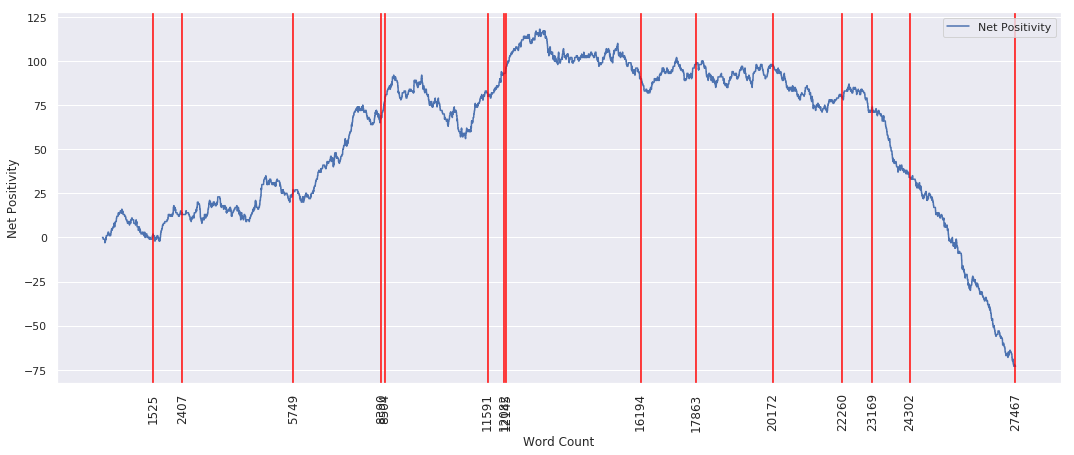

In [123]:
# Plot recreation
fig = plt.figure(figsize = (18, 15))
ax1 = fig.add_subplot('211')
sns.lineplot(x = cum_pos_df.loc[:, 'Word Count'], y = cum_pos_df.loc[:, 'Net Positivity'], ax=ax1, label = 'Net Positivity')
# Vertical lines
for x_point in end_point_list:
    ax1.axvline(x = x_point, color='red')

ax1.set_xticks(end_point_list)
ax1.tick_params(axis='x', labelsize = 12, labelrotation=90)
plt.show()

In [124]:
print('FIN')

FIN
